## Basis of plotting library

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import math

class StringArt:
    def __init__(self, radius=1.0, center=(0, 0), number_of_lines = 10, N = 10):
        self.radius = radius
        self.center = center
        self.N = N
        self.number_of_lines = number_of_lines
        self.nails = None  # nails positions
        self.string = None # string path
        self.string_length = None
        self.ax = None # shared axes

    def set_frame(self, N):
        theta = np.linspace(0, 2*np.pi, N, endpoint=False)
        x = self.center[0] + self.radius * np.cos(theta)
        y = self.center[1] + self.radius * np.sin(theta)
        self.N = N
        self.nails = np.column_stack((x, y))  # Store inside the object
        return 0

    def set_string_sequence(self, string_sequence):
        self.string = string_sequence
        return 0

    def print_string_sequence(self, output_file = "./output_sequence.txt"):
        block_size = 25
        numbers_per_line = 5
        if block_size % numbers_per_line != 0:
            print("ERROR: Block size is not divisible by numbers per line. Fix this!")
            return 1
        with open(output_file, "w") as f:
            block_number = 0
            for line_number in range(int(len(self.string) / numbers_per_line) + 1):
                if ((line_number * numbers_per_line) % block_size) == 0:
                    print(f"\n ----- Lines {block_number *block_size} to {(block_number+1)*block_size} ----- \n", file = f)
                    block_number += 1
                printed_sequence = self.string[line_number * numbers_per_line : (line_number + 1) * numbers_per_line]
                print(printed_sequence, file = f)
        return 0

    def set_string(self, number_of_lines):
        """Compute a string path (sequence of nail indices)."""
        if self.nails is None:
            raise ValueError("Call set_frame() first to generate nails.")

        # Example: random string path
        self.string = np.random.randint(0, self.N, size = number_of_lines)
        return self.string

    def set_string_length(self):
        """Compute approximate string length."""
        if self.string is None:
            raise ValueError("Call set_string() first to compute string path.")

        length = 0  # starting computation
        for i in range(len(self.string)-1):
            current_nail = self.string[i]
            next_nail = self.string[i+1]

            x1, y1 = self.nails[current_nail]
            x2, y2 = self.nails[next_nail]
            length += math.sqrt((x1-x2)**2 + (y1-y2)**2)

        self.string_length = length
        return self.string_length

    def get_frame(self):
        return self.nails

    def get_string(self):
        return self.string

    def get_string_length(self):
        return self.string_length

    def _ensure_ax(self):
        """Internal method to create a shared Axes if it doesn't exist."""
        if self.ax is None:
            fig, self.ax = plt.subplots(figsize=(15,15), facecolor='white')
            self.ax.set_aspect('equal')
            self.ax.axis('off')
        return self.ax

    def draw_frame(self, show=True, nail_size=5):
        """Draw the frame (nails on the circle)."""
        if self.nails is None:
            raise ValueError("Call create_frame() first to generate nails.")

        ax = self._ensure_ax()
        ax.scatter(self.nails[:,0], self.nails[:,1], s=nail_size, color='black')

        if show:
            plt.show()
        else:
            return ax

    def draw_string(self, show=True, string_color='black', string_thickness=0.5, alpha_value=1):
        """Draw a string path."""
        if self.string is None:
            raise ValueError("Call set_string() first to compute string path.")

        ax = self._ensure_ax()

        for i in range(len(self.string)-1):
            current_nail = self.string[i]
            next_nail = self.string[i+1]

            x1, y1 = self.nails[current_nail]
            x2, y2 = self.nails[next_nail]

            ax.plot([x1, x2], [y1, y2], color=string_color, linewidth=string_thickness, alpha=alpha_value)

        ax.set_aspect('equal')
        ax.axis('off')

        if show:
            plt.show()
        else:
            return ax


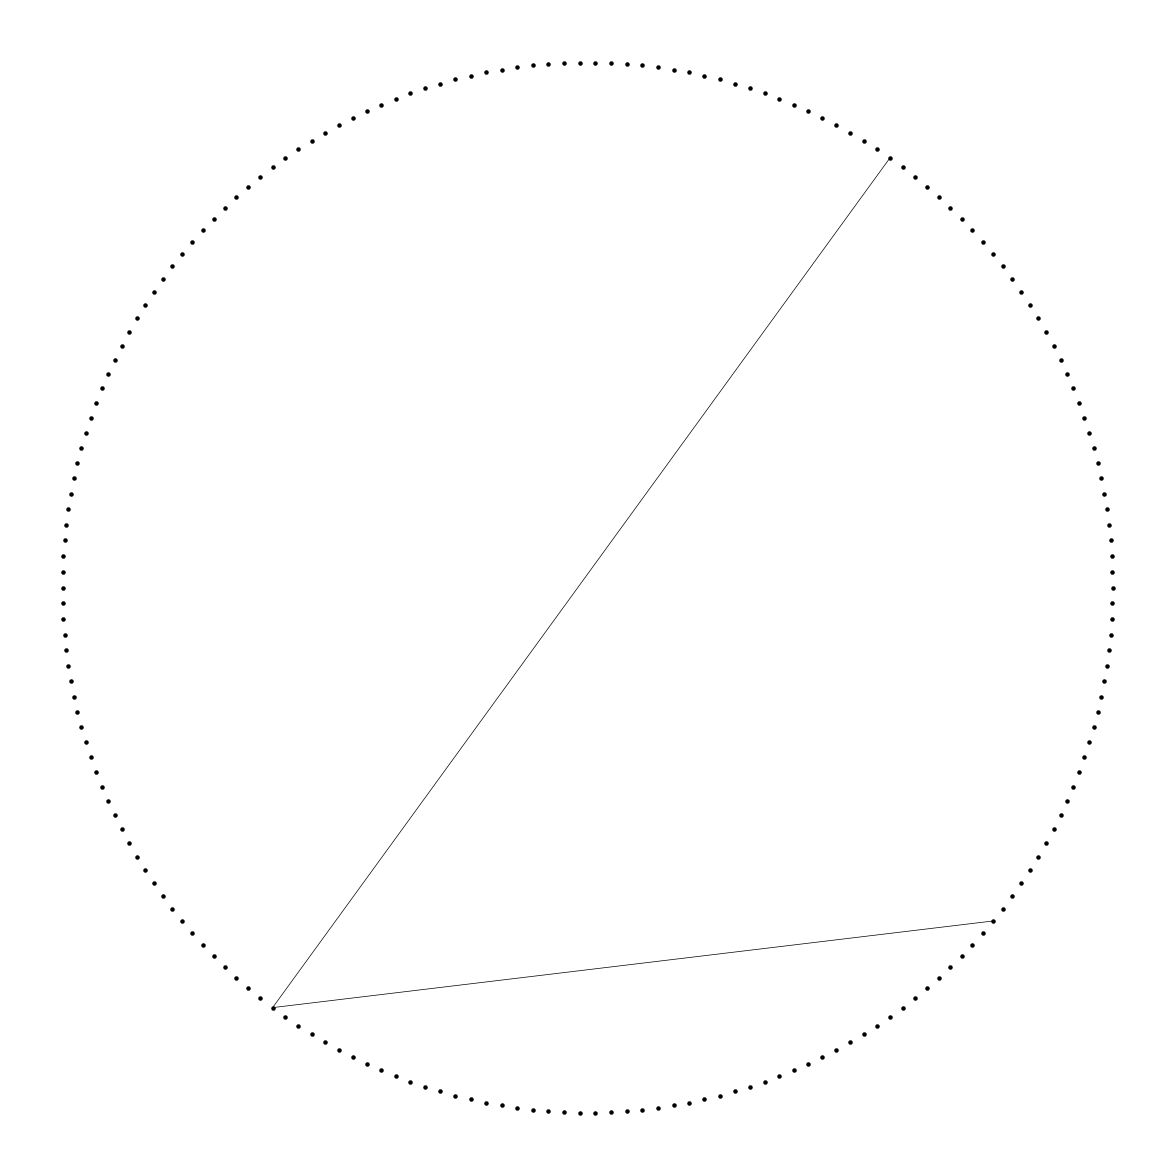

In [94]:
number_of_nails = 210
number_of_lines = 3

string_art = StringArt(radius=0.2)
string_art.set_frame(number_of_nails)
string_art.draw_frame(show=False)
string_art.set_string(number_of_lines)
string_art.draw_string()
#print(string_art.get_frame())

## Rescaling image and cutting it to circle

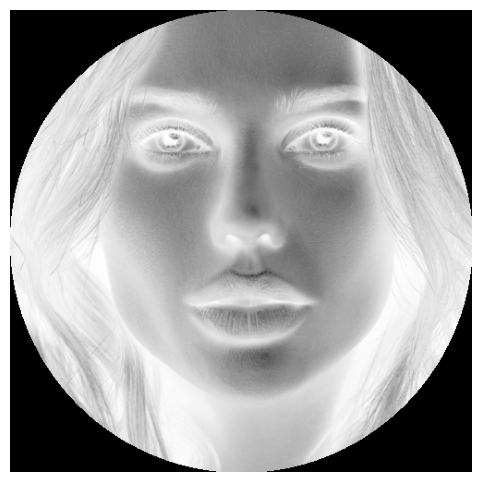

In [95]:
from PIL import Image, ImageDraw

size = 500

original_image = Image.open("./img/test_1.png")
greyscale_img = original_image.convert("L")             # convert to grayscale
resized_greyscale_img = greyscale_img.resize((size, size))       # optional resize

mask = Image.new("L", (size, size), 0)  # black mask
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, size, size), fill=255)  # white circle

# Apply mask
img_circular = Image.new("L", (size, size), 255)  # white background
img_circular.paste(resized_greyscale_img, (0, 0), mask=mask)

img_array = 255 - np.array(img_circular) # invert black to white
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(img_array, cmap='gray', vmin=0, vmax=255, alpha=1)
ax.axis('off')
ax.set_aspect('equal')
ax.axis('off')
plt.show()

## Plotting strings on circular image

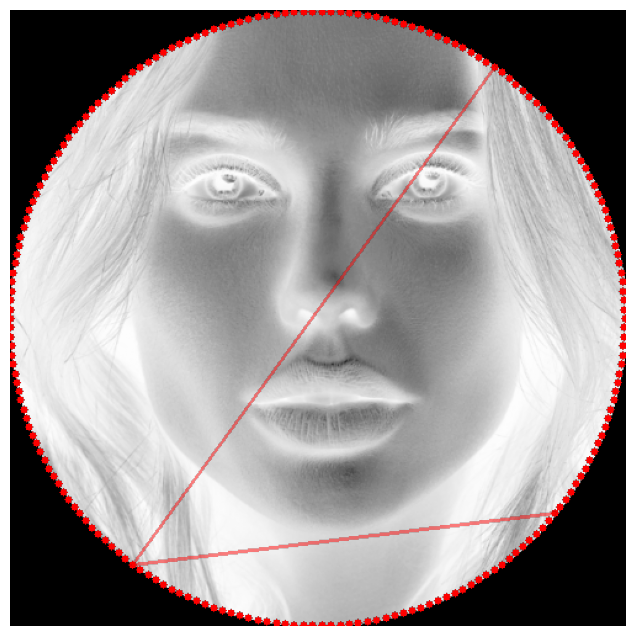

[187 136  32]
String length: 0.6763803003188553


In [96]:
import numpy as np
from skimage.draw import line
from skimage.morphology import dilation, disk

# we only work with square images
radius = 0.2
def position_to_pixel(x,y,
                      xmin = -1* radius, xmax = 1*radius, ymin = -1*radius, ymax = 1*radius, # radius of circle is 1
                      image_size_x = size, image_size_y = size): #size is global param for now
    frame_width = xmax - xmin
    frame_height = ymax - ymin
    pix_x = np.floor((image_size_x - 1) * (x - xmin) / frame_width ).astype(int)
    pix_y = (image_size_y - 1) - np.floor((image_size_y - 1) * (y - ymin) / frame_height).astype(int)
    return pix_x, pix_y

nails = string_art.get_frame()  # shape (N,2)
nails_x_coords = nails[:, 0]          # all x
nails_y_coords = nails[:, 1]          # all y

nails_pix_x_positions, nails_pix_y_positions = position_to_pixel(nails_x_coords , nails_y_coords )
canvas_nails = np.zeros((size, size))  # white canvas

# Set nail pixels to red
from matplotlib.colors import ListedColormap
nails_cmap = ListedColormap([[0,0,0,0], [1,0,0,1]])  # [R,G,B,A] for 0 and 1
canvas_nails[nails_pix_y_positions, nails_pix_x_positions] = 1  # note: numpy uses row, column = y, x

# Thicken it
thickness_nails = 3  # radius
canvas_nails = dilation(canvas_nails, disk(thickness_nails))

string_array = string_art.get_string()
canvas_lines = np.zeros((size, size))

# Draw strings
for i in range(len(string_array) - 1):
    start = int( string_array[i] )
    end = int( string_array[i + 1] )

    x0, y0 = nails_pix_x_positions[start], nails_pix_y_positions[start]
    x1, y1 = nails_pix_x_positions[end], nails_pix_y_positions[end]

    rr, cc = line(y0, x0, y1, x1)  # skimage.draw.line uses row=y, col=x
    rr = np.clip(rr, 0, size-1)
    cc = np.clip(cc, 0, size-1)
    canvas_lines[rr, cc] = 1  # mark line pixels black

# Thicken it
thickness_lines = 1  # radius
canvas_lines = dilation(canvas_lines, disk(thickness_lines))

plt.subplots(figsize=(8,8))
plt.imshow(img_array, cmap='gray', vmin=0, vmax=255, alpha=1)
plt.imshow(canvas_nails, cmap=nails_cmap, origin='upper', alpha=1)
plt.imshow(canvas_lines, cmap=nails_cmap, origin='upper', alpha=0.5)
plt.axis('off')
plt.show()

print(string_array)
string_art.set_string_length()
print(f"String length: {string_art.get_string_length()}")

## Greedy algorithm

Currently processing 0 out of 100.
Currently processing 50 out of 100.


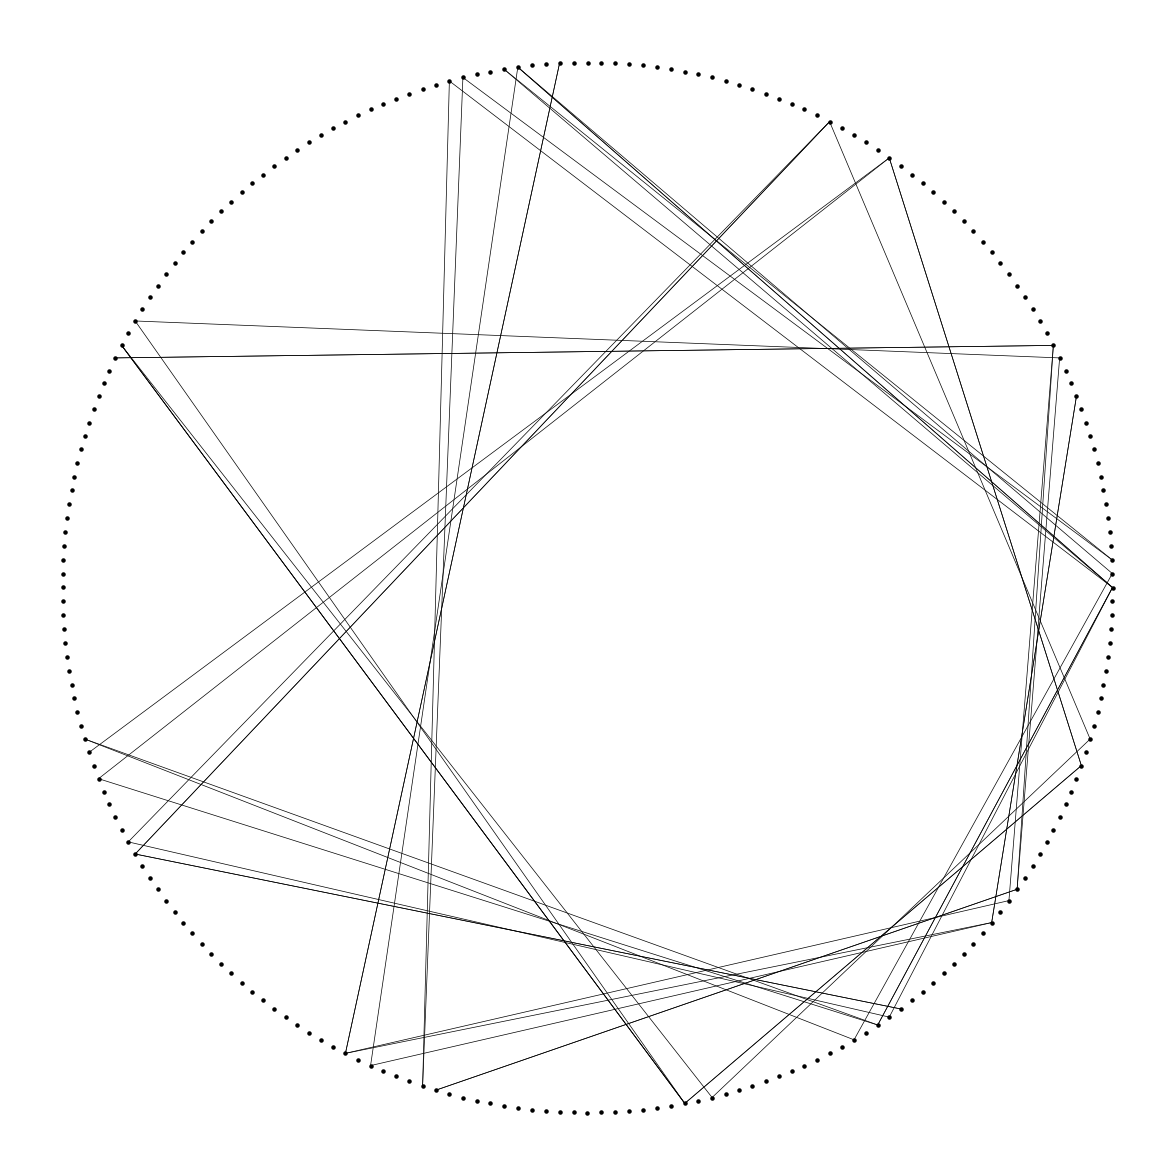

In [97]:
import numpy as np
from PIL import Image, ImageDraw

#input parameters
string_sequence = np.array([0]) # beginning of our string is at pin 0
number_of_nails = 236 # 300 nails default / my canvas has 241 (not 240!)
number_of_lines = 100 # 3000 best for testing
image_size = 500 # 500 producing good results
print_interval = 50

tested_nails = number_of_nails #60 working best fo far or number_of_nails
mask_weight = 40 # 6 working well

input_image = "./img/instagram/18_eyes.jpeg"

use_forbidden_areas = False
forbidden_mask = "./img/instagram/39_mask.jpeg"
allow_crossing_lines = False
crossing_lines_acceptance = 0.01

# creating string art object
string_art = StringArt(radius=0.2)
string_art.set_frame(number_of_nails)

# nails positions
nails = string_art.get_frame()  # shape (N,2)
nails_x_coords = nails[:, 0]          # all x
nails_y_coords = nails[:, 1]          # all y
nails_pix_x_positions, nails_pix_y_positions = position_to_pixel(nails_x_coords , nails_y_coords )

# input image canvas
original_image = Image.open(input_image)
greyscale_img = original_image.convert("L")             # convert to grayscale
resized_greyscale_img = greyscale_img.resize((image_size, image_size))       # optional resize
mask = Image.new("L", (image_size, image_size), 0)  # black mask
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0, image_size, image_size), fill=255)  # white circle
img_circular = Image.new("L", (image_size, image_size), 255)  # white background
img_circular.paste(resized_greyscale_img, (0, 0), mask=mask)
input_image_canvas = 255 - np.array(img_circular) # invert black to white
input_image_canvas = input_image_canvas.astype(float)

# forbidden mask canvas
original_forbidden_mask = Image.open(forbidden_mask)
greyscale_forbidden_mask = original_forbidden_mask.convert("L")
resized_forbidden_mask = greyscale_forbidden_mask.resize((image_size, image_size))
img_circular = Image.new("L", (image_size, image_size), 255)  # white background
img_circular.paste(resized_forbidden_mask, (0, 0), mask=mask)
input_forbidden_mask_canvas = 255 - np.array(img_circular) # invert black to white
input_forbidden_mask_canvas = input_forbidden_mask_canvas.astype(float)

def compute_normalized_score(image_canvas, line_coordinates):
    ys, xs = line_coordinates
    # score from the image along the mask
    score = image_canvas[ys, xs].sum()
    # normalization factor = number of pixels in this line
    normalized_score = score / len(ys)
    return normalized_score

def crosses_forbidden_area(forbidden_canvas, line_coordinates, tolerate_crossing_lines = False, acceptance = 0.2):
    ys, xs = line_coordinates
    sum = forbidden_canvas[ys, xs].sum()
    if sum == 0:
        return False
    else:
        if tolerate_crossing_lines:
            if np.random.random() < acceptance:
                return False
            else:
                return True
        else:
            return True

def create_line_canvas(line_start, line_end):
    x0, y0 = nails_pix_x_positions[line_start], nails_pix_y_positions[line_start]
    x1, y1 = nails_pix_x_positions[line_end], nails_pix_y_positions[line_end]

    canvas_line = np.zeros((image_size, image_size))
    rr, cc = line(y0, x0, y1, x1)  # skimage.draw.line uses row=y, col=x
    rr = np.clip(rr, 0, image_size-1)
    cc = np.clip(cc, 0, image_size-1)
    canvas_line[rr, cc] = 1  # mark line pixels black
    thickness_lines = 3  # radius
    canvas_line = dilation(canvas_line, disk(thickness_lines))
    return np.array(canvas_line)

# precompute all line masks in a dictionary
from pathlib import Path
import pickle

line_masks = {}
cached_line_masks_file = f"line_masks_sparse_{number_of_nails}.pkl"
p = Path(cached_line_masks_file)
if not p.exists():
    print("----- Computing line masks -----")
    for i in range(number_of_nails):
        print(f"nail {i}")
        for j in range(i):
            if i != j:
                line_mask = create_line_canvas(i, j)
                ys, xs = np.where(line_mask == 1) # store as sparse matrix
                line_masks[(i, j)] = (ys.astype(np.uint16), xs.astype(np.uint16))

    with open(cached_line_masks_file, "wb") as f:
        pickle.dump(line_masks, f)
else:
    with open(cached_line_masks_file, "rb") as f:
        line_masks = pickle.load(f)

# greedy algorithm
for line_number in range(number_of_lines):
    if line_number % print_interval == 0:
        print(f"Currently processing {line_number} out of {number_of_lines}.")

    highest_score = -np.inf
    best_nail = None
    best_line_mask = np.zeros((image_size, image_size))

    #for current_nail_number in range(number_of_nails - 1):
    for current_nail_number in np.round(np.random.uniform(0, number_of_nails - 1, size=tested_nails)).astype(int):
        dist = abs(string_sequence[-1] - current_nail_number)
        dist = min(dist, number_of_nails - dist)
        if (dist > 2):
            if string_sequence[-1] > current_nail_number:  # line masks are only (i,j) where i > j, because (i,j)=(j,i)
                line_mask = line_masks[(string_sequence[-1], current_nail_number)]
            else:
                line_mask = line_masks[(current_nail_number, string_sequence[-1])]

            if use_forbidden_areas:
                test_condition = not crosses_forbidden_area(input_forbidden_mask_canvas, line_mask, tolerate_crossing_lines = allow_crossing_lines, acceptance = crossing_lines_acceptance)
            else:
                test_condition = True

            if test_condition:
                current_normalized_score = compute_normalized_score(input_image_canvas, line_mask)
            else:
                current_normalized_score = -np.inf

            if current_normalized_score > highest_score:
                highest_score = current_normalized_score
                best_nail = current_nail_number
                best_line_mask = line_mask

    if best_nail is None: # can happen if using forbidden mask that touches edge of the canvas
        best_nail = int(np.random.uniform(0, number_of_nails - 1))
        # set its mask too so we can update the canvas safely
        if string_sequence[-1] > best_nail:
            best_line_mask = line_masks[(int(string_sequence[-1]), best_nail)]
        else:
            best_line_mask = line_masks[(best_nail, int(string_sequence[-1]))]

    ys, xs = best_line_mask
    input_image_canvas[ys, xs] = np.clip(input_image_canvas[ys, xs]  - mask_weight, 0, 255)

    string_sequence = np.append(string_sequence, best_nail)
    #print(f"    next nail: {best_nail}")

    if line_number % print_interval == 0 and line_number != 0:
        string_art_test = StringArt(radius=0.2)
        string_art_test.set_frame(number_of_nails)
        string_art_test.draw_frame(show=False)
        string_art_test.set_string_sequence(string_sequence)
        string_art_test.draw_string()



## Plot result over original image

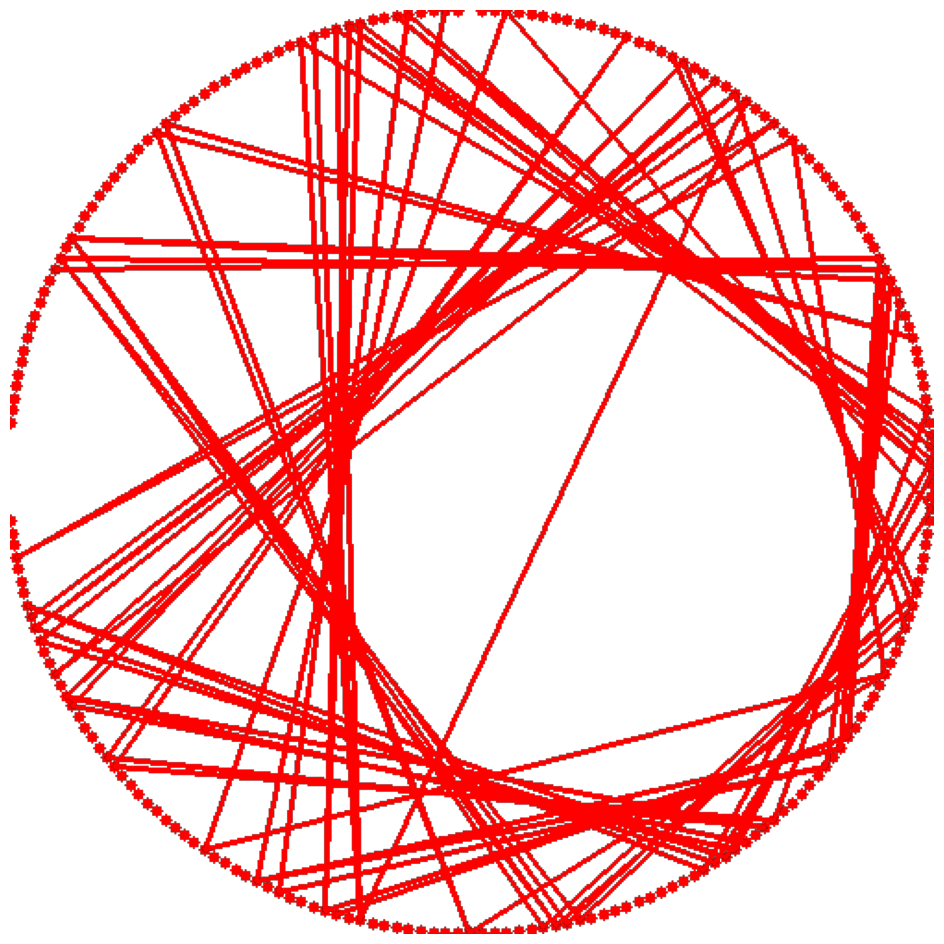

[  0 199   0  64 161 210  14 210 159  61 159 212  18 101  18 213 166 213
  17  98 184 223  36 223 184 100 184 100 186 225  41 138 201 138  41 137
 200   0  65   2  68 165  69   0  64   1 197 129 199 132  36 130  36 131
  36 223 184 100  17  98 185 226  42 226 183  98  16 213 165  69   3  70
 168  73   5 204 144  46 143 203 137  38 135  32 125  30 219 177  87  11
  86 177 219 154  56 233 198 131  35 168  72]
String length: 30.692825507239085


In [98]:
import numpy as np
from skimage.draw import line
from skimage.morphology import dilation, disk

string_art.set_string_sequence(string_sequence)

# we only work with square images
radius = 0.2
def position_to_pixel(x,y,
                      xmin = -1* radius, xmax = 1*radius, ymin = -1*radius, ymax = 1*radius, # radius of circle is 1
                      image_size_x = size, image_size_y = size): #size is global param for now
    frame_width = xmax - xmin
    frame_height = ymax - ymin
    pix_x = np.floor((image_size_x ) * (x - xmin) / frame_width).astype(int) - 1
    pix_y = image_size_y - 1 - np.floor((image_size_y ) * (y - ymin) / frame_height).astype(int)
    return pix_x, pix_y

nails = string_art.get_frame()  # shape (N,2)
nails_x_coords = nails[:, 0]          # all x
nails_y_coords = nails[:, 1]          # all y

nails_pix_x_positions, nails_pix_y_positions = position_to_pixel(nails_x_coords , nails_y_coords )
canvas_nails = np.zeros((size, size))  # white canvas

# Set nail pixels to red
from matplotlib.colors import ListedColormap
nails_cmap = ListedColormap([[0,0,0,0], [1,0,0,1]])  # [R,G,B,A] for 0 and 1
canvas_nails[nails_pix_y_positions, nails_pix_x_positions] = 1  # note: numpy uses row, column = y, x

# Thicken it
thickness_nails = 3  # radius
canvas_nails = dilation(canvas_nails, disk(thickness_nails))

string_array = string_art.get_string()
canvas_lines = np.zeros((size, size))

# Draw strings
for i in range(len(string_array) - 1):
    start = int( string_array[i] )
    end = int( string_array[i + 1] )

    x0, y0 = nails_pix_x_positions[start], nails_pix_y_positions[start]
    x1, y1 = nails_pix_x_positions[end], nails_pix_y_positions[end]

    rr, cc = line(y0, x0, y1, x1)  # skimage.draw.line uses row=y, col=x
    rr = np.clip(rr, 0, size-1)
    cc = np.clip(cc, 0, size-1)
    canvas_lines[rr, cc] = 1  # mark line pixels black

# Thicken it
thickness_lines = 1  # radius
canvas_lines = dilation(canvas_lines, disk(thickness_lines))

plt.subplots(figsize=(12,12))
#plt.imshow(img_array, cmap='gray', vmin=0, vmax=255, alpha=1)
plt.imshow(canvas_nails, cmap=nails_cmap, origin='upper', alpha=1)
plt.imshow(canvas_lines, cmap=nails_cmap, origin='upper', alpha=1)
plt.axis('off')
plt.show()

print(string_array)
string_art.set_string_length()
print(f"String length: {string_art.get_string_length()}")

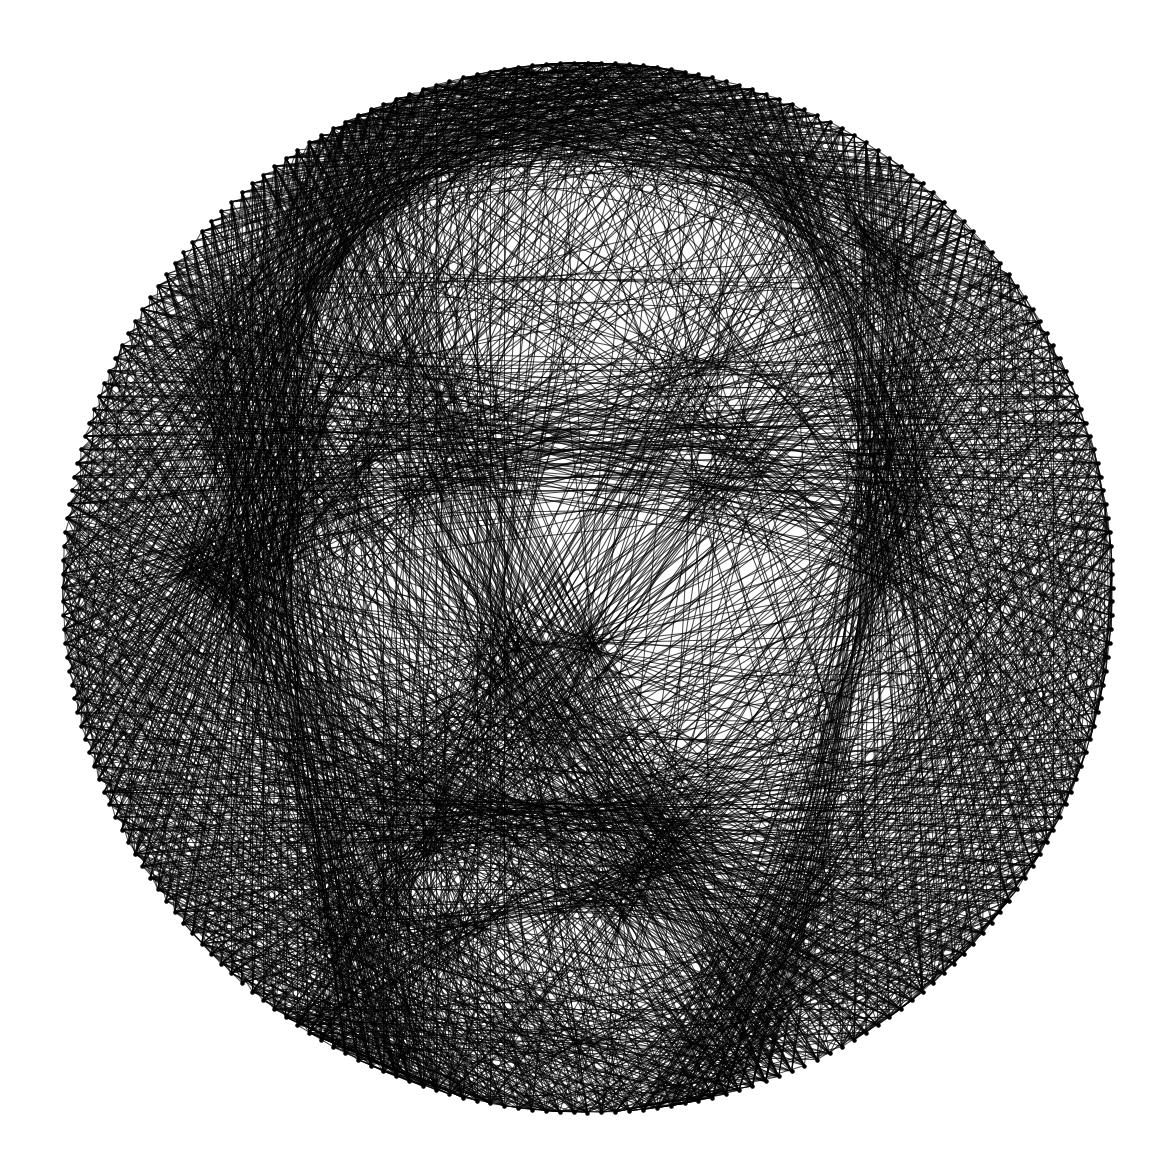

0

In [116]:
string_art_test = StringArt(radius=0.2)
string_art_test.set_frame(number_of_nails)
string_art_test.draw_frame(show=False)
string_art_test.set_string_sequence(image_tongue[0:2000])
string_art_test.draw_string(alpha_value=0.7, string_thickness=0.75, string_color='black', show=True)
#string_art_test.set_string_sequence(string_sequence[0:100])
#string_art_test.draw_string(alpha_value=0.7, string_thickness=0.5, string_color='orange', show=True)
string_art.set_string_length()
string_art.get_string_length()
string_art.print_string_sequence()

In [100]:
with np.printoptions(threshold=np.inf):
    print(np.array2string(string_sequence, separator=', '))

[  0, 199,   0,  64, 161, 210,  14, 210, 159,  61, 159, 212,  18, 101,  18,
 213, 166, 213,  17,  98, 184, 223,  36, 223, 184, 100, 184, 100, 186, 225,
  41, 138, 201, 138,  41, 137, 200,   0,  65,   2,  68, 165,  69,   0,  64,
   1, 197, 129, 199, 132,  36, 130,  36, 131,  36, 223, 184, 100,  17,  98,
 185, 226,  42, 226, 183,  98,  16, 213, 165,  69,   3,  70, 168,  73,   5,
 204, 144,  46, 143, 203, 137,  38, 135,  32, 125,  30, 219, 177,  87,  11,
  86, 177, 219, 154,  56, 233, 198, 131,  35, 168,  72]


In [101]:
image1 = np.array([ 10, 231, 146, 225, 138, 202, 134, 185, 127, 216, 148, 227, 143, 221, 147,
 231,   2, 243,  15, 239,  10, 237,   0, 245,  11, 239, 296, 236,   5, 241,
  14, 246,   3, 233, 148, 219, 138, 221, 133, 222, 136, 224, 133, 220, 135,
 221, 131, 219, 149, 218, 151, 211, 122, 176, 124, 198, 111, 166, 110, 169,
 115, 180, 128, 221, 151, 232, 146, 223, 144, 224, 141, 228,   5, 243,  18,
 245,  22, 271, 201, 129, 189, 134, 217, 128, 182, 104, 155,  96, 157, 240,
  14, 244,   3, 223, 137, 204, 280, 197, 109, 173, 107, 170, 100, 161, 218,
 130, 216, 164, 111, 162, 217, 131, 200, 273, 198, 128, 226, 143, 207, 145,
 220, 125, 217, 154, 222, 130, 214, 151,  94, 161, 104, 166, 221, 122, 223,
 298, 240,   7, 242,  23, 268,  19, 237,   9, 247,  10, 246,  21, 242, 296,
 238, 292, 210, 287, 208, 148, 224,   3, 228, 137, 218, 297, 232,   7, 240,
  20, 244,  30, 246,  13, 234,   0, 240, 291, 233, 149, 223, 129, 217, 152,
 208, 121, 212, 118, 201, 135, 215, 127, 224, 124, 203, 281, 210, 150, 217,
 117, 187, 114, 201, 136, 228, 142, 203, 133, 189, 136, 187, 109, 201, 139,
 203, 283, 205, 281, 207, 278,  50, 269,  42, 286, 211, 278,  53, 279, 205,
 144, 214, 294, 218, 116, 200, 133, 234, 297, 237,   3, 249,  21, 242,  15,
 240,   3, 242, 161, 286, 162,  95, 168, 104, 180, 109, 167, 116, 185, 103,
 181, 101, 153,  91, 156, 215, 117, 225, 140, 194, 273,  51, 267,  49, 265,
  46, 292, 237,  15, 239,  16, 249,  26, 253,  29, 246,  27, 250,  29, 276,
  52, 266,  48, 261, 191, 266, 189, 123, 226, 130, 181, 121, 178, 126, 222,
 138, 228, 128, 215, 131, 225, 120, 217, 139, 221, 134,  37, 253,  18, 114,
 172,  98, 168, 220, 141, 219, 134, 228, 126,  23, 124, 218, 147, 209, 284,
 214, 160, 246,   7, 248,   9, 249,  28, 270,  44, 290, 164, 103, 183,  94,
 169, 102, 160, 106, 174,  95, 155, 212, 115, 217, 295, 216, 165,  97, 152,
 216, 126, 232,   8, 238,  13, 248,  29, 251,  20, 250,  24, 273,  53, 273,
  51, 264,  39, 257, 181, 259, 184, 102, 186, 262,  46, 257, 177, 118, 222,
 122, 214, 154, 282,  42, 264,  17, 241,  18, 118, 214, 131,  25, 274,  52,
 264,  47, 270,  37, 247,  33, 249, 164, 246,  12, 227,   6, 248,  27, 125,
 227, 124, 221, 129,  29, 267,  45, 293, 221, 164,  96, 188, 135, 213, 145,
 203, 280, 212, 289,  41, 285, 207, 154, 283, 157, 238,   2, 245,  23, 243,
  30, 130, 215, 113, 201, 126, 225, 139, 191, 102, 153, 236,  12, 243,  20,
 127, 199, 107, 186,  94, 182, 254, 187, 257, 185, 264,  49, 260, 181,  97,
 148, 220, 119, 170, 294, 167, 116, 222, 132, 213, 153,  90, 150, 216, 142,
 193,  99, 173, 101, 178, 108, 159, 285, 203, 282, 155, 216, 110, 199, 117,
 221, 112,  15, 235,  10, 229, 123,  22, 126, 213, 119, 198, 106, 194, 268,
  50, 276, 198, 277,  28, 131, 213, 157,  89, 141, 217, 126, 229,   4, 248,
 167, 291,  42, 289, 165, 113,  13, 110, 172, 281,  32, 242, 295, 238, 290,
  48, 271,  50, 259,  49, 258, 175, 285, 211, 160,  95, 179, 255, 192, 101,
 195, 105, 179, 123,  23, 129,  34, 283, 155, 235, 151, 281,  39, 276,  50,
 274,  47, 269, 191, 257, 200, 136, 231,   8, 241,  31, 249,  36, 133, 231,
 155, 244,  26, 118, 172, 297, 246,   0, 226, 135,  32, 244,  24, 127, 219,
 113,  15, 264,  32, 119,  17, 235,  12, 230, 124,  26, 241, 295,  50, 265,
  24, 116, 178, 285, 204, 279, 149, 212, 146, 219, 126, 190, 138, 214, 114,
 218, 128, 229, 147,  96, 185, 267,  40, 252,  19, 117, 216, 280,  34, 241,
 156, 283, 217, 112, 163, 288, 165, 291, 213, 111, 221,   1, 225, 130,  36,
 132,  29, 131, 183,  93, 156, 103, 177, 255,  42, 275, 164, 289, 208, 133,
 191, 107, 164, 292, 241, 143, 225, 121,  19, 113,  23, 117, 203, 149,  92,
 177, 126,  22, 238,  17, 243,   7, 110, 210, 101, 213, 141, 221, 120, 226,
 126,  35, 278, 208, 157, 243,  33, 268,  43, 288, 162, 216, 132, 201, 141,
 208, 277,  49, 281, 170, 245,  14, 115, 221, 170, 296, 240,   9, 159, 288,
 180, 107, 196,  95, 194, 253,  33, 242,   6, 234, 135,  36, 245,   1, 224,
 139, 227, 119, 229, 133,  31, 136, 225, 125, 229, 157, 268, 190, 131,  23,
 115,  16, 111,  13, 240, 160, 285, 158, 218, 142, 193, 274, 166, 276,  54,
 268,  51, 264, 191, 121,  33, 124, 212, 136,  38, 277, 147,  93, 197,  98,
 187, 261,  51, 270,  25, 119, 223, 121, 228, 130,  22, 129, 215, 100, 199,
 137,  37, 282, 206, 279, 171, 278, 169,  97, 209, 274,  43, 281, 155,   4,
 223, 115,  17, 124,  12, 250, 163, 291, 161, 238, 152,   2, 249,  41, 287,
 180,  91, 184, 291, 207, 136, 205, 147, 295, 145, 296, 215,  75, 170, 295,
 165, 217, 109, 258,  51, 263,  44, 252,  48, 268, 193, 254,  28, 128, 235,
 134,  38, 243,  29, 130,  25, 117,  32, 118, 198, 103, 167, 223, 165, 274,
 198, 143,  91, 176, 283, 174,   2, 192, 275,  28, 141, 237,  16, 120, 197,
 267, 208, 149,  87, 181, 264, 199,  93, 153,   1, 149, 277, 212, 158, 242,
  24, 121,  12, 242,  34, 127,  30, 265,  17, 113,   9, 112, 219, 299, 171,
 298, 151, 299,  50, 256,  48, 269, 189,  92, 159, 241, 133, 238, 138,  32,
 270, 160, 288,  48, 246,  34, 278, 149, 298, 243, 155, 284, 201, 282, 153,
   6, 110, 176, 105, 255,  25, 240,  34, 128,  19, 127,  35, 239,  18, 122,
  13, 117, 211,  73, 166,  95, 198, 266,  51, 275,  40, 139,  37, 141, 293,
 169, 247,  96, 173, 280, 153, 231, 127, 223, 140, 234,  21, 126, 239, 185,
 294, 187,  97, 154, 245, 296, 190, 270, 186, 266, 155,   6, 111,  10, 162,
 287, 163, 275,  61, 278, 197, 138,  28, 136, 218, 100, 255, 186, 100, 211,
  96, 245, 132,  21, 231, 120,  19, 115, 226, 164, 105, 210, 290, 159,  12,
 111,  17, 234, 146, 278, 219, 123, 174, 259, 199, 122, 230, 135, 237, 139,
 209, 142, 293, 168, 278,  32, 254,  50, 262, 193,   1, 179, 288, 107, 261,
 112,  18, 247,  99, 213, 133,  16, 254, 200, 104, 155, 206,  98, 214,  76,
 212, 273,  61, 271,  26, 123,  13, 226, 137, 194, 248,  43, 263, 186,  93,
 209, 262, 179, 289, 238,  93, 175,   2, 147,   1, 250, 104, 255, 174,  94,
 196,  46, 266,  54, 278, 166, 217,  80, 168, 297, 189, 127, 213,  72, 211,
  98, 161,   6, 192, 260, 143, 208, 119,  20, 236, 142,  40, 270,  46, 281,
  32, 140, 220,  97, 222,  80, 173, 113, 181, 287, 160, 108, 259, 146,  95,
 182, 252, 101, 167, 107, 184,   8, 156,   6, 247,  47, 202, 287, 107,   4,
 237,  35, 276, 168, 245,  31, 135,  26, 140,  40, 282,  65, 278, 206,  93,
 245,  10, 232, 125,  12, 260,  47, 262, 150, 299, 146, 279, 165,  76, 217,
  78, 218, 151, 206, 144, 297, 169,  79, 220,  95, 158,   7, 116,  27, 233,
  90, 181, 241,  38, 135, 232, 122,  32, 248, 136, 220, 153, 207, 271, 193,
  91, 187,  36, 236, 150, 277,  45, 283,  34, 120,  24, 240, 188, 297, 148,
 222, 150,   4, 243, 100, 257, 176,  93, 144, 195,  42, 284, 204,  45, 280,
 148, 258, 111,   5, 157, 284, 212,  92, 178,  99, 258, 176,   4, 112,  21,
 125, 239,   8, 115,  25, 136,  35, 132, 214, 162, 272, 213,  73, 284, 154,
  89, 190, 262,  49, 269, 161,  13, 119,  34, 141, 292,  50, 263, 144, 216,
 121, 235,  93, 188, 250,  99, 150, 297, 154,   7, 186, 251,  48, 196, 104,
 248,  96, 240, 162, 235, 119,  15, 125, 234, 130, 197,  40, 244,  22, 228,
  86, 224, 164,  94, 253, 105, 283,  51, 261, 210,  92, 198, 249,   5, 182,
 257, 112,  14, 109, 283, 152, 214, 116, 179, 230,   9, 121,  10, 161, 224,
  95, 251, 194,  44, 267,  50, 255, 181,   3, 189, 271,  43, 191, 105, 161,
 289, 162, 103, 183, 110, 254, 141, 296, 174, 282, 225,  14, 113, 227, 298,
 247, 138,  37, 129, 229,  84, 183, 251, 166, 293, 138, 255,  49, 275, 151,
 292, 143,  33, 117,  30, 250,  96, 223, 114, 263, 182, 234, 158,   4, 180,
 103, 212, 143, 275, 189, 138,  25, 236,  89, 231,  25, 272,  56, 263,  53,
   1, 244,   4,  92, 221, 168, 298,  91, 223, 101, 199, 285,  69, 207,  98,
 216, 129, 180, 121, 224, 114, 286,  39, 143,  30, 279, 218,  97, 174,  79,
 289, 138, 226,   8, 160, 211, 123,  10, 110,  16, 238, 132,  26, 229,  82,
 220, 277, 167,  94, 244, 128,  36, 194,  89, 298, 143, 266, 156, 243, 160,
 272,  58, 270, 213, 117, 236,  11, 160, 109,  11, 157, 271,  41, 199, 114,
  25, 128, 222, 131,  37, 186, 296, 169,  81, 226,  90, 189, 101, 256, 203,
 287, 133, 197, 250,  51, 251, 103, 257,  49, 297, 216,  75, 219,  76, 282,
 170,  40, 273,  46, 203, 128, 242, 293,  77, 218, 109,  21, 121, 278, 192,
 120, 171,  85, 232,   1,  94, 205, 152,   8, 122, 177, 285, 200, 106, 254,
 177, 286, 157,  90, 229,  19, 130, 241,  93, 220, 130, 186, 293,  51, 200,
 276, 142, 214, 267,  56, 265, 180, 261, 113,   3, 156, 297, 175, 243,  49,
 294, 148,   0,  87, 227,   7, 152, 212, 132,  33, 185, 271, 195,  99, 210,
 288,  39, 145, 256, 108,   3, 153, 285,  71, 210, 112, 201,  14, 106, 288,
  72, 214, 123,  16, 129, 238, 187, 298, 153,   4, 232,  88, 147,  39, 200,
 119, 276,  66, 281, 156,  98, 164, 271, 161,   7,  94, 225,  22, 120,   9,
 178, 242, 123,  28, 230,  89, 296, 244,  28, 126,  36, 171, 280, 157, 247,
 196,  86, 183, 118,  34, 121, 233, 284, 104, 280, 120, 275, 222, 102, 216,
  97, 244,  11, 100, 192, 141, 273, 147,  36, 242, 170, 276, 213, 102, 172,
 223, 142,  30, 271,  23, 223,  83, 225,  99,  16, 132,  15, 134,  30, 118,
  13, 189,  36, 267,  26, 117,  11, 260, 170,  77, 221,  78, 290,  74, 173,
 260, 148, 214,  97, 256, 173,   4, 184,  35, 240, 182, 120, 206, 134,  83,
 172, 261,  52, 207, 269, 192,   1,  85, 197,  10, 225,  82, 168,  43, 292,
 211, 104, 188,  46, 263, 111, 182,  86, 294,  45, 184, 100, 259, 140, 292,
 167,  14, 163, 293, 117, 266,  42, 290, 167,  16, 232, 134, 249,   0, 170,
  68, 275, 206,  48, 201,  50, 252,  93,   3, 186,   1, 176, 125, 240,  41,
 191, 280,  48, 297,  85, 216, 115, 166,  75, 284, 130, 202, 282, 204, 259,
  47, 205, 277,  66, 157, 103, 171, 241,  23, 116, 290, 182,  44, 180,  94,
 240, 294,  81, 137, 290, 144,   1, 239,  36, 192, 256, 205, 280,  67, 286,
 198,   9, 182, 291, 142, 267, 147, 198,  48, 194, 139, 200,  12, 126, 298,
 141,  41, 138,  23, 133, 244,  48, 180,  78, 168, 248,  95, 150,  87, 194,
   1, 108, 169, 275, 146,   4, 220, 144, 276, 212,  74, 174, 287, 197, 275,
  63, 152, 264, 116,  31, 139,  86, 151,   9, 202, 290, 135, 262, 200, 283,
  78, 281, 175,  42, 196, 251,  93, 254,  43, 163, 108, 280,  75, 277, 211,
 109, 251, 106,  20, 117,   3, 147, 224,  91, 213, 264,  57, 271, 220, 122,
 207, 273, 149,   0, 229,  85, 187, 269,  59, 150, 276, 188, 106, 277,  37,
 286,  74, 288, 177, 102,  17, 166,  92, 241,  89,   4, 190,  34, 163, 228,
  89, 234,  26, 254, 193,  93, 165,  13, 242, 124,  19, 133, 250, 162, 213,
 100, 193, 299, 140, 191,  16, 134,  35, 188, 253, 142, 229,  13, 103, 281,
 190, 122, 227, 135,  17, 110, 167, 273, 184,  49, 266, 215,  95, 192,   3,
  96, 227, 142, 287, 111, 179,   5, 162,  69, 168, 281, 204,  56, 261, 101,
 249, 190,  12, 156, 105, 207, 150,  41, 269, 197,  13, 124, 290, 166, 298,
 173, 295,  53, 287,  70, 167, 249,  94, 146, 298, 232,  33, 128,  18, 231,
 118, 238,  38, 188, 102, 220,  99, 227,  21, 128,   2,  93, 218,  83, 230,
 128,  38, 140,  28, 164,  41, 169,  43, 264, 147, 298, 217, 269, 179, 124,
  24, 132, 183, 262, 203, 268,  69, 291,  83, 231,  30, 109, 177, 284, 159,
 274, 183,  33, 245,  16, 170,  18, 101, 245,  19, 137, 211, 125, 202,  99,
 239, 147, 228,  90,   4, 252, 178,  96, 238, 134,  18, 225, 276, 163, 214,
  54, 272,  47, 289, 159, 217, 143, 277,  55, 205, 122,  19, 104, 176, 289,
 148,  60, 263, 192,  15, 159,  35, 120, 212, 104, 278,  72, 209, 132, 288,
 138,  87, 239, 172, 299,  53, 210, 280, 149, 293, 219,  84, 193,  14,  95,
 156, 290,  41, 196, 273, 118,  25, 156,   2,  80, 167, 105, 248,  98, 149,
  58, 109, 247, 106, 187, 278,  78, 176, 231, 138, 272, 163,  29, 118,   2,
 154, 292, 183,  80, 213, 268, 180,  88, 236, 120, 277, 169,  22, 250,  92,
 253,  49, 193, 245,   8, 179, 287, 161, 251,  94, 212,  97, 226,  80, 280,
  49, 279,  60, 146, 208, 264, 171,  99,   5, 175, 124,  28, 159, 299, 142,
  85,   7, 130,  38, 138, 292,  73, 214, 275,  73, 295, 114, 165,  12, 202,
 151, 269,  62, 256, 113, 210, 279, 167, 282,  63, 278, 195,  43, 161, 273,
 189,  96, 206,  70, 264, 176, 227,  94, 217, 101, 191,  86,   6, 178, 263,
 152, 281,  41, 242, 179,  91,   3, 191, 245,  47, 207,  45, 286, 134,  14,
 131,  38, 244, 169, 220, 113,  24, 115, 186, 112, 290, 107, 263, 198, 268,
 154,  23, 151, 284,  48, 240,  93, 223, 125,  11, 107, 218,   1, 128, 211,
 144, 271,  68, 288,  81, 220,  90, 141,  33, 240, 184, 250,  61, 116, 286,
 228,  93, 296,  80, 287, 176, 270, 139, 293,  87, 234, 287, 196, 270, 146,
  56,   5, 112, 216,  93, 162,  65, 289, 145,  28, 252, 201, 146,   5, 159,
 268,  98, 196, 277, 154,   8, 113,  30, 178, 253,  91, 243,  95, 208, 290,
 160, 105,  14, 114, 283, 128,   9, 162, 111, 225, 101, 183, 260,  53, 139,
  83, 232, 124, 213, 286,  47, 199, 105, 181,  77, 294,  54, 206, 292,  78,
 222, 134,  27, 142,  50, 183, 108,  29, 232,  12, 251,  50, 188, 295,  46,
 241,  24, 150, 215, 272, 219,  96, 202, 269, 177,  73, 181,   0, 193,  37,
 170, 113, 270,  70, 161, 253, 196, 283,  83, 279, 150, 272, 142, 294, 140,
  82, 135, 229,  20, 110,  56, 292, 118, 278, 148, 207, 259, 109,   2,  53,
 111, 288, 157, 266, 204,  68, 278, 226,  87,   5, 149, 257, 178, 127,  21,
 174, 284, 195,  83, 299,  76, 215, 110,  27, 132, 232, 172, 258, 165,  18,
 254,  52, 211, 139, 197,  11, 181,  43, 190, 103, 210, 156, 272, 200, 137,
 297, 167,  45, 190,  88, 238, 186,  32, 134, 291, 123,  17, 231,  86, 229,
  33, 123, 294, 243, 123, 185,  95, 249,  51, 112,  16, 265, 206, 102, 244,
 171,  67, 205, 116, 237,  24, 158,   6, 145,   0, 116, 265, 158,  10, 142,
 277, 170, 284,  82, 287, 182, 236,  39, 130,  77, 284, 179, 252, 162, 237,
 133, 256, 136,  30, 123,  72, 284, 135, 202,  55, 293,  44, 124, 293, 152,
 274,  50, 204,  18, 195,  84, 230, 283, 202, 286, 133,  38, 196,   2, 224,
  27, 227,  92, 252,  63, 163,  97, 249, 153,  13, 195, 267,  76, 184,  39,
  92, 246, 127,   3,  79, 270,  75, 127, 236, 119, 281, 105,  53, 146,  62,
 254, 157,  88, 222, 160,  14, 110,  30, 131,  20, 169,  68, 208, 135, 289,
 141, 242,  88, 290,  70, 159, 292, 125, 179, 108,  21, 243,   6, 199, 284,
  35, 172, 237, 158, 269, 115, 215, 103, 282, 209,  54, 108,  45, 174,   6,
  60, 274,  74, 217,  55, 273, 115, 203, 260,  57, 203, 123, 180, 271, 138,
  18, 141, 264,  27, 140,  56, 153, 245, 166,  42, 123,  34, 244, 162,   2,
 114, 294, 166, 289, 183, 234, 167, 261, 210, 268, 116,  13, 146, 295,  71,
 263, 172,  81, 232,  28, 144,   9, 152, 266, 171, 240, 124,  16,  68, 269,
 150,  57, 292, 171, 105, 187, 248, 162, 292,  47, 101, 258, 184,  34, 181,
 293, 154,  44, 109,  20, 137,  29, 115,  32, 274, 147, 269,  20, 197, 248,
 154, 286, 192, 276, 106,  47, 187,  52, 217,  89, 205, 154, 279, 112,  60,
 257, 131,  16, 114, 260, 180, 241, 124,  29, 229, 141,  11, 113, 175, 255,
 204, 123,  46, 295, 169, 117, 282,  61, 161,   3, 179,  98,   6,  92, 294,
  52,   1, 233,  18, 120,  31, 228,   6, 121, 215,  99, 273, 137,  28, 104,
 256, 185, 272, 100, 223,  94, 257, 167,  12, 154, 244,  19, 207, 101, 283,
 131, 259, 147, 292, 200,  56, 270, 201,  10, 131, 239, 299, 122, 277, 162,
  68, 120,  11, 191, 279, 145,  63, 115, 219, 150, 291, 131,  32, 152,   4,
 222, 168,  39, 132, 199, 274, 139,  24, 227, 137, 188,  90, 289,  66, 261,
 153,  26, 275, 145,   8, 237,  94,  37,  88, 148, 263, 154, 100,  44, 202,
 253, 160,   7,  59, 265, 211,  95, 235,  85, 283, 159, 255, 187,  14, 141,
   1, 247, 191, 135,  39, 201, 131,  41, 192, 272,  62, 156, 270, 148,  24,
 221])

In [102]:
image2 =  np.array([ 10, 245,  18, 243,   3, 279,   1, 266, 285, 297, 240,  11, 238,   4, 242,
   8, 270,  49, 265, 289, 209, 149, 124, 168, 136, 222, 133, 221, 150, 112,
 171, 122, 215, 135, 219, 134, 188, 151, 230, 147, 101, 158, 216, 130, 202,
 136, 180, 118, 217, 153, 236,   7, 275,   3, 246,  22, 244,  28, 251,  26,
 274, 287, 210, 120, 176, 110, 199, 159, 125, 216, 142, 203, 121, 223, 128,
 217, 296, 263,  12, 247,  16, 236,  10, 249,  31, 250, 168, 149, 225, 133,
 191, 150,  95, 155, 229, 144, 212, 118, 219, 141, 222, 116, 187, 107, 200,
 123, 212, 288,  42, 268, 294, 238, 299, 220, 130, 199, 274, 285, 159, 202,
 280, 211, 162,  97, 142, 178, 103, 189, 265,  51, 274,  49, 261, 185, 152,
 219, 115, 197, 276,  20, 253,  23, 240,  15, 113, 199, 133, 230,   4, 265,
  46, 271, 297, 281, 206, 147, 234,  13, 241, 161, 197, 106, 140, 226, 125,
  22, 127, 225, 118,  25, 246,  33, 249,   7, 225, 138, 191, 144, 208, 136,
 217, 115, 213, 127, 229, 138, 185, 156, 284,  41, 254, 181,  93, 161, 214,
 143, 100, 172, 143, 232, 132,  34, 244,  37, 130,  29, 266,  12, 234, 132,
  28, 271,   9, 267,  49, 257, 191, 264,  49, 259,   2, 287, 160,  95, 165,
 289, 162, 246,  35, 127,  92, 177, 222, 129, 212, 100, 152,  89, 155, 217,
 113,  17, 240,  19, 233, 126, 214, 286, 298, 245,  13,  28, 133, 203, 157,
 183, 109, 220, 113,  12, 229,   6, 247,   8, 110,  13, 237, 152, 117,  25,
 133,  31, 252,  25, 122, 217, 141, 179, 260, 298, 172, 150, 280, 267,  48,
 276, 203, 145, 206, 284, 203, 271,  40, 141, 102, 199, 161, 272,   3, 153,
 280,  18, 236, 131,  89, 149, 195,  95, 176, 284, 158, 245,  40, 277, 166,
 292,  43, 249, 174,  99, 190, 269,  48, 244, 164, 196, 110,  16, 119,  32,
 242, 151,   4, 225, 113, 222, 122,  20, 125, 100, 223, 152, 220, 133, 228,
 147, 298, 222, 203,  46, 283, 239, 126,  28, 124, 230, 121,  21, 128, 148,
 296, 169, 216, 178,  86, 227, 168, 277, 148,  97, 212, 155,   5, 251, 103,
 148, 260,  51, 263, 204, 128, 232,  24, 278, 291,   2, 253, 102, 257, 108,
 139, 221,  78, 216, 119,   9, 242, 141, 208, 163, 287, 180, 214,  74, 217,
 165, 293, 141,  37, 135, 197,  93, 183, 259, 101, 208, 258,  30, 117,  23,
 235,  91, 185, 292, 262,  15,  26, 229,  19, 127,  24, 136, 230,  25,  49,
  31, 115,  92, 166, 275,  62, 282, 152,   1, 155, 265,  41, 243,  94, 152,
 193, 254,  15, 128, 209,  97, 242, 159,  10, 162, 291, 167, 192, 136, 251,
  50, 255, 112,   7, 260, 111, 218, 139, 247,  32, 135,  18, 254,  98, 226,
 148, 212,  74, 166, 251,  21, 239,  35, 124, 240, 168, 207, 290,  39, 146,
   1, 269,  55, 278, 267, 187, 258, 140, 212,  92, 124,  26, 116, 182,   4,
  17, 261, 177,   2, 108, 223,  83, 229, 130,  20, 242, 123,  11, 197,  46,
  33, 185, 213,  94, 245,   7, 153,  91, 223, 135, 288, 178,  94, 163, 220,
 101, 160,   8, 198,  44, 266,  14, 111,  22, 237,  90, 243, 129, 200, 105,
 252, 199, 282, 296, 247, 205, 274, 285, 155, 190,  47, 260,  20, 115, 147,
 202,  50, 243,  96, 117,  13, 160,  99, 193, 130, 239, 140,  27, 226,  88,
 187, 295,  79, 173, 280,  73, 214, 278, 145, 298,  46, 245, 128, 237,   6,
 265, 183, 163, 271,  43, 252,  93, 221, 117,  10, 240,  99, 211, 125,  34,
 184, 141, 237,  36, 137, 215, 153, 207, 105, 125, 294, 139,  29, 250, 110,
 172,  81, 225,  90,   4, 268,  59, 276, 151, 224, 172, 299, 288,  70, 283,
 105, 225,  29,  54,  22, 231,  82, 168, 196, 108, 151,   9, 163,  42, 199,
 279, 170, 116,  29, 121,  13, 194,  47, 196,  87, 229, 105, 188, 271, 242,
 208,  71, 167,  15, 133,  38, 246,  89, 296, 156, 201,  92, 216,  76, 280,
   6, 177, 298,  87, 233, 149, 292, 240, 278, 204,  44, 263,  53, 210,  95,
 174, 285, 198,  98, 132, 223,   9,  22, 120, 147, 267, 253,  48, 288,  41,
 204, 259, 191, 116,  33, 292, 146,  96, 247, 127, 252, 109, 159,  26, 227,
 135,  27, 142, 235,  37, 278, 201,  53, 144,   2,  93, 255,  18, 166,  76,
 175,   3, 232,  15, 193, 104, 155, 221,  95, 251, 204, 268, 158, 289,  68,
 170,  35, 129, 236, 169,  44, 179, 286,  73, 276, 102, 210,  69, 158, 117,
 273, 139, 190, 297, 147, 262, 110,  79, 278, 120, 206,  97,   9, 122,   6,
  55, 216, 176, 255,  31,  60, 149, 281,  66, 162, 252, 195, 115,  77, 279,
 196, 163, 294, 184,  49, 240, 210, 251,  62,  20, 226,  96, 164, 290,   1,
  85, 234,  95, 184, 272, 200,   7,  84, 180,  75, 283, 210,  50,  33, 240,
 125,  16, 109, 186,   8, 257, 193,  37,  53,  14, 158, 102,  18, 117, 140,
 267, 207, 130,   6, 227,  88, 173, 262, 274, 167, 131, 198,  55, 141, 291,
 205,  21, 145, 271, 214,  96, 219, 160,   0, 189, 260, 107,  30, 130,  11,
 161,  68, 286, 133, 231, 251,  49, 282, 107, 263,  67,  29,  13,  95, 255,
 126, 221, 146, 165, 190,  41, 200,  98, 162,  25, 275, 105, 286, 230, 297,
 125,  24, 228,  84, 221, 143, 103, 128, 239,   2,  57, 264, 243, 166,  94,
 249,  52, 269, 154, 278, 101, 181,   9, 198, 103, 247, 213,  79, 183, 133,
  18,  67, 290,  35, 120, 234, 131, 186, 271,  76, 218, 148, 196,  13, 126,
 281, 166, 219,  89, 293, 140, 223, 114,  14,  93, 256, 109, 210, 183, 153,
 275,  82, 297, 138,  23,  60,  39, 192,  17, 170, 295, 262, 274, 160,  34,
 121,  77, 298, 183, 275,  42,  53, 242, 103, 151, 279, 233, 154,  57, 150,
  42, 175, 258,   4, 143, 277,  68, 257, 210, 192,  87, 240,  94, 298, 226,
 112, 148,  62, 263, 187,  51, 189, 254, 160, 267, 181,  82, 230, 212,  49,
   0,  74,  38,  23, 151, 290, 210,  93, 259,  63, 248, 200,  54, 209, 104,
 121, 225, 130, 148,   5, 139,  84, 120, 242,  15, 282, 293, 202,  13, 222,
  91, 167, 279,  34, 157, 220,  26, 131,  76, 222,  22, 176, 108,  29, 119,
 186,  77, 164,  20, 138,   8, 230, 245,  32, 188,  74,  29, 213, 172,  67,
  37, 255,  71, 238, 146, 257,  22, 198,  84, 294, 172, 121, 240, 104, 231,
  67, 205,  39, 129,  85, 115,  60, 272, 143, 207, 272,  52,  39, 201,   6,
  99, 250, 138,  30, 224, 254,  96, 112, 250,  89, 157, 199, 176,  87, 287,
  72, 281,  21, 248, 113, 203, 150,   0, 169, 216, 266, 117, 217,  99, 224,
  65,  32, 127, 208, 118,  11, 133, 194, 283, 160, 181,  35,  79, 226, 239,
  63, 268,  77, 263,  29, 176, 282, 121, 179, 256,  70, 115, 236,  83, 170,
 275, 241,  57,  42, 241, 253, 196,  85, 214, 139, 285,  17,   4, 293, 126,
  50, 277,  81, 288, 104, 162,  32,  83, 215, 124, 165, 150, 296,  51, 201,
 128,   8, 166, 229,  96, 157,  27, 267, 192, 108, 278, 142, 290, 203, 282,
 232,  92,  23, 113, 211, 274, 178, 270, 257, 218,  72, 169,  19, 107,  55,
 259,  67, 279, 290, 182,   1,  65, 177,   9,  20, 207, 141,  28, 218, 110,
 286,  44, 123, 233,  21,  66, 174, 134, 218, 262,  92, 214,  48, 192,  93,
 168,  88, 238,  65,  53, 115, 274, 186,  90, 108, 291, 178, 197,  45, 175,
  31, 247,   2, 149, 132, 238, 107,  11, 121, 277, 146, 268, 186,  52, 146,
  10,  40, 243, 254,  72, 296,   8, 223,  21, 201, 154, 267, 210,  38, 136,
  97, 165, 288, 132, 159,  51, 280, 128,   1,  43, 217,  31, 103,  62, 182,
 249, 102, 215, 183, 111, 228, 148, 256,  35, 118, 246, 150, 205,  70, 173,
 204,  45,  93, 257, 295, 232,  90, 284,  47, 188,  14,  27, 295,  87, 247,
 207, 275,  76, 169,  85, 194,   8, 244, 220,  23, 132, 233,  45, 166, 117,
  57, 195,  98, 252,  73, 242,  47, 173, 283, 101, 164, 296, 153, 112, 259,
 273, 235,  71,  15, 228, 157,  56,  92, 291, 157, 111, 213, 143,  19, 269,
 134, 224, 139, 119, 299,  75, 197, 274,  84,   5, 174, 260,  53, 184,  78,
 217,  17, 238, 177,  41,  28, 181,  91, 138, 295, 202, 287, 226,  17, 136,
 286,  89, 223,  42,  72,   9, 148,  91, 218, 168, 263, 136,   9,  88, 161,
 248, 191, 153, 276, 163,   8,  82, 224, 123, 107, 279, 129, 100, 210, 199,
   7, 120,  26,  62,  11,  67, 237,  43,  32, 137, 222, 154,  22, 122, 236,
  74, 285, 152, 297,  79, 229,   5, 263,  47,  63, 145,  14, 104, 245, 258,
 125,  54, 219, 181, 164, 275, 247, 148,  50, 117, 248,  60, 264, 171,  71,
 112, 281, 293, 143, 205,  90, 292, 161, 197,  56, 139, 261, 272, 168, 242,
 199, 215,  79, 129,  22, 192, 262,  70,  23,  34, 145,  97, 212,  84, 235,
 130,  34, 194, 172,  96, 112,  30, 261,  82,  36, 243,  64, 227, 238, 287,
 173,  43, 198, 260, 180, 273, 132, 298, 123, 294,   5, 276,  52, 265,  28,
 226, 178,  80, 169, 100, 260, 207, 138,   6, 114, 193, 150, 232,  96, 268,
  22,  11, 157, 295,  81,  23, 142, 258, 108, 199,  54, 110, 208, 223,  33,
 211, 116,  66, 265, 187,  61,  37, 249, 139, 124, 196,  92,   3, 145, 230,
  54, 142, 273, 284, 192, 176, 275, 157, 284,  33, 205, 148, 163,  22,  87,
 294, 282, 123,   4, 231, 244, 256, 158,  48, 128,  12, 236,  94, 108, 229,
 172,  16,   5, 181,  64,  78, 261,  98, 155, 171,  48, 292, 131,  29, 253,
 184, 290,  94,  38, 207, 270, 202,  97, 218,  58, 240,  74, 141, 275, 167,
 266, 277, 130, 189,  43, 298,  69, 123, 208, 222, 256,  64,   5, 141, 284,
 106, 223, 149, 276, 159, 221,  77, 137, 233, 142, 254, 101,  36, 116,  27,
 255, 133, 290, 278,  18, 123, 108, 214, 259,  61,  89,  76, 187, 203,  48,
  34, 172,  62,  14, 120, 244,  92, 179,   1, 244, 140, 210, 160,  46, 269,
 145, 197, 290, 148, 185, 270,  61, 229,  98, 267,  25, 135, 124, 290,   1,
 117, 146, 265,  35,  46,  58, 106,  21, 275,  75, 223,  68, 236, 147, 211,
 265, 120,  23,  12, 286, 140, 277, 205, 172, 262, 273, 182,  80,  94, 176,
  25,  53, 231, 143, 239, 253,  94, 159,   3,  87, 220,  42, 191, 207,  43,
 244,  26,   0, 146,  51, 242,  98, 111, 127, 286, 100, 135,  48,  91, 258,
 129, 231, 154, 102, 203,  83, 287, 276,  56,  69, 168, 154, 285, 296, 119,
 197, 247,  34, 229, 216, 161, 201, 299,  66, 197,  23,  35,  46, 174, 185,
  15, 144, 129,  59, 273, 262, 213,  89, 236, 224,   6,  20, 141,  58, 193,
   1, 288,  72, 157,   4,  16,  97,  37, 233, 107,   4, 238, 249, 146, 216,
  47, 279, 139,  24, 230, 258, 114, 201, 283, 178, 192, 101,  12, 116, 102,
 217, 206, 155,  49, 189, 261,  50,  19,  30, 105, 264, 146,   6, 209,  70,
  81, 232,  51, 170,  65, 241, 130, 256, 241, 211, 151, 167,  94,  41,  27,
 272,  95, 136, 281, 270,  97, 176, 115, 286,  45, 243, 255, 150, 222,  82,
 220,  15, 201, 169, 265,  76, 193, 260, 221,  53, 158, 280, 291, 164, 177,
  20, 235, 117, 130, 146,  13,   2, 277,  11,  72, 153, 229, 241,  54, 146,
 297,  98, 158, 202, 215, 120, 283,  45,   6, 173,  32,  21,  10, 134, 252,
 164, 270, 128, 282, 294,  88,  72, 215, 228, 175, 191,  40, 254, 194,  36,
 167,  89, 263, 184, 296,  70,  58, 134, 104, 146, 157, 282, 148, 233,  72,
 276, 180,  43, 160, 273, 204,  92,  78, 116, 128,  28,  17, 184,  68, 226,
 251, 262, 273,  76, 141, 153,  98, 113,  50,  63,  23, 100, 249, 238,  34,
 137, 124, 203, 281, 292, 140,  22, 200, 215,  18, 127, 241, 230,  86, 192,
   9,  20, 112, 261,  96, 291,   6, 293,   4, 131, 215, 282, 108, 120, 294,
 248, 259,  83,  18,   6,  86, 180, 164, 194, 280,  58,  46,  21, 254, 170,
 232, 133, 180,  68, 262,  14,   3, 110, 246, 232,  47, 193, 209, 268, 281,
 152, 137,  28,  60, 192, 116, 284, 146,  75, 203, 217, 228, 139, 294, 161,
 271, 260, 125, 288,  67,   5, 106, 247,  65,  13, 190, 178,  24, 191,  73,
 101, 218, 279,  75, 124,  10, 297, 136,  40,  27,  97, 230, 143, 257, 246,
 163, 278, 238, 139, 105, 287, 205, 217, 107, 206,  12, 224, 213,  76, 241,
 228, 197, 114, 295,  41,  52, 253,  60,  48,  37,  26, 112, 100,  88, 208,
 155, 166, 237,  81,  40,  51, 283, 295, 284, 171, 159,  72, 291, 112, 212,
 289,  43,  30, 205,  82, 215,  60, 239, 271, 260, 248,  27,  38, 165, 207,
 146, 157,  84, 181, 170, 266, 277, 123, 138, 124, 189, 201,  84,  98, 165,
  19,   7, 296, 177,   5, 236, 106,  28,  16, 156, 204, 279, 234, 245, 274,
  82,  71,  59,  15, 257, 269, 142, 156,  21, 143, 223, 174, 191, 202, 292,
   4, 149, 255, 181,  50,  39,   5,  91, 105,  12, 122, 110, 215,  69, 175,
  34,  23, 104, 157,  88, 179, 263, 274, 221, 208,  19, 182, 292, 279, 147,
 261, 133, 120, 211, 227,  67, 297, 259, 248,  95, 238, 250, 122, 106, 240,
  47, 266,  39, 245, 203,  72, 261, 273,  90,  15, 114, 169, 155, 227,  55,
 280,   1,  12, 198, 184, 200, 121,  20, 193, 142, 127, 164,  54,  65, 280,
 100, 111, 204,  68, 134, 231,  78,  25,  58, 266, 106, 219, 278,  70, 239,
  51,  38, 281,  45,  33,  22, 183, 171,  89,  77, 252, 131, 266, 157, 248,
 194,  46,  57, 164, 141,  82, 171,  19,   7,  18, 289, 276, 288, 159,  89,
 100,   5, 204,  97, 167, 202,  38, 192,   3, 291,   3, 292, 208, 245, 277,
 288, 224, 235, 123, 137,  30, 166, 284,  68, 268, 256,  48,  59,  71, 179,
 237, 105, 234, 129, 143, 291, 115, 226, 215, 280, 189,  88,  75, 179, 191,
 118, 272, 127,  88, 214, 199,  26,  37,  12,   1,  61, 219,   1, 157,  54,
 187, 250, 172, 104, 115, 253, 103,  77, 173, 123, 275, 262,  63,  74, 109,
 126, 201, 296,  75, 238, 250, 160, 142,  22,  33,  44, 158,  83, 285, 296,
 283, 294, 153,  52, 206, 283, 294,  10,  95,  82, 213, 227, 239, 142, 154,
  11, 203, 192,  16,  27, 174, 161, 254,  32,  44,  99, 257, 269,  92, 145,
 134, 208, 169, 185, 281,  69,  82, 228, 161, 297, 109, 277,  75, 224,  19,
   8, 281, 218,  83, 269,  31, 156, 255,  24, 129, 260,  73, 144,  38, 185,
 252, 264, 226,  52,   7,  18, 235, 112, 262, 138,  25,  97, 140,   5, 179,
 109, 273,   9, 296, 188, 201, 213,  37,  51, 129, 263, 101, 200, 150, 272,
 205, 166, 268, 175,  97,  86,  25, 151,   2, 289, 278,  79, 180,  99, 126,
 171, 196,  50, 101, 289, 214,  99,   8, 297,  10,  84, 167, 154,  17, 240,
 252, 234, 245,  70, 194, 295, 281, 106,   2, 174,  88, 104, 252, 212,  58,
  39,  50,  10, 109, 120, 223,  30,  41, 199, 185,  75,  64,  33, 215,  84,
  16, 284, 150, 216, 108, 154, 257,  14,  66,  81, 282, 154,  66, 206, 220,
 164,  16, 113, 271, 260, 200, 258, 133, 146,  67, 261, 275, 124, 212, 292,
 124, 102, 159, 234, 246, 176,  19,   7, 210, 117,   6,  18, 182,  32,  80,
  68, 190, 272,   8, 207,  63, 298, 287, 276,  95, 246, 128,  38,  21, 207,
  70, 170,  10,  21, 157, 272, 169,  41, 238, 210, 264, 252, 268, 108, 210,
 122,  36, 259, 161, 125, 114, 288,  51, 249, 183, 227, 121,  23,  35,  95,
 297, 183, 198,  36, 111, 296, 176,  78, 254, 235, 293, 186,  13, 118, 245,
 100,  66, 238, 152, 136, 125, 241, 101, 298, 196,  52, 168,  31, 220,  56,
 156, 295, 228, 111, 186,  24, 132, 265,   0, 125, 217,  44, 183, 115, 283,
 294,  90, 159, 258, 213, 252,  45, 291, 194, 157,  63,  75,  39, 173, 226,
  72,  57,  91, 142, 276, 132, 296, 124, 237, 104, 273, 217, 243, 129,   5,
  73,  22, 242, 145, 220, 107,  21, 100,  42, 253,  52, 162, 264,  73, 176,
 288,  85, 205, 112, 185,  19, 197,  63, 153, 103,  51, 150, 207,  69, 145,
 221,  15, 289, 244, 109, 159, 282, 168,  46, 113,  58,  79, 104,   2, 150,
 250, 235, 149, 135,  80, 164, 287, 237,   7,  95,  47,   6,  40, 171, 122,
 214, 158, 253, 164, 217, 184,  83, 278,  82, 226, 148, 104,   4, 229, 257,
  65, 202, 267, 198, 176,  91, 223,  43, 215,  64, 282,  15, 121,  67,   6,
 268,  20,  94, 114, 159, 223, 252, 225, 136,  96, 137, 215, 235, 100, 230,
  72, 172,   8, 128, 197,  15,  82,   4,  25, 172, 194,  53, 125, 151, 201,
 113,  69, 289, 266,  22, 203,  15, 138, 174, 269, 140,  67, 103,   8, 222,
  82, 187, 269, 191, 148, 105, 127, 193, 162,  17,  80, 149, 108, 199, 114,
 260, 220,   4, 146,   3, 116, 186, 247, 146, 289, 223, 200, 250, 232, 293,
  99,   4, 172, 143, 220, 173, 217, 275, 241, 199,  35,  82, 246, 173, 194,
 214, 135, 263, 137, 107, 268, 206, 190, 222, 244, 271,  19, 245,  46, 252,
 176,  64, 182,  87,  53,  36, 205, 117, 103, 279, 297, 159,  27, 218, 296,
  18, 200, 261,  46, 132,  60, 167, 262, 247, 292, 158,  37, 264, 279, 295,
 280])

In [103]:
image2 = np.array([ 10, 245,   1, 274, 299, 285, 299, 241,   3, 267, 298, 282,   2, 240,  14,
 244,   3, 274, 286, 265,   0, 244,  18, 240,  11, 243,   4, 266, 285, 298,
 241,   6, 246,  26, 248,   7, 242,  16, 239,   4, 267, 293, 274, 287, 210,
 148, 118, 158, 124, 167, 118, 163, 127, 153, 115, 165, 108, 169, 115, 149,
 128, 218, 133, 220, 135, 222, 143, 109, 168, 137, 225, 140, 221, 138, 220,
 144, 183, 152, 191, 144, 205, 141, 217, 129, 215, 135, 216, 130, 177, 124,
 199, 132, 220, 151, 110, 165, 149, 103, 170, 106, 167, 132, 216, 123, 212,
 124, 179, 115, 199, 127, 200, 130, 172, 113, 199, 109, 155, 194, 159, 135,
 202, 139, 223, 122, 213, 292, 268, 299, 263,   6, 240,   8, 237,   7, 265,
   2, 241,  19, 249,  13, 247,   1, 270, 295, 242, 297, 278, 291, 213, 146,
 227, 140, 190, 148, 168, 117, 184, 142, 203, 139, 228, 144, 224, 121, 217,
 134, 222, 128, 216, 153, 182, 150, 212, 118, 218, 148, 124, 201, 111, 178,
 103, 159,  98, 163, 125, 222, 148, 101, 144, 225, 123, 220, 128, 181, 102,
 155, 197, 118, 177, 135, 201, 278, 203, 281, 267,  14, 239,   5, 245,   8,
 247,   3, 246,  21, 242,  14, 241,  24, 245,  13, 239,  20, 238, 152, 215,
 290, 277, 204, 137, 107, 186, 114, 210, 285, 263,   5, 270,  50, 273,   1,
 243,  11, 240, 157,  95, 162, 119, 201, 113, 170,  99, 171, 150, 216, 128,
 221, 121, 221, 117, 201, 129, 218, 131, 199, 133, 189, 143, 230,   8, 248,
  17, 266,  50, 272,  50, 268,   1, 276, 291, 212, 113, 200, 108, 141, 222,
 120, 225, 127, 108, 198, 117, 176, 105, 188, 126, 227, 143, 171, 134,  94,
 162, 198, 272,  50, 262,   9, 246,  23, 241,  18, 242, 295, 283, 206, 282,
 294, 267,   6, 247,  22,  10, 239,  19, 248,  30, 249,  10, 245, 163, 148,
 192, 144, 217, 145, 215, 167, 122, 211, 289,  42, 293, 262,   8, 239,  16,
 267,   5, 248,  32, 246, 162, 133, 223, 127, 221, 149, 184, 122, 218, 140,
 191, 150, 212, 126, 229, 138,  94, 159, 200, 137, 219, 165, 217, 294, 271,
  51, 267,  48, 274, 289, 278, 208, 149, 102, 179, 145, 222, 119, 142, 219,
 135, 190, 267,  52, 275,  17, 238,  13,  26, 241,  21, 122, 198, 125,  92,
 160, 286, 207, 280, 203, 131, 224, 120, 221, 132, 230, 136, 108, 178, 130,
 213, 116, 201, 110, 128,  93, 150, 169, 104, 186, 258,  42, 289, 214, 153,
 181, 103, 172,  97, 141, 208, 145, 102, 147, 215, 125, 229,   7, 241,  27,
 244, 296, 268,  51, 274,  49, 270, 192, 267,  25, 244,  16, 249,  22, 126,
 219, 116, 222, 118, 221,   0, 246, 297, 217, 133, 200, 163, 289, 163, 147,
 194, 149, 233,  10, 261, 185, 150, 237,  21, 240, 155,  93, 141, 228, 134,
 206, 285, 274,  24, 115,  20, 116, 223,   1, 248,  34, 253,  38, 137, 222,
 130,  29, 132,  97, 165, 215, 138, 183, 154, 197, 106, 126, 224, 123,  23,
  11, 270,  49, 268,   2, 242,  12, 263,  50, 265,  49, 261, 184, 104, 196,
 215, 146, 218, 139, 193, 163, 249,   6, 264,  50, 267, 297, 284, 271, 197,
 103, 188, 122, 201, 140, 108, 201, 279,  31, 243, 160, 242,  17, 119, 216,
 203, 218, 113,  15, 236,  15, 238,  21, 122, 227, 127,  21, 266, 195, 110,
 180, 142, 215, 179, 255,  43, 290, 165,  95, 183, 158,  98, 121,  21, 125,
  27, 272,   3, 278,  13, 250,  12, 111,  15, 262, 183, 133, 215, 155, 236,
 152,  90, 153,  94, 152, 217, 126,  28, 244,   7, 268, 194, 142, 232, 134,
  31, 240,   9, 264,  50, 276, 203, 128, 185, 215, 294, 168, 293, 281, 153,
 170, 250,  25, 130,  29, 129, 228, 124,  97, 188, 117, 224, 141, 219, 118,
  32, 254,  21, 235,  11,  22, 126, 227, 136, 213, 147, 207, 282,  41, 253,
  39, 256, 177, 217, 115,  20, 239, 158, 197,  95, 115,  14, 113,  16, 253,
  25, 130, 232, 132,  27, 125, 226,   6, 293, 279,  58, 270, 297, 109, 201,
 137,  37, 134, 219, 129,  35, 132, 221, 131, 226, 140, 183, 101, 117, 223,
   3, 242,  29, 240, 154, 200, 106, 181, 145, 256, 188, 137, 221, 164, 291,
 108, 124,  27, 243,  13, 264,   4, 227, 138, 208, 152, 211,  99, 213, 143,
 217, 122, 229, 124, 200, 157, 285,  65, 283, 272,  57, 269, 281, 210,  98,
 207, 284,  40, 251,  22, 115,  25, 117,  18, 113,  15, 246, 158, 192, 163,
 288, 162, 209, 149, 216, 286, 297, 219, 144, 257, 176, 101, 185, 259,   6,
 110, 183, 157,  90, 133,  37, 135, 149,   0, 289, 165, 291, 210, 100, 131,
  91, 136, 217, 288, 209, 167, 276,  32, 242,  34, 246,  28, 250,  10,  21,
 128,  35, 129, 233,  12, 113,  14, 112,  17, 115, 219, 120, 211, 279,  56,
 272, 164, 199, 280,  64, 283, 158,   6, 260, 181,  93, 125,  18, 237,  25,
 128, 198, 154, 282, 173,   1, 289,  41, 287, 159, 284, 156, 212,  73, 289,
 105, 200, 120,  33, 244,  10, 252, 139, 251, 168,  80, 171, 299, 149,  94,
 167, 216, 131,  23, 127, 222,  79, 220, 114, 223, 125,  29, 266,   2, 154,
   3, 264,  51, 262, 187, 254, 141, 218, 204, 146, 296, 169, 295, 108,  92,
 154, 265, 277,  49,  35, 127,  28, 132, 147, 217,  77, 218, 185,  96, 206,
  99, 115,  12, 248, 161, 286, 178, 256, 191, 131, 233,  13, 118,   4, 151,
   2, 277,  63, 277, 198, 274, 205, 152,   2, 153, 190, 214, 129,  23, 116,
  11, 238, 160, 270, 193, 165,  75, 217, 142, 294, 245, 289,  75, 215, 154,
 243,  19, 120,  32,  49, 259, 149, 132,  26, 122,  10, 162, 291,  42, 268,
 159,  91, 122, 226, 147, 258, 139,  33, 136,  36, 130, 222,  98, 145, 211,
 179, 252, 142, 221,  77, 172, 297, 170, 154, 281, 104, 253, 174,  79, 168,
 278,  55, 266, 277,  59, 281,  41, 293,   4, 156, 201, 270,  46, 257, 111,
   9, 228, 120,   8, 109, 292,  77, 220, 112,  16, 114,  18, 262, 114,  95,
 195, 105, 283, 204, 219, 133,  25, 239,  33,  49, 276, 200, 167, 292, 108,
 255, 242,  35, 133, 229, 129,  27, 123, 230, 125, 228, 135,  27,  12,  26,
 124,  19, 128, 223, 163, 212,  97, 246, 164, 273,  59, 146, 298, 148, 278,
 212, 183, 259, 110,  14, 118,  31, 239, 253, 138,  39, 145, 298, 169,  73,
 173, 217, 162,  11, 261, 151,  91, 157,   9, 195, 274, 263, 275,  48, 266,
 187,  97, 247,  25, 244, 101, 249, 103, 247, 133,  31,  51, 201, 283, 156,
 243, 158,   8, 263,  52,  40, 139, 293,  49, 199, 216, 138,  37, 129,  22,
 117, 102, 252, 191, 166, 219, 138, 211,  72, 212, 131,  94, 242, 169, 210,
 112, 257, 106, 286, 159,   9, 275, 167,  77, 294, 167, 245,  98, 151, 279,
 172, 208, 183,   7, 160, 220,  77, 218, 152,   4, 108, 252,  20, 122,  10,
 194, 143, 293,   4, 150, 298,  50, 257, 147, 297, 286,  72, 163, 288, 180,
   1,  50,  39, 141,  33, 240,  94, 124, 232, 158, 269,  49, 258, 137,  28,
  14, 201,  44, 195, 272, 284,  33, 118,  25, 134,  24, 114,  11,  27, 237,
 160, 285, 176, 284,  70, 289,  48,  37, 139, 257, 113, 260,  50, 274, 243,
  30, 142, 202, 215, 176, 201, 266, 157,  96, 112, 262,  20, 117, 208, 133,
 245,  99, 179,  78, 219, 125,  20, 127,  24, 120,  21, 262,  48, 205, 288,
 107,   2,  88, 126,  33, 189,  94, 254, 173,   2, 149, 215, 169,  76, 215,
 178, 259, 141, 295, 215,  98, 208,  69, 161,  12, 121, 102, 244,  23, 238,
 250, 105, 251, 195,  92, 197,  10, 267,  59, 274,   5, 251, 141, 153,   3,
 291, 138,  32, 137, 249, 180,   4,  15, 119, 226, 136, 254, 105, 229,  82,
 296,  43, 265, 190,  99, 242,  93, 253,  17, 110, 287, 162, 270,  56, 146,
 238,  92, 192, 166, 275, 264, 205,  51, 201, 157, 284,  42, 287,  64, 211,
 163, 247, 294,   7, 198,  52, 200,  38,  50,  29,  17, 124,  11, 108, 121,
  25, 116, 265,  53,  28, 140, 211, 148, 279, 268, 116, 264,  56, 261, 143,
 256, 113, 188, 129,  34, 134, 253, 190,   5, 109,  11, 156, 233, 128, 218,
  96, 180, 159, 195, 150,  95, 248, 237,  31, 117,  13, 203, 285, 110, 260,
  11, 163, 243,  38, 136, 121,  23,  12, 124,  24, 118, 273, 261, 150, 135,
 198,  49, 278, 289, 134, 288, 276, 169, 219,  95, 222,  77, 292, 280, 173,
  95, 108, 258, 188, 101, 198,  37,  25, 234,  87, 298, 175,  72, 173,   0,
 153,   6,  92, 251, 109,  12, 204, 251, 292,  48,  37, 131,  21, 119, 229,
  88, 232, 166, 290, 279, 150, 209, 180, 221, 165, 154,  89, 157, 226, 127,
 208,  51,  28,  43, 201,   9,  20, 247, 105,  20, 107,   6, 121, 135, 255,
 145, 216, 204,  55, 263, 275, 286, 297, 115, 263, 291, 124,  33, 251, 240,
  97, 221, 102,   7, 157, 214, 170, 280,  41, 149, 136, 222,   2, 290, 183,
 166, 295,   6, 252,  43, 202, 214,  73, 171,   2,  85, 224, 299, 177, 284,
 122,  19,   7,  18, 128,  29, 121, 219,  80, 225,   5, 155, 245, 281,  58,
  34, 143,  31,  20, 128, 100, 112,   9, 179,  94, 196, 110,   9, 252, 100,
 114, 259,   2, 146, 130, 227, 168, 153, 283, 198, 223,  93, 188, 267, 255,
  51,  38, 258,  43, 271, 283,  72, 159,   8,  19, 240,  91, 237, 263, 296,
  72, 274, 240, 126,  24, 138, 194,  39, 196, 125, 227, 102, 200, 270, 281,
 270, 205,  46, 204, 215, 182, 262, 140,  27,  39,  13, 165, 289, 182, 242,
 253, 266, 156,  97, 249, 236, 247, 135,  17, 120,  22,  49, 281, 292,   5,
 150, 163, 287,  70, 166,  78, 287,  47, 240,  30, 117,   1,  93, 201, 257,
 268, 160, 211, 136, 147, 197, 171, 279,  74, 169,  94, 198, 214,  20, 106,
 122, 208,  96, 256,  50, 197, 137,  34,  22, 113, 124, 292,  34, 131,  22,
  53,  26,  10, 122,  97, 185, 164, 242, 277, 153, 137,  28, 254,  93, 107,
 195, 278, 266,  27, 119, 274, 149, 220, 170, 237, 282, 271, 260, 134,  16,
   5, 121,  34,  45, 207,  68, 204, 217,  55, 279,  61, 266,  43,  32, 235,
  91, 238,  95, 146,   0, 252, 101, 152, 166, 206, 100,   6, 295, 143,  39,
 135, 288,  24, 261, 273, 261, 178, 220, 131, 209,  17, 264, 139, 225, 115,
   6, 294, 280, 150, 190,  45, 154, 216,  78, 116, 104, 257, 206, 193,  96,
 247, 234,  22, 133, 121,  30,  16, 123,  10, 231, 121,  12, 253,  96, 221,
 210,  72, 216,  17,   6, 107, 252, 287, 298, 287, 276, 241, 252,  91, 163,
 292, 280,  49, 264, 146, 135,  31,  43, 297,  73, 158, 172, 196, 128, 157,
 281, 293,  77, 287, 139,  29,  44, 133, 249, 237, 164, 287,  74, 276, 169,
 212,  18,  29, 109,  95, 236, 270, 190, 178,  99, 192,  12, 126,  91, 118,
  21, 290, 279, 216,  41, 175, 282, 293, 144, 157, 169,  81, 184,  32, 157,
 214, 202, 107, 266, 203,  50,  12, 178, 251, 109,  93, 107, 123,  43, 206,
 192, 249,   3, 182, 122, 135, 147,  40,  27,  41, 255, 104, 190, 109, 258,
 135, 204,   7, 293, 213, 101, 161, 272, 283,  26, 232,  16, 241, 253,  94,
 172, 256, 295,   7, 105, 230, 130,  20,  46, 206,  69, 160, 186, 132, 144,
 239, 291, 135,  30,  41, 274, 262, 277, 265, 114, 222, 147, 158,   5,  16,
 211,  53, 203,  42, 282, 159,  64, 162, 238,  22, 117, 195, 179, 243, 269,
 280, 291,   2,  84, 233, 189, 200, 151, 140, 291,   9, 241,  48,  36, 127,
 111, 255,  63, 275, 263, 275, 144,  95, 236, 180, 287, 164, 210, 221, 115,
 294,   8,  19,  31, 131, 245, 293, 282,  20, 123, 206,  88, 293, 282, 152,
 220,  75, 283, 193,   8, 251,   3, 106, 120,  13,  38, 242,  97, 183,  34,
  45,  34, 164, 181,  44, 153,  53, 266, 278, 241,  29, 190, 123, 217, 116,
  91, 104,   1, 107, 202, 174, 126, 137,  30, 112, 221, 161,  90, 238,  29,
  59, 156, 128, 245, 153, 142, 131,  93, 250,  17, 294, 171, 131, 211,  19,
 168, 230,  10, 299, 174, 214, 198,  40, 248, 287, 105,   7, 258, 293, 282,
 293,  85,   8, 290, 182, 218, 155, 238, 291,  48, 279, 266, 277, 261, 277,
 263, 155,  90, 107, 249, 237, 167,  11,  35,  24, 248, 295,  47, 154,  56,
  45,  34, 118, 230, 106,  92, 152,  66,   7, 189, 257, 269, 258, 103,   4,
 110, 213,  72, 174, 296, 143, 127,  16,   4, 292, 137,  92, 181, 200, 282,
 293,  18, 194, 100, 245,  33, 161, 236,  96, 202, 191, 100, 112, 270, 281,
 208,  50, 261, 273, 286, 256, 104, 200, 140,  38, 154, 170,   1, 177, 113,
 216,  45, 262, 285, 216, 298,  11, 205,  38, 269,  68, 294, 125,  18,  30,
 128, 113, 226, 137, 149, 185,  20, 272, 192, 117, 207, 135, 121,  32, 261,
 174, 136,  39,  70, 173, 111,   6,  19, 215,  73, 290,   9,  24, 122, 208,
 227, 164, 295,   9, 297, 284, 295, 147, 131, 193,  92, 104, 151, 240, 252,
 110,  91, 297, 190, 104, 271, 213, 169,  39, 174, 294,  44,  57, 202,  93,
 154, 270, 228, 217,  48, 177, 254, 265,   5,  19, 200,  97, 239,   3, 107,
   7,  53, 201, 245, 138, 238, 270, 288,  28, 228, 293, 278, 143,  57,  43,
 159,  34, 187, 206, 297,  15, 233,  85, 118, 274, 146, 197, 184,  78, 189,
  37,  63, 187, 104, 115,  25, 230, 219, 116, 235,   9, 158, 285, 258, 100,
 295,  54, 219, 146,  53, 208,  23, 270, 150, 244,  92, 223, 140,  23, 210,
 196, 268,   6,  41,  54, 156, 172,   9, 186, 112, 225, 250, 129, 285, 198,
 272,  75, 118,  26, 232,  98, 297, 119, 212,  37, 210,  96,  13, 153,  68,
 297, 239,  22, 116, 261, 187, 210, 139, 112, 290, 129,  52, 113,  69, 239,
  84,  97, 158, 228, 113, 139, 169, 264, 162, 112,  92,  35,  65, 254, 153,
 204, 255,  56, 225,  49, 284, 255, 170, 140, 248, 152, 136, 223, 298, 233,
 156, 209, 236,  99, 248, 122, 145,   1, 170, 182,  60, 118, 205, 283,  57,
  11, 147, 231,  64,  75, 278, 260,  92, 281,  69, 235, 286, 212, 136, 208,
  14, 178,  86,  14, 249, 223, 147, 229,  84, 111,  45,  10, 196,  24, 174,
  97,  64,  80, 111, 183,  84, 296, 104, 215,  23, 209,  14,  50, 235, 295,
 192, 130, 205,  27, 114,  15, 260, 143, 106,  11, 244, 123,   4, 122,  88,
  60, 225, 239,  95,  39, 107, 204, 155, 179,  58,  26, 206, 185, 253,  98,
 252, 135,  50, 216, 155,  81, 217, 245,  33, 247, 146,  66, 218, 282,  92,
 179, 262, 285,   8, 218,  58, 179,  15, 116, 226, 206, 290, 142,  23, 183,
 106, 215,   2, 225, 146, 157,  35, 294, 225, 293,   7,  20, 228, 175, 264,
 277, 197, 214,  19, 128,  51,  38,  22, 148,  10, 229, 144, 275,  89, 254,
  51, 261,  12, 159, 219,   3, 192, 172,  20, 259,  62, 281, 202, 107, 198,
 219,  53, 112, 176, 253,  83, 159, 254,  33, 265, 120,  51, 261,  95, 236,
 267,  63, 100, 136, 153,   6, 111,  70, 202, 115,  26,   1, 253, 162,  74,
 166, 228, 119, 279,  49, 262, 211, 153, 197, 278, 250, 125,  72, 133, 171,
 267, 299, 287, 203, 242, 134, 243, 217, 258,  12, 261,  96, 261, 115,  98,
 114,  22, 158, 254,   8, 150,  20,  35, 162, 109,  49, 111,  87, 260, 109,
 247, 164, 237, 105, 221, 108,  41, 282, 203, 235, 207, 254, 266, 288,  94,
 274,  58, 117, 251,  75, 295,  80,  28,  43, 285,  50, 208, 142, 224, 254,
  92, 282, 125, 230,  17, 144,  50,  91,  14, 244, 272, 202, 122,  51, 126,
  97,  78,  32, 153,  98,  47,  66, 196,  82, 195, 134, 275,  37, 102,  26,
  47,   4, 163, 184,  64, 171, 253,  76, 243, 204, 251,  49, 142,  88, 151,
 278, 171, 121,  62, 249,  93,  67, 223,  77, 251, 146, 169, 275, 263, 109,
 129, 104, 142,  58,  82, 160,  80, 175, 237, 185, 290,  17, 205, 228, 244,
  29,  84, 199, 100,  23, 105,  68, 292, 114, 280, 139,  21, 222, 206, 147,
 292, 176, 214, 133, 193,  57,  27,  50, 208,  54, 284, 198, 158,  70,  17,
  46,  18, 170,  68, 186, 151, 229, 170, 130, 143,  11,  27, 243, 204,  53,
   4,  28,  42, 127, 255, 153, 276, 124, 184,  85, 100, 136, 174, 133, 157,
   7,  70, 187, 129,  56, 245, 134,  85, 140, 177, 162,  20, 271, 286,  52,
 121,  90, 206,  98,  28, 213, 187,  58, 282, 221, 164,  53, 204, 189, 261,
 129,   8,  89,  72, 185, 138, 235,  14,  79,   6,  34, 218,  85, 173, 251,
   9,  65, 201,  32, 196, 124,  48, 277, 184, 197, 270,  29,  48,  17, 219,
 192, 299,  34,  77, 247,  81, 101, 295, 145, 224, 186,  98,  54, 120, 256,
  21, 203,   9, 118, 288, 227,  43, 260, 272, 132, 244,   6, 190, 297,  28,
 198, 241, 293,  73, 291,  89, 262,  59, 103,  63, 169,  64,   6, 201,  96,
 150, 207, 262, 204, 154,  48, 244,  88, 262,  34,   5, 137, 289, 117, 132,
 287, 258, 195,   0,  23, 289, 257, 232, 263,  38, 273,  48, 107, 206, 106,
 143,  10, 118,  54,  23, 181,  36,  76, 170, 159, 103, 209, 107, 281, 261,
  86, 268, 149, 256, 284, 193, 179, 279, 115, 283, 236, 135, 253, 208,   3,
  60])

In [104]:
image3 = np.array([ 10, 121,  27, 117,  26, 121,  32, 184,  33, 187,  76, 190,  40, 184,  40,
 253,  43, 254,  40, 189,  43, 256,  42, 258,  46, 185,  45, 251, 263,  53,
 258,  50, 259,  40, 187,  32, 180,  31, 123,  29, 185,  38, 190,  39, 181,
  36, 178,  34, 183,  36, 186,  40, 257,  48, 252,  50, 256,  54, 261,  49,
 259,  39, 183,  35, 179,  29, 181,  35, 128,  33, 184, 202,  99, 198,  92,
 194,  78, 190,  81, 199,  96, 207, 107, 201,  87, 189,  32, 185,  35, 182,
  34, 124,  25, 118,   1, 125,  30, 188,  33, 179,  37, 190,  31, 123,  25,
 118, 271, 119, 268, 111, 264, 117, 272, 115, 296, 120,   2, 121,  30, 170,
  32, 187,  83, 194,  86, 198,  78, 198,  91, 190,  93, 208,  88, 206, 105,
 206,  83, 190,  87, 196,  82, 198,  95, 196,  88, 203, 102, 201,  80, 193,
 101, 261,  46, 255,  52, 256,  39, 251, 263, 113, 267, 114, 272, 121, 296,
 115, 296, 123,   5, 127,  34, 120, 263,  45, 255,  55, 260, 114, 266, 120,
 274, 116, 266, 117, 295, 118,  32, 179,  36, 188,  44, 252,  37, 191,  74,
 195,  91, 192,  39, 177,  41, 180,  34, 187,  37, 247, 115, 298, 118, 259,
  43, 183, 200,  77, 194,  96, 196,  77, 202,  80, 211,  88, 209,  95, 189,
  31, 186,  28, 118,   3, 125,  33, 186,  41, 254,  44, 250, 262, 104, 195,
  89, 199,  83, 204,  78, 188,  81, 186,  34, 175,  30, 187,  90, 199,  78,
 200, 102, 264, 120, 294, 116, 270, 111, 220, 115,   3, 130,  28, 120,   1,
 115, 251, 263,  42, 185, 199, 183,  47, 253,  37, 247,  42, 252,  47, 251,
 117,  34, 130,  10, 114, 275, 117, 243, 103, 198,  93, 188,  29, 160,  31,
 191,  45, 179,  47, 260,  39, 257,  57, 263, 107, 196,  80, 208,  81, 207,
 110, 235, 112, 276, 122, 294, 115, 255, 119, 250,  45, 186,  38, 178,  42,
 184,  31, 190,  67, 195,  46, 257,  59, 265, 106, 203,  85, 202,  72, 206,
 108, 194,  41, 182, 199,  92, 209, 101, 205,  84, 188,  94, 211,  87, 192,
  42, 261,  43, 181,  33, 225,  31, 182,  43, 253, 116, 241, 115,   5, 124,
  24, 155,  27, 116, 259,  97, 262,  39, 231, 109, 236, 105, 197,  85, 211,
  99, 261,  96, 203,  75, 188,  88, 200,  80, 205, 108, 267, 111, 287, 113,
   1, 122, 275, 112, 220,  28, 188,  41, 255,  56, 257,  51, 255,  36, 131,
   8, 118, 256,  38, 185,  49, 182,  38, 258,  60, 185,  29, 166,  25, 154,
  37, 193,  99, 199,  72, 207,  80, 204,  73, 201,  88, 197, 101, 201,  67,
 204,  85, 198,  95, 264, 251, 262, 100, 261,  60, 250, 121, 293, 161,  26,
 116, 264,  41, 254,  46, 250, 120, 298, 131,   1, 128, 279, 117,  32, 222,
  33, 163,  23, 125, 266, 119, 269, 101, 279, 119, 258,  36, 225,  34, 229,
  39, 139,  27, 119, 253, 125, 298, 115, 224,  90, 196,  45, 175,  43, 254,
  53, 254, 196, 106, 285, 112, 298, 114, 257, 117, 235, 109, 220,  35, 230,
  31, 116, 291, 117, 238, 111, 277, 117, 269, 128,   9, 137,  15, 138,  31,
 168,  40, 179,  42, 193,  34, 183, 203,  69, 191,  35, 117, 240, 118, 263,
  96, 261, 104, 282, 103, 193, 256,  40, 189,  91, 191, 254, 117, 273, 123,
  25, 119,   5, 198,  83, 201,  92, 213,  27, 189,  97, 260,  61, 252, 192,
 108, 195,  47, 266,  59, 261,  37, 169,  26, 153,  29, 226,  89, 205,  83,
 221,  36, 135,  15, 200,  94, 204,  71, 202, 101, 196,  95, 228,  33, 231,
  38, 247, 117,  11, 139,  13, 201,  82, 210,  81, 200,  75, 204,  98, 279,
  99, 187,  28, 189,  38, 135,   5, 195, 253,  59, 267, 103, 263,  54, 185,
 199,  84, 193,  46, 178,  48, 259,  59, 196,  43, 187,  79, 211, 109, 243,
 118, 252,  60, 265,  45, 181,  50, 266, 112, 293, 118,  34, 227,  84, 209,
 110, 194,  39, 226,  31, 120, 273, 107, 197, 253, 127, 265, 121,  29, 183,
  41, 185,  67, 198,   7, 122, 251,  44, 182,  42, 252,  63, 255,  50, 252,
  34, 218,  30, 116, 276, 128, 281, 102, 195,  91, 187,  25, 157,  31, 188,
  85, 225, 116, 296, 108, 264,  39, 187,  87, 196, 259,  62, 255, 190,  30,
 228,  85, 200,  10, 202,  65, 203,  91, 255, 116, 267, 100, 282, 102, 190,
  46, 180, 236,  44, 176, 230, 116, 246, 113, 272, 128, 261,  92, 187,  29,
 191,  27, 215,  80, 198,  18, 151,  33, 243, 121, 262, 251,  55, 261,  36,
 156,  26, 144,  33, 119,  15, 145,  19, 140,  33, 220,  32, 246, 121, 269,
 107, 283, 132, 280, 101, 260, 117, 293, 109, 263,  66, 200,   5, 113, 296,
 109, 285, 146, 273, 143,  40, 247, 124, 258,  91, 207, 101, 187, 241, 183,
 232, 115, 260,  93, 205,  82, 192,  36, 180, 232, 185,  34, 117,   0, 126,
 254,  54, 236, 116, 249, 118,  30, 212,  27, 163,  34, 221,  27, 189, 256,
  44, 172,  31, 153, 289, 157,  21, 199,  74, 197,  97, 193, 254,  65, 265,
  53, 249, 127,  15, 205,  69, 207,  82, 189,  88, 207, 103, 260, 113, 277,
 123, 245, 117, 271, 138,  38, 255,  48, 197,   9, 201,  69, 265,  99, 262,
 112, 208,  69, 199,  49, 189, 104, 201,  17, 117,   4, 113, 291, 157, 275,
 107, 193,  36, 145,  17, 200,   6, 201,  50, 179,  43, 191,  38, 219,  26,
 160,  37, 133, 282, 112,  11, 121, 253,  90, 193,  33, 258,  61, 184,  38,
 264,  72, 199,  87, 226,  41, 265, 107, 210,  80, 194, 252, 197,  15, 207,
  75, 268,  52, 233, 177, 205,  52, 195,  98, 282, 134, 259, 117,  35, 252,
  57, 185,  23, 199,  77, 201,  94, 186,  88, 204,  16, 203,  51, 235,  48,
 184,  30, 151,  15, 146,  38, 197,  94, 262,  68, 209,  24, 121, 278,  97,
 238,  46, 174, 230,  28, 192, 102, 283, 149,  20, 144,  28, 116, 226,  96,
 204, 109, 192, 258, 125, 252,  66, 185,  27, 224,  85, 231,  30, 221, 114,
 274, 155,  40, 139, 271, 115,  31, 192,  95, 257,  41, 189, 257, 126, 298,
 129, 251,  62, 203,  83, 228,  29, 213,  73, 206,  92, 202,  74, 217,  34,
 247, 272, 108, 199, 101, 259,  93, 264,  53, 256,  34, 138, 261, 113, 254,
  60, 268,  49, 187,  66, 208,  86, 196, 253, 191, 109, 195,  88, 224,  35,
 170, 228,  27, 157,  36, 197,  53, 237, 184,  68, 257,  58, 250, 130,  36,
 251, 127,  11, 205,  27, 184, 233,  92, 185, 292, 162,  34, 192,   0, 108,
 288, 180,  10, 140,  25, 162,  43, 267, 147, 284, 100, 195,  49, 255,  90,
 222, 115, 258, 121, 257,  93, 262,  33, 252, 132, 268,  47, 188,  26, 190,
 238,  49, 177, 231, 173, 212,  68, 262, 100, 209,  88, 231,  94, 254,  64,
 267, 106, 296, 113, 274, 149,  36, 162,  19, 200, 104, 294, 152, 287, 108,
 209, 178, 230,  96, 277, 126, 252,  51, 184,  43, 154, 273, 156,  39, 137,
  27, 225,  31, 250,  53, 260, 188, 101, 284, 137,  13, 114,  28, 113, 269,
 102, 278,  94, 227, 167,  27, 150, 286, 176, 218, 185,  94, 193, 253, 106,
 199,  63, 196,  50, 205,  94, 275, 146,  42, 254, 136, 278, 160, 292, 115,
  32, 229,  49, 202,  12, 204, 101, 283, 245, 125, 260, 132,  15, 204,  22,
 186, 101, 194,  69, 197, 253, 197,  80, 210,  63, 249,  62, 203,  90, 259,
 189,  24, 126,  26, 226,  43, 194, 255,  67, 199,  41, 228, 116,  35, 166,
  45, 261,  91, 192, 111, 204,   8, 139, 280, 129,  37, 220,  29, 191,  98,
 277, 154,  28, 222,  25, 117, 297, 105, 188,  44, 250, 132,   6, 115, 266,
 236,  46, 200,  28, 168,  25, 145, 265,  37, 250,  33, 169,  46, 172, 299,
 121, 268,  98, 229, 168, 296, 192, 259, 106, 261, 103, 281, 116, 262, 137,
 282, 147, 291, 187,  98, 207,  54, 233,  48, 250,  55, 179, 230, 168, 207,
  89, 194,  15, 209,  86, 227, 164,  32, 254,  59, 240, 122,   4, 202,  63,
 256, 130, 272, 148,  36, 121, 280, 134,  28, 210,  66, 202,  18, 166,  30,
 181,  13, 112,  28, 203, 109,   6, 111, 196,  93, 255, 195, 257, 139,  36,
 122, 298, 189,  69, 263, 122, 274, 244,  35, 197, 186,  27, 171, 217,  21,
 219, 181,  54, 251,  85, 229, 174, 233,  94, 189, 104, 211,  64, 271,  84,
 272, 153,  19, 179, 206,  67, 253, 124,   1, 114,  33, 218,  72, 196,  89,
 203,  45, 258, 120,  24, 112, 211, 100, 287, 181,  18, 157,  33, 249, 261,
  39, 134, 251, 128, 283, 154, 276, 131, 269, 115,  32, 145, 288, 179,  44,
 238, 266,  97, 186, 199,  61, 252, 189, 109, 286, 177,   6, 173,  89, 251,
  40, 146,  43, 176,  55, 236, 271, 153, 286, 244, 108, 298, 127,  23, 181,
 227,  80, 270,  58, 208, 180, 229, 170,  71, 205,  10, 182,  15, 111, 276,
 137,  19, 149,  31, 204, 190,  65, 212, 115, 220, 183,  62, 248,  65, 209,
 183,  17, 110, 271, 237, 263, 251, 197,  97, 284, 174,   4, 112,  26, 229,
 176,  93, 275, 127,   4, 206,   9, 203,  87, 213,  23, 188, 262, 130,  30,
 112, 203, 190, 104, 259,  62, 212, 111, 257,  37, 216,  30, 247,  33, 261,
 139, 278,  94, 202,   2,  84, 183,  42, 148, 267,  39, 230, 168,  19, 155,
  26, 186, 105,   0, 116, 220,  71, 208,  94, 215, 114,  33, 211,  77, 298,
 251, 130, 248,   2, 127, 263, 251,  53, 239, 123, 274,  76, 205, 191, 293,
 105, 198,  42, 250,  86, 206,  99, 284, 172, 283, 116,  29, 241, 280, 113,
  30, 198,  65, 255, 106, 235, 175, 211,  70, 217,  29, 161,  43, 239, 266,
 104, 240,  48, 173, 298, 253,  96, 186,  91, 235,  56, 195,  94, 198, 109,
  24, 159, 277, 237, 118,  23, 220,  40, 138, 263,  50, 247, 261, 249, 120,
   7, 177, 204, 190,  98, 275, 139,  25, 117, 261, 191, 100, 250,  84, 210,
 113, 194,  19, 220,  70, 258, 247,  36, 264,  91, 250, 191,  63, 245,  38,
 150, 266,  49, 205, 114, 202,  58, 178, 235, 263,  39, 189,  79, 198, 187,
 263,  91, 172,  85, 236,  50, 253, 197,  25, 144, 289, 155, 296,  74, 267,
 144, 260,  42, 143, 278,  93, 228, 165,  75, 266, 122, 255, 269, 118,  42,
 269, 255,  47, 181, 241, 191,  56, 202, 109, 265, 138, 287, 107, 195,  43,
  21, 221,  31, 200,  59, 212, 168,  22, 217,  36, 185, 103, 298, 170,  46,
 162,  24, 129,  21, 190, 258, 242,  32, 176, 282, 111,  26, 182,  13, 148,
  40, 136, 253, 266, 241, 110, 263, 128, 248,  31, 214,  37, 174,  35, 265,
 222, 154, 223,  93, 256, 117, 220, 107, 213, 191,   7, 194,  97, 281, 240,
  29, 218,  45, 247, 101, 251, 198, 113, 208, 104, 253,  67, 183,   3, 114,
 259, 246, 257,  36, 127, 273, 156,  34, 115,  11, 142, 271, 130,  18, 114,
 209,  86, 218,  21, 182, 206,   8,  88, 228,  84, 231,  76, 172, 205,  29,
 112, 267, 134,  18, 185,  47, 247, 267,  79, 212,  97, 235,  53, 194,  30,
 244, 281, 199, 187,  41, 155, 281,  66, 266, 127, 252, 133, 233, 172,  50,
 169,  39, 205, 192, 227,  26, 208, 257, 269,  47, 159, 226,  45,  22, 178,
  37, 163, 218,  42, 258, 243,  96, 256,  64, 166,  23, 115, 202,  90, 226,
 114,  15, 209, 107, 234,  34, 212, 170, 218, 118,  22, 182,  12, 257, 268,
 256, 270, 120,  10, 152,   0, 130,  38, 143,  55, 256, 178, 205,  18, 212,
 191,  30, 259,  88, 247, 259, 238,  25, 154, 216, 187, 204,  61, 207, 113,
 243,  58, 186, 200,   7, 140,  14, 120,  37, 175,   6, 169, 288, 243, 258,
 183,  49, 237, 122, 250, 262,  52, 175, 235, 187, 257, 271,  80, 165, 227,
  78, 139, 286, 123, 264,  47, 137, 242,  93, 258, 104,   2, 204, 115,  33,
 143, 264,  48, 220,  93, 268, 133, 284, 180, 226, 121, 271,  95, 208, 101,
 229,  15,  41, 174,  28, 153,  43, 208,  56, 248, 261, 249,  54, 259, 248,
 121, 233, 117, 298, 150, 204, 187, 250,  83, 295, 207, 142,  18, 108, 208,
  31, 224, 132, 280, 135,   1,  85, 222, 116,  16, 205, 194, 101, 261, 249,
   0, 199, 135,  21, 124, 258, 170, 288, 189,  35, 254, 127,  62, 176,  50,
 193, 109, 252, 186,  99, 276,  87, 185,  22, 123, 237,  41, 213,  87, 137,
 262, 147, 251,  37, 135, 268, 104, 181, 289, 163, 280, 104, 255,  86, 200,
  33, 120, 277, 210, 119, 298, 178,  62, 213,  24, 208, 139, 281,  47, 212,
  88, 209,  83,  36,   9, 179, 142, 129,  94, 270, 101, 181, 226, 268, 115,
  70, 227, 109, 259,  41, 185,  93,  33,  53,  66, 274,  91, 283, 179, 268,
 253, 217,  39, 191, 251, 224, 136,  63, 211, 154, 244, 292, 156, 115, 103,
  14, 226, 285,  75, 146,  81, 294,  51, 168,  68,  32, 194, 107,  38,  98,
  73, 297, 142, 231, 145, 287, 109, 130, 285, 226, 287, 182, 218, 133, 215,
  92, 212,  59, 236, 131, 291, 214, 297,  25,  79, 133, 270, 215, 118, 286,
  97, 138,  71, 231, 145, 243,  27,  46,  19, 142,  98, 238,  12, 266, 174,
  71,  12, 251, 128, 202, 100,  68,   5, 256, 153, 259, 200,  35,  12, 140,
  18, 241, 128,  73,  96, 171, 201,  69, 259, 113, 146,  57, 276,  43,  13,
 132, 174,  53, 139, 264, 248,  67,   8, 194, 289,  83, 220,  39,  66, 200,
  13, 242,  80, 194, 128,  36, 153, 276, 142, 125, 171, 110, 270, 117, 129,
  67, 132, 176, 241,  98, 110, 173, 271, 290, 118,  75,  15, 234, 249, 166,
 111, 269, 293, 130,  36, 237, 166,  37,   6, 232,  81, 199,  84, 159, 240,
 203,  63, 259, 119, 152,  47, 273,  35, 244, 180, 246, 281, 100, 248, 207,
 127, 116, 188,  41,  69, 233,   9, 185,  23, 117, 212,   8, 264,  18,  29,
 200,   7, 102,  79, 225, 296,  84, 237, 187, 223,  85, 264, 107, 244, 130,
  66, 279, 240, 183, 229,  74, 191,  85, 203, 151, 290,  95,  67,  79,  40,
 245,  88,  63,  21,   1,  51, 158, 266,  13, 170, 187,  65, 275, 154, 184,
 254, 296, 276, 170, 123, 201, 224, 249, 194,  64,  92, 140, 288, 100, 244,
 200, 152, 174,  55, 257, 148, 114,  99, 198, 103, 220, 203, 272, 110, 192,
  88, 264,   9, 297, 118, 167, 287,  99, 155, 197,  75, 169,  35,  92, 222,
 280, 234, 274, 153, 294, 123, 295,  11, 282, 185, 199, 185,  94,  53,  99,
  39,  65,  82,   8, 121, 235, 103,  69, 236,  16, 249,  12,  37, 296, 256,
 181, 239,  85, 272, 289,  10,  45, 121, 237,  60, 209,  79,  33, 149, 113,
 284, 227,  93,  34,  20, 222, 203,  55, 293,  46,  18, 222, 247, 128, 106,
  72,  15, 182, 141, 250, 274, 118, 129,  76, 259, 151, 293, 146, 160, 210,
 160, 283, 104, 279, 205, 162,  90, 258,  83, 244,  82, 218,  37,  79, 217,
 143, 264,  43,  95, 221, 111,   7, 107, 175,  84, 183, 221, 254,  91, 276,
 293,  80, 226, 186, 154,  99,  76, 211,  56,  29,  87, 276, 264, 188,  65,
  87,   4,  75, 207, 145,  72,  47, 224, 252, 116, 267,  83, 205,  17, 195,
  55, 271, 236,  48,  22,  71,  89, 157, 107,  67,  35, 197,  89, 213,  62,
 173,  58,  17, 189, 273,  83, 141, 178, 237, 129, 218, 189, 163,  55, 204,
 152,  24, 298, 111, 160,  89, 190, 252, 152, 239,  10, 281, 133, 111, 132,
 264, 232, 275,  11, 177, 203,  55, 191, 117, 269, 206, 125, 113, 280, 248,
 233,   2, 150,  52, 257, 155,  34, 219, 282, 214, 188, 231,  47, 251, 112,
  19, 206,  92, 274, 114,  27, 281,  78, 255, 293, 269, 203, 118,  64, 176,
 209,  89, 223,  59, 100, 133, 235, 160, 192,  85, 219, 167, 221,  48, 233,
  77,  27, 296, 164, 283, 230,  46,  34,   0, 249, 207, 279, 260, 110, 277,
 127, 236, 272, 123, 254, 156, 256, 237,  70, 144,   5, 283,  81,  21, 130,
 199, 224, 249, 198, 145,   8,  34, 171, 195, 243,  18,  40, 279, 159, 187,
  93, 248,  87, 161,   4,  82, 121, 191, 175,  17,  36,  84,  30, 169,  45,
 101, 205,  14, 127, 161, 174, 295,  61,  88, 197, 125, 293,  35,   5,  78,
 130,  14,  29,  94,  30, 112,   2, 201, 103,  42, 250, 193,  10,  60, 215,
 266, 247, 101, 287, 138, 112, 256,  13, 129, 101,  41, 222, 153, 179, 149,
 273,  53, 153, 222, 174,  75,  29, 152, 180, 253,  87, 179, 280,  12,   1,
 129, 208, 228, 119,  46, 193,  93,  24, 192,  21, 238, 127,  34, 123, 288,
   8,  72,  21, 187, 260, 131, 178,  64, 219, 266,  58, 130,  70, 237,  19,
 225, 266,  51,   2, 102, 118, 292,  92,  52,  91, 132, 289,  17, 219,  40,
  76, 222, 189, 214, 288,  24,  39, 223,  17, 120, 263,  52, 205, 179, 125,
 105,  34, 213, 233, 116, 283, 166,  49,   4, 273, 228,  91,  62,  37, 152,
 185,  82, 286,  58,  31, 100, 151, 198, 176, 204,   2,  80, 283, 241, 160,
 181, 101,  80, 220,  94, 143,  24, 223, 210, 112, 185,  90, 286, 118, 146,
 247, 279,  79, 105,  71, 213,  34,  60, 284, 193,  58, 215,  22,   1,  51,
 258, 168,   7, 238,  15, 292, 276,  56, 174,  35, 245,  57, 274, 172,  52,
 172,  80, 108, 128, 101, 279, 123, 194, 239,  74, 265, 128, 173, 155, 100,
 118,  59, 130, 279, 219, 167, 196,  44, 124, 145,  28, 115,  87,  12,  40,
  58])

In [105]:
image4 = np.array([ 10,  91, 193,  88, 190,  86, 173,  78, 170,  66, 165,  60, 160,  63, 166,
  69, 163,  58, 162,  60, 156,  49, 140,  38, 153,  51, 146,  54, 160,  56,
 163,  68, 171,  80, 185,  84, 189,  85, 188,  82, 171,  77, 176,  79, 170,
  67, 167,  69, 165,  71, 173,  76, 183,  81, 175,  85, 179,  79, 169,  65,
 172,  77, 167,  63, 224,  66, 242,  65, 160,  46, 143,  50, 145,  47, 141,
  43, 155,  37, 121,  37, 118,  39, 148,  48, 149,  53, 157,  39, 153,  34,
 133,  32, 130,  15, 100,  20, 102,  13, 133,  42, 161,  46, 155,  63, 152,
  55, 220,  57, 219,  60, 223,  62, 167,  80, 259,  77, 180,  83, 264,  86,
 233,  63, 208, 104, 203,  56, 158,  39, 113,  25, 110,  32, 117, 230,  62,
 220,  55, 148,  60, 161,  41, 150,  50, 129,  17, 133,  19, 109,  28, 119,
  24, 116,  41, 157,  35, 153,  64, 243, 133, 240,  65, 219,  67, 163,  71,
 252, 140, 247,  68, 152,  47, 157,  42, 125,  12, 127,   7, 112,  43, 138,
 256, 146,  58, 165,  71, 250,  69, 176,  70, 175,  74, 231,  60, 233,  84,
 279,  92, 275,  89, 191,  83, 276,  91, 284,  94, 236,  96, 284,  99, 198,
 101, 199,  57, 207, 109, 205,  59, 207,  67, 168, 283,  92, 192,  93, 195,
  91, 290,  97, 285,  90, 273,  93,   8, 111, 215,  85, 212, 107,  20, 135,
 243,  67, 246,  75, 230, 119,  34, 158,  76, 184,  86, 269,  82, 186,   3,
 105,  34, 122,   5,  91, 237,  95, 280,  83, 267, 157,  36, 144,  53, 218,
  55, 210,  71, 160, 272,  82, 170,  84, 266, 159,  33, 108, 205,  53, 203,
 108, 240, 130, 237,  67, 240,  78, 185,  75, 255, 139, 249,  95, 234,  90,
 226,  64, 211, 108, 282,  99, 199,  95, 290,  76, 285, 173, 290,  89, 180,
 296, 101, 197,  96, 279,  82, 263, 151,  72, 226, 109, 216,  87, 219,  92,
 233, 127,   4, 186,  75, 293, 177,  49, 183,  87, 277,  74, 286,  87, 238,
 134, 256, 144, 253, 146,  31, 208,  56, 222,  91, 194,  97, 256,  71, 281,
  73, 251, 147,  49, 173,  73, 228, 114, 242, 136,  19, 112, 211,  75, 180,
 297,  80, 267,  86, 175, 288, 178,  76, 235, 131,  36, 152, 261, 143,  56,
 217,  58, 206,  87, 174,  43, 108, 292, 148, 299, 101, 291, 201, 105, 275,
 163,  47, 125,  14, 131,  30, 153, 261, 213,  83, 230, 271,  88,   7, 189,
 262, 101, 237,  62, 239, 254,  69, 247, 192,  11, 128,  44, 154, 265, 212,
  35, 147, 266, 103,   1, 185,  96,  18, 200,  83, 224,  58, 153,  27,  96,
  22, 136, 257, 146, 262, 141,  27, 207, 112,  28, 122,   1, 150, 255, 221,
  54, 191, 258, 148, 295, 278,  96, 211,  66, 205, 295, 241, 179,  88, 269,
 102, 284, 208, 103, 222,  54, 179, 292, 225, 119,   2,  86, 210, 114, 244,
  98,  13, 194,  64, 219, 179, 260,  76, 181, 295,  75, 249, 289, 122, 232,
  82, 217, 111, 225,  61, 194, 298, 151,  42, 143,  25, 100,  21, 117,  50,
 218, 274,  92, 245, 293,  78, 183,   5, 120, 215, 291,  80, 277, 167,  59,
 201, 251, 285, 109, 227, 284,  86,   9, 130,  48, 137,  17, 114,  22, 203,
 105, 228, 251, 271, 157, 263, 145, 281, 169,  84, 175, 283,  98, 258, 182,
  70, 287, 172,  81, 271, 199,   3, 210, 247, 121, 298, 235,  62, 161, 276,
 104,  16, 136, 245,  79, 182, 216,   2, 152,  65, 208,  29,  96, 235, 125,
   8, 204,  88, 280,  72, 143, 253, 102,  18, 197,  10, 130, 232, 135,  41,
 253,  74, 191, 224, 294, 237,  69, 210, 294,  73, 287, 119, 248,  77, 210,
   0, 146,  36, 105, 272, 221, 122,  31, 135, 258, 226, 298, 148, 286, 206,
  17, 134,   7, 209, 282,  94,  24, 139, 263, 103, 295, 203,   9, 190, 100,
 204,  18, 129, 238, 274, 214, 276,  89, 187,   1, 183,  47, 178, 242, 139,
  16, 116,  38, 161,  36, 123, 245, 270, 164, 278, 209,  26, 156,  40, 109,
 241, 289, 174,  68, 218,  96, 291, 150, 294, 214, 112,  33, 149,  11, 186,
  73, 193, 282,  70, 260, 224, 175, 243,  16, 217, 269,  67, 204,  52, 124,
  19, 199, 103, 257,  40, 105, 200,  47, 170,  63, 199,  77, 159,  32, 241,
  97,  17, 272, 168, 241,  91,   3, 124, 215,  34, 265, 221, 279,  73, 142,
  30, 207,  81, 177,  54, 201,  11, 297, 153, 258, 247, 288, 191, 299, 208,
  16, 281, 166,  73, 236, 296, 144, 247,  59, 187, 114,  25, 127,  51, 188,
  12,  90, 215, 281, 180, 239,  78, 175, 280, 148,   8, 131, 293, 135,  39,
 120,  23, 193, 255, 104, 268, 155,  73, 256, 185,  98, 254,  61, 130,  17,
 224,  99,  27, 126,   9, 216,  60, 235, 210, 116,  51, 219, 175,  88, 290,
 226,   8, 245, 226, 115,  11, 110,  26, 243, 277, 102, 238, 162,  36, 211,
   6, 150,  24, 213, 178, 265, 278,  85,   4, 165,  80,   5, 259, 180, 275,
 170, 285, 150, 115, 214, 298, 220, 123, 298, 128,  22, 142,  52, 221,  63,
 190, 148,   4, 132, 229, 277, 212, 185,  77, 250, 265, 187,  15, 148, 172,
  44, 107, 229,  74, 178,  46, 202, 125, 206, 105, 223,  23, 157, 261, 150,
  77, 257,  60, 167,  83, 235,   4, 283,  33,  21, 268,  73, 212,  29, 118,
  42, 278,  71, 169,   7, 121,  55, 194, 272, 144, 286, 179,  92,  20, 192,
 274, 246,  99,  32, 235, 194, 296, 138,  37, 243,  79, 172, 221,  82, 281,
  36,  49, 204,  85, 198, 121, 235,  11, 129, 291, 237, 137, 250,  23, 201,
  99, 264, 138,  50, 185,  13, 225, 170,  62, 191, 252,  77, 244, 141, 248,
 112, 189,  10, 117,  14, 183,  95,  27,  53, 132, 260, 271,  90, 193,   0,
 153, 132, 287,  30, 107,  16, 155,  42, 200,  55, 172,  33, 229, 195, 248,
   6, 230, 113, 244,  65, 197, 147, 184, 279, 292, 212,  10, 202,  50, 175,
 292,  76, 299, 119, 163, 293, 206,  31, 244, 283, 252,   4, 122, 159,  78,
 247,  30, 173,   6, 214, 270, 176, 282, 166,  83, 187, 244, 291, 232,  86,
 169,  82, 294, 125,  55,  21, 214,  38, 159, 239, 105, 216, 292, 164, 112,
  47,  34, 226,  55, 175,  42, 139,  22, 107, 274, 258,  30, 160, 130,   2,
 179, 220, 231, 138,  66, 172,  75, 265,  64, 269, 181,  42, 126, 157,  21,
 204, 110, 218, 259,  96, 209,  11,  98, 235, 181,  71, 185, 268, 195,  53,
 201,  69, 284, 168,   9, 237,  90, 279, 180,  35,  99, 297, 177,  20, 128,
 230, 122, 276, 142,  57,  13,  49, 278, 189, 260, 247,  94, 293, 133, 259,
  72, 162,  81,  12,  28, 149, 293, 144,  34, 197, 220, 274,  81, 264,   4,
 113, 153, 105, 160, 229, 182,  41, 280, 170, 239,  66, 251,  95,  30, 295,
  49, 196, 234, 126,  39, 212,  25, 247, 122,  57, 173, 289, 150,  45, 125,
 145,  25, 192,  53, 173,   3, 150,  57, 180, 283, 238,  94, 252,  21, 208,
  12, 228, 200, 145, 269, 238, 100, 286, 162, 115, 231, 108,  12, 135, 278,
 194, 243, 166,  66, 147,  50, 110, 240,  37, 216, 266, 165,  76, 254, 151,
  27, 100, 272,   2, 212,  78, 157,  15, 201, 117, 145,  33, 183, 274,  75,
 169, 229, 135,  44, 117, 289, 238, 156, 273, 164, 237,  30, 155,  22,  90,
 227, 107,  26, 127, 287, 123, 208,  47, 204, 267, 254, 135,  68, 202, 185,
  17, 259, 158,  40, 104, 292, 189,   1, 289, 106,  33, 207,   7, 113,  14,
 167,  62, 205, 181, 262, 107, 242,  20, 217, 290, 163,   5, 101, 250, 140,
  64, 261, 130, 296,   9, 252, 167, 111,  23, 127,  54,  35, 182,  87, 263,
  37, 140, 188,  64, 253, 239,  85, 265,  45, 104, 207,  14, 275, 286, 218,
 162,  10,  83, 231,  53, 210,  81, 181, 216, 113, 155, 134, 285, 152,  41,
 250, 220, 284, 178,  90, 190, 111, 271,  30, 210, 258, 100, 291, 211,  51,
 178, 296, 162,  40,  52, 294, 195,  56,  74, 200, 277, 182, 108, 159, 117,
 223, 263, 195,  79, 183,  19, 220,  24, 100, 223, 236,  95,   7, 129, 219,
  58, 241,  71, 289,  54, 140, 116, 249, 183,  69, 278,  95,  20, 297, 232,
 128,  18, 107, 205, 145, 156,  17, 233,  75, 298, 165, 106, 264,  15, 224,
  81, 193, 102, 271, 170,  20,  61, 168, 285,  94,  29, 195,  11, 243,  46,
  31, 191, 116, 255, 231,  33, 125, 151, 292, 182, 152,   1, 148, 109, 203,
 218, 176,  60, 191,  86, 207,  69, 274, 124,  58, 227, 136, 252, 281, 292,
  87, 242,  80,  69, 159, 101, 210, 267,  31, 148, 250, 111,   5, 232,  68,
 216,  43, 114, 145,   4,  15, 234, 284, 114, 221,  18, 143,  38, 166, 219,
  99,  38, 175,  21, 150, 237,   1, 125, 142,  58,  26, 205,  51, 274, 203,
 183, 280, 239,  92, 187, 154, 219,  66, 233,  33, 129, 264, 251, 239,  48,
 112, 165,  83, 177,  14, 191, 238,  61, 260, 271, 184,  74, 255, 147,  46,
 263,  88, 173, 283,  29, 241, 132,  21, 167, 209,   2,  96, 224,  37, 180,
  53, 177,  57, 185,  32, 143, 273, 127, 246,  36, 120,  60, 159, 176, 286,
  12, 178, 280,  67, 137, 118, 198,  78,  67, 249, 186, 267, 279, 140, 296,
  45, 164, 101,  88, 287, 104,  42, 270, 206,  52, 160, 299,  28, 213, 195,
  45, 121,  12, 149, 194,  31, 151, 225,   1, 244, 288,   0,  97,  15,  28,
 127, 205,  17, 254, 118,   2, 187, 229, 148,  61,  75, 199, 286, 213, 254,
 105, 231,  87, 221,  51, 262,  94,  22, 102, 237, 222, 120, 155, 103, 276,
 191, 136,  10, 124,  36, 176,  17, 201, 101,  37, 115, 210,  64, 146,  75,
 227,   6, 161, 288, 166,  79, 252, 180,  73, 240, 251, 170, 110, 224,  21,
 112, 270, 157,  11, 230, 132, 222, 153, 284, 107, 214,   9,  93, 222, 161,
 261, 147,  22,  35, 141,  74, 270, 202,  44,  57, 287, 251,  62,  50,  38,
 110, 287, 194, 217,  24, 155, 172,   8, 278, 254, 132,  14,  89, 106,  46,
 185, 279, 109, 193,  18, 228,  95, 181,   7, 149,  58,  75,  86, 176,   3,
 184,  51, 173,  58, 160,  81,  68, 282, 181, 237,  77, 231, 262, 214, 133,
 148,  35,  24,  89, 268, 255,  61, 245,  70, 205, 217,  98,  83,  72, 190,
   0, 288, 151, 187, 262, 151, 108,   9,  59,  34, 184, 200, 106, 222,   7,
 243, 119, 137,  39, 107, 283, 272,  71, 263,  61, 169,  40, 201, 283, 101,
  13, 268, 146, 293,  56, 228, 242,  62, 164, 180, 154, 252,  92, 290, 102,
 197,  48, 199,  45, 275, 202,  22, 131, 234,  85,  74, 153,  18, 138,  28,
  16, 143, 110, 124, 197,  57, 171,  83, 164, 254, 205,   8, 256, 268, 177,
  77,  66, 276,  94, 204,  33, 294, 128, 112, 246, 258,  74, 196,  27, 122,
 297, 228, 216,  26, 124,  54, 143,  63, 196, 259, 146, 214,  40,  52, 152,
 290, 235, 246, 281, 168,  74, 188,  87, 103, 224,  35, 171,  87, 200, 214,
 122, 233, 294, 282,  39, 174, 158, 113, 257,  68,  79, 298,   9, 231,  20,
 181,  55, 116, 243,  72,  85, 227,  68,  80,  69, 273, 262, 142, 126,  35,
  96, 160,  76, 268,  44, 174, 240, 252, 165,  44, 189,  19,   6, 273, 195,
 297, 285, 163,  74, 239, 206,  14, 213, 224,  10, 143,  23, 227, 174, 127,
 297, 239, 137,  26, 140,  73, 200,  54,  66, 193,  89, 104, 179, 192, 110,
  18, 250,  93,  31,  43, 123, 236, 119,  19, 105, 267,  98, 243, 105,  27,
 204, 248, 259,  84,  72,  39, 217,   0, 233,  31, 188, 152, 259,  97, 195,
 222, 234, 140, 128, 265, 291, 280, 174, 293, 208,  32, 147, 158,   0, 119,
  47,  61, 206,  83, 252, 121,   8, 295,  83, 269,   8,  19, 151, 229,  72,
 249, 100, 298, 161,  63,  74, 172,  26, 211,  11, 180, 288, 273, 286, 131,
 294, 248, 174,  56, 218,  95,  34, 104, 120, 192, 225,  82,  68, 169, 129,
 260,  60, 144, 155, 171, 297, 246, 234,  53,  38, 199, 213, 163,  76, 155,
  46, 201,  71, 260, 190, 144, 156,  13,  26, 274,  66,  28, 109, 267,  63,
 173, 186,  94,  75,   1,  41, 201,  51, 194,  83,  70, 229,  16, 198,  94,
 141,  20, 205, 272, 261, 184, 113, 295, 284, 164,  73, 137,  44, 277, 265,
 148, 294, 204, 218, 232,  93,  76,  64, 241, 117, 130, 257, 153, 223,  55,
 198,  63, 144, 131, 290, 250, 197, 184,  97,  20,  32, 120, 293, 211,  47,
  59, 285, 151,   3,  15, 263,  68, 178,  73, 266, 255,  85, 217, 106, 271,
 175, 210,  69, 149,  17, 212, 238, 109,  97, 133, 145,  58,  22, 177,  85,
 272,  34,  46, 135, 244,  14,  27, 227, 118, 134, 250, 166,  69,  80, 255,
 268, 280, 299,  10, 200, 212,  50,  37, 210, 154, 168, 276, 109, 175,  15,
   4, 216, 144, 298, 218,  59, 166,  85,  71,  97, 278,  66,  41,  28,  17,
 196, 164, 280, 293,  59, 191, 178, 295, 104, 257, 245, 103, 192,  78,  64,
  77,  92, 286, 297, 275, 235, 222,  64, 166, 264, 179,  29, 135, 236, 248,
  96, 295,  41, 173, 220, 209, 196,  35, 228, 291, 116, 151, 281, 269, 222,
 183,  37, 142, 243, 254,  92, 297,  81,  69, 133, 122, 217,  13, 208, 116,
 163, 152,  34, 174, 235, 246,  89, 194,  18,  29,  90, 214, 100,  41,  54,
 270,  89,  76,   7,  90, 210, 123, 151, 138,  39, 132, 278,  31,  43, 160,
  29, 209, 196,  94, 268, 156, 171, 186, 278,  84, 293,   7, 295, 118, 105,
 176, 275, 220,  50, 170, 240,  99, 257, 269, 209,  59, 250, 262, 273,  92,
   4,  15, 205,  65, 150,  47,  62, 187, 200, 285, 126, 142, 283, 167,  40,
 127, 266, 213, 227,  98, 291, 214,  23, 116, 104,  91, 255, 151, 213, 246,
 168, 184, 156,   3, 114, 256,  82, 281, 105, 198,  51,  40, 153,  43, 223,
 235, 223, 130,  72,  84, 223, 119, 158,  37, 221, 284, 273, 123, 247,  65,
  79,  65,  13, 134,  40,  73, 182, 294,   5,  52, 229, 191,  85, 298, 172,
  31, 198, 146,  43,  32, 145,  76, 273, 169, 184,  18,  29, 252,  16,   4,
  81, 236, 225,   6, 291, 184, 243, 254, 143,  20, 115,  40, 165,  26, 153,
 293, 102, 206, 193,  71, 166, 104,  93, 191, 246,  25,  14, 148, 162,   5,
 258, 290,   3, 202, 215,  33, 247, 156, 240,  90,  76,  64, 150, 134, 105,
  48,  36, 146, 246, 128,  15,  26, 148,  57,  45,  78,  65, 139, 294, 281,
 208, 154, 253, 265, 254, 119,  51, 150,  96, 221,  70,  83,  70, 291, 161,
 275, 149,  13,  91, 111, 274,  65, 238, 225, 187, 270, 194, 237,  73, 263,
 275, 289, 136, 276, 288, 125,  50, 195,  19,   7,  35,  46, 181, 248, 100,
 264, 189,  24,  35, 155, 207, 108, 287, 181,  94,  27, 289, 120, 131,  17,
   6, 137, 231,  88, 172, 238, 293, 280, 294, 282, 148,  53, 217, 183,  97,
 207, 283, 294, 191,  48, 171,  39, 242, 190, 203, 216,   6, 290, 216,  84,
 272,  94, 253, 270, 145,  49,  64, 118,  28, 170,  59,  74,  88, 235, 249,
 261, 154, 281, 100, 296,  10, 149, 134,  63,  79, 244, 181, 170, 265,  86,
 280,  30, 161,  52, 128, 257,  78,  66, 228, 265,  77, 262, 160,   7, 296,
  73, 211,  46, 115,  94, 289,  45, 274, 119, 207, 220, 268, 255, 179,  15,
 230, 120, 295, 114, 125, 250,  30, 140, 206,   7, 184, 195, 286,  99, 162,
 141, 263, 290,   5, 179, 124,  70,  83, 168,  11,  58,  47,  35, 244, 150,
 286,  69, 222,  98, 188,  70, 246, 234, 215,  73, 218, 127, 232,  58,  24,
  44,  25, 110,  84,  14, 107, 218, 149, 172, 250, 264, 279, 267, 178,  46,
 232,   3, 208,  56, 157,  77,  20, 120, 218, 161,  16,  81,   7, 215,  13,
 192, 118, 129,  33, 159,  74, 277,  64, 171, 289, 212, 180, 295, 160,  44,
 238, 249, 109, 145,  87,  98, 219, 292,  38, 196, 208, 175,  23,  43, 130,
 280, 262, 210, 295, 176,  32, 293, 127, 214,  16, 164,  38, 155,  17, 111,
 286, 236, 167,  51, 178,  20, 288, 165, 256,  24, 200, 129,  87,   2, 205,
 139,  50, 192,  29, 243,  31, 125, 273, 237,  88,  44,  22, 181, 250, 202,
   7,  30,  11, 154, 270, 252, 156, 262, 204, 231,  15,  59,  38, 222, 269,
 289, 155,  37, 200, 170,  32, 208,  17,  98,  86, 137, 195, 271, 119, 279,
  90, 242, 129, 167, 287, 262, 154,  30, 157, 274, 262, 241, 228, 128, 115,
  62,  10, 259, 215, 147, 108,  56, 119, 205, 100,  88, 213, 295,  38,  86,
 245, 107,  31, 226,  60, 202, 186,  60, 198, 294, 117,  49, 145, 233, 126,
 149,  13, 166, 106,  84, 128,  69,   1,  84,  42, 201, 152, 226, 295, 123,
 178, 298, 219, 247,  51, 117, 269,  21,  75, 230,  91, 291, 262, 202, 250,
 138, 150, 234,  98, 178, 224,  98, 268, 297, 176, 107, 168, 112, 160,  77,
  49, 297,  52,  19,   2, 113, 140, 275, 100, 265, 164, 130, 155, 254,  32,
  10,  33, 208, 115, 199, 241,  33,  81,   2, 196, 120,  78, 192,  77, 105,
 220, 262,  83, 245, 117,  28, 290, 175,  57,   1, 266,  71, 242, 141,  77,
  59, 134, 154, 137, 116,  95, 212,  44,  86,   4,  35, 245, 288,  25, 286,
  74, 203, 141, 224, 118,  51,  73, 154, 276,  60,  36, 132, 114, 259,  29,
 186,  46,  60, 249, 110, 287, 100, 137, 274, 105, 170, 223, 141,  30, 125,
 268])

In [106]:
image5 = np.array([ 10,  97, 197,  98, 196,  93, 196,  98,  17, 133,  43, 159,  56, 162,  61,
 156,  55, 160,  59, 165,  66, 165,  71, 166,  61, 163,  68, 164,  61, 166,
  72, 165,  67, 169,  79, 183,  88, 187,  85, 177,  84, 187,  79, 170,  68,
 175,  79, 171,  75, 169,  73, 172,  70, 175,  77, 169,  69, 173,  82, 186,
  80, 179,  83, 173,  68, 169,  81, 186,  83, 189,  88, 176,  70, 166,  61,
 160,  54, 161,  63, 169,  77, 170,  72, 171,  67, 161,  59, 152,  56, 158,
  53, 157,  49, 143,  45, 161,  57, 164,  60, 224,  65, 155,  44, 125,  41,
 156,  40, 137,  41, 124,  36, 120,  44, 140,  50, 148,  35, 114,  31, 119,
  33, 112,  25, 116,  27, 134,  34, 145,  49, 149,  38, 142,  47, 163,  65,
 166,  79, 167,  78, 181,  72, 164,  57, 150,  63, 169,  83, 185,  80, 170,
  71, 168,  63, 222,  58, 147,  51, 151,  41, 125,   8,  93, 194,  90, 278,
  80, 180,  75, 167,  62, 224,  62, 225,  58, 163,  49, 141,  39, 160,  45,
 136,  42, 162,  44, 128,  12,  99, 295,  96, 280,  94, 277,  83, 266,  83,
 168,  78, 174,  69, 249,  68, 243,  66, 240,  66, 154,  37, 157,  48, 145,
  55, 218,  60, 224,  68, 163,  76, 182,  81, 261,  81, 184,  79, 169,  64,
 238,  94, 282,  92, 194,  90, 193,  90, 274,  90, 191,  89, 272,  81, 262,
  82, 170,  75, 230,  61, 234,  93,  15, 101, 200, 102,  22, 112,  26, 108,
 204,  55, 220,  58, 165,  77, 185,  50, 142,  24, 109,  19, 135,  19, 106,
 203,  58, 224,  60, 167,  69, 210,  69, 166,  82, 268,  86, 175,  81, 274,
  90, 235,  94, 286,  87, 192,  92, 283,  86, 189,  86, 217,  60, 159,  46,
 155,  39, 121,  30, 131,  12,  94, 234,  62, 222,  54, 206,  52, 143, 252,
  71, 172,  65, 226,  57, 154,  39, 161,  80, 269,  87, 174,  68, 250, 141,
  55, 206,  58, 208,  64, 241,  92, 281,  97, 291,  97, 237,  62, 151,  34,
 132,  14, 130, 239,  63, 225,  64, 210, 105, 202, 101, 299,  80, 169,  82,
 230, 117,  23, 138, 248, 138,  21, 105,  36, 154,  42, 160,  37, 119,  25,
 101, 291,  98,  28, 109, 206, 107,  18,  96, 279,  88, 214, 109,   4, 125,
   7, 113, 226,  63, 170,  74, 230,  83, 189,  85, 172,  78, 263,  78, 258,
 148,  55, 219,  66, 245, 135,  33, 102, 198, 101,  27, 140, 260, 149,  60,
 166,  82, 212,  86, 218,  61, 205,  57, 220,  52, 153,  36, 159,  60, 167,
  83, 296,  99, 290,  76, 182,  77, 288, 172,  86, 267, 155,  34, 107,   9,
 130,  16, 128,  29, 117,  39, 158,  40, 139, 246,  67, 238,  96, 285,  87,
 234,  92, 217,  87, 179,  73, 163,  43, 138, 258, 137,  20,  92, 274,  88,
 215,  62, 231,  59, 204,  52, 130,  31, 105,  16, 132, 241,  66, 171,  83,
 178, 292, 175,  50, 184,   1,  86, 191,  88, 283,  73, 253, 145, 255,  80,
 257, 147,  47, 115, 228,  74, 166,  63, 209, 110,   7, 127,  10, 125, 235,
 131,  50, 139, 256, 150,  56, 206, 110,  25, 105, 199, 103, 201,  56, 223,
  61, 233,  85, 214,  79, 260, 143,  31, 115, 243, 135,  43, 108, 223,  57,
 228,  68, 246,  69, 247, 123,  46, 162,  38, 105, 203,  83, 279,  97, 284,
 172,  83, 168,  85, 231,  61, 194,  93, 233,  86, 219,  54, 202, 107, 290,
  95,  10,  91, 271,  89, 269, 156, 264,  81, 165, 278,  91, 290,  77, 158,
  75, 293, 180,  77, 257, 145,  58, 181,  82, 177, 293, 109,  11,  88, 176,
  46, 165,  75, 184, 298,  83, 232, 120,  22, 137, 246,  93, 292, 109, 215,
  76, 184,  86, 173,  54, 218,  57, 198,  98, 219,  59, 166, 281,  83, 188,
  80,   4, 123,  38, 163,  42, 151, 262, 101,  37, 163, 277,  93, 222, 104,
   2,  84, 169, 285,  86, 266, 157,  75, 292,  77, 236,  98,  32, 145, 254,
  96,  28, 129, 236,  61, 204,  67, 208, 113, 242, 134,  16,  89, 270,  80,
 258, 150,  51, 218,  53, 146,  35, 155,  74, 229, 112, 244,  65, 206,  27,
 117,  50, 219,  87, 178, 294,  73, 280, 167,  67, 227,  73, 211,  66, 148,
 251, 141, 261, 247, 142,  44, 164,  83, 166,  80, 167,  83, 175,  68, 227,
 113, 210,  66, 250,  94, 285, 103, 207,  56, 222,  89, 282,  99,  30, 133,
  40, 164,  49, 128,  59, 201,  78, 187,   6,  86, 169,  61, 206,  86, 168,
  61, 191,   9, 112, 296, 181, 298,  75, 210, 107, 227,  66, 271, 163,  72,
 285,  99, 245, 268,  89, 193,  94,  18, 135, 256,  82, 188,   6, 128, 237,
 100,  20, 138, 242,  63, 223,  58, 165,  63, 151,  49, 215,  81, 267, 156,
  35, 160,  41, 127,  15, 195,  64, 166, 275,  81, 217,  91, 272, 158, 263,
 141,  26,  95, 234,  60, 235, 274,  67, 277, 292,  93, 193,  90, 217,  49,
 203, 109, 226, 115,  50, 138, 251, 239,  91,   6, 123,  56, 182,  70, 209,
  66, 148, 255,  98, 185,  89, 276, 164,  83, 297,  76, 256,  97, 253, 137,
 243, 296, 148, 299, 182,  61, 252, 142,  25, 118, 229, 207,  58, 204,  51,
 218,  56, 179,  77, 156,  77, 286,  70, 255, 143,  24,  95,  31, 131, 238,
 102,   0,  76, 167,  73, 230, 120,  25, 139,  21,  94, 276, 166,  84, 190,
  85, 232, 122,  29,  94,  13, 130,  35, 152, 263,  83, 264,  87, 172, 286,
  99, 196,  63, 170,  47, 164,  36, 158, 262, 236,  90, 288, 176, 290,  75,
 258, 208,  31, 129,   8, 189,   5, 281,  93, 234, 281,  72, 212, 254, 241,
 111, 225, 199, 105, 272, 161,  81, 213, 110, 288,  72, 229,  73, 153,  66,
 201, 104, 199,  63, 211, 117,  46, 160,  40, 163, 278, 242,  98, 220, 279,
  85, 169,  62, 259,  72, 292, 232,  86, 168,  45, 107, 284,  75, 184,   0,
 120, 218,  54, 221,  91, 195, 266,  88,  13, 192,  87, 232,  89,   2, 119,
 246,  81, 207,  65, 274, 168,  69,  80,  69, 248,  71,  82, 229,  83, 212,
  76, 229, 119,  24, 114, 207, 113,  20, 140, 265, 214, 119,  45, 178,  85,
 166, 282, 294,   6,  78,   1, 152,  49, 216,  92, 273, 260, 137,  16, 107,
 225, 253,  80, 166,  75, 254,  60, 238,  77, 296,  92, 190, 223,  70,  82,
 280, 174,  43, 157, 146,  66, 147, 259, 153,   2, 184, 221,  82,  70, 245,
 143,  23, 120,  41, 163,  44, 147, 263, 275,  13, 102, 261,  15, 191, 247,
  65,  78, 186,   4, 125,  52, 201,  46, 154,  41, 134, 237,  96, 294,  72,
 182,  90, 225,  60, 167,  86, 168, 270,  73, 282, 167,  48, 183, 244, 134,
  43, 109, 204, 218,  51, 160, 273,  84,  72, 213,  38, 164,  70,  83,  72,
 186,  77, 150,  54, 220,  75, 270, 235,  98, 279,  66,  78, 276, 221,  53,
 123, 298, 240,  79,  67,  78, 259, 146, 252, 140,  18, 130, 234, 196,  56,
 217, 120, 293, 149,  36, 164,  77, 198, 105,  34, 149,  33, 152,   3,  77,
 171, 287, 298, 116, 289, 200,  58, 179, 223,  68, 219,  51, 178, 296, 250,
 148, 283, 101, 236,  84, 252,  67, 146,  74,   2, 121,   6,  18,  30,  96,
 182,  69,  83, 260, 212, 177,  66, 265,  79,  67,  78, 157, 270, 216,  44,
 169, 280, 208,  67, 203,  47, 165,  70, 284,  92, 189, 258, 244, 140, 247,
  95, 197,  17, 110, 284, 176, 221,  52, 137,  15, 135, 121,  52, 127,   4,
 108, 239,   9, 131,  27,  94, 275,  65, 210,  63, 159,  62, 264, 146, 265,
 214,  89, 289, 173, 188,  81, 166,  85,  71, 264,  11, 299, 227, 200, 107,
 204, 104,  23, 143, 255, 133, 253, 239,  61, 180,  57, 186, 280, 291, 181,
 196,  92, 216,  61, 225, 110,  48, 164,  84,  73, 264, 160, 143,  34, 211,
 250, 137, 239, 102, 237, 132,  63,  75,   1, 119,   5, 230,  56, 170,  39,
 149,  38, 166, 219,  86, 277,  81, 279, 106, 288,  22,  98, 273,  86, 167,
  80,  69, 228,  80, 204, 233,  94, 251, 202, 292, 119, 213,  71,  83, 294,
 192,  14, 136, 118, 228,  68, 183,  44, 176,  69,  82,  69, 161,  36,  24,
  11, 192, 205, 254, 277,  79, 291,  99, 185,  60, 257, 146, 299, 117,  21,
  85, 218,  47, 108, 224, 194, 271, 167,  86, 213, 126,  14,  91,   5,  76,
 200, 100,  19, 238, 265,  89, 287,   0, 209, 233, 288, 148, 136, 153, 261,
 150, 268, 162,  34, 126,  11,   0, 225,  54, 223, 291, 116,  42, 202, 254,
 104,  28, 205, 112, 208, 289, 122, 236, 148,   1, 124,  11, 232,  54, 137,
 238,  96, 199, 170,  51, 161, 266, 287,  87,  72, 137, 230,  84,  71,  82,
 209, 259, 158, 274,  78, 289,  93, 293, 111, 122, 217, 188, 231,  75, 191,
  91, 181, 286, 245, 212, 268,  66, 251, 140,  29,  43,  32,  95, 248,  57,
 140, 152,  33, 210,  63,  77, 234,  53, 125,  37, 133,  13, 185, 172, 221,
 131, 216,  38, 110, 224,  81,  70, 183,   7, 296, 179, 252, 238,  89, 177,
  59, 219,  99, 111, 206, 230,  31, 128, 144, 258,  96,  34, 241,  61, 158,
  49, 202,  59, 242, 111, 126, 235, 134,  13,  91, 196, 261, 212, 171,  84,
  72, 267,  17, 193,  12, 138,  57, 237, 298, 275,  89, 283, 294,  92, 232,
 194, 248,  72,  84, 220, 174,  39,  28, 294, 170,  51, 138, 252, 102, 238,
 251, 146, 262, 273,  91,   0, 145,  21, 134, 218,  59, 121, 278, 148,  68,
 206, 295, 282, 166, 278, 213, 264,  77, 273, 102, 287, 168,  60, 260, 159,
 269, 105,  93, 190, 229,  71,  82, 234, 135,  16, 272, 140, 160, 240,  88,
 174,  72,  83, 248, 205,  25,  36, 162, 262,  84, 286, 297,   8,  43, 154,
  77, 268, 111, 217, 128, 103, 293,  78, 257, 144, 190,  61, 209, 284,  83,
 193,  88, 232, 192, 171,  49, 147,  77, 233,  59, 253, 181,  35, 150,  70,
 232,  80,  69, 131, 119, 100, 220,  50, 163, 272, 201, 106,   8, 289,  41,
  52,  38,  98, 199, 215, 268, 110,   1,  12, 291,   8, 249, 260,  77, 210,
 121,  12, 190, 246, 186,  99, 227, 118, 293, 211,  48, 219,  70, 161, 147,
 281, 100,   3, 105, 258, 128,  51, 217, 126, 289,  31,  43,  29, 141, 227,
 105, 274, 263,  75,  64, 275, 183, 291, 193,  34, 244, 142,  54, 160, 275,
 120,   5,  58, 120, 233,  62, 243, 172, 211,  62, 200,  79, 185,  21, 153,
  39, 251,  25,  37, 137, 165, 292, 253, 170, 286, 101,  24, 172, 258, 145,
 263, 122,  57, 185, 160,  23, 208, 279,  97,  36, 277, 206,  74, 279,  73,
  42, 209,  16,  33,  74,   6, 276, 221, 145, 199, 151, 206,  62, 250, 158,
 248, 269,  26, 164, 141, 107,  61, 254,  77, 167,  27, 280, 186, 226, 242,
 160, 124,  76, 291, 208, 123,  11, 207, 119,  27, 216,  28, 177, 120, 173,
 184, 297, 227, 262,  30,  13,  26,   3,  47, 160,  63, 212, 168, 151, 100,
 207, 101, 272,  10,  92,  41,  85,  73, 217,  38,  56, 135, 291,  76,  55,
  33,  95, 119, 263,  96, 254, 191, 245, 135,  59,  76, 256, 179,  30, 244,
 178, 201,  61, 145, 247,  10,  95,  10, 223, 103, 263,  45,  17, 183,  99,
  64, 269,  70, 206, 166, 113,   9, 183, 139, 297, 103, 249, 181,  42,  73,
 253,  94, 206,   2, 262,  66, 164, 286,  65, 141, 202,  11, 132, 219, 198,
 122,   5, 102, 180,  31, 208, 172, 218,  95, 215, 244, 198,  29, 286, 178,
  61, 156, 276, 113, 242, 271, 294,  60, 249, 153, 213,  81, 237, 290,  12,
 280, 109, 148, 288, 276, 226, 167, 124, 266,  64, 221, 123, 252,  37,  62,
 299, 114,  99, 218,  83,   0, 128, 244, 141,  39, 280,  29, 125, 240, 229,
  31, 177,  80,  42,   5, 125, 183, 201, 160, 208, 282, 101,  80, 106, 274,
 176, 204, 110, 260,   5, 104, 246, 174,  92,  71,  18, 273, 151, 125, 196,
 220, 288, 214, 197, 288,  86, 116,  91,  65, 105,  25, 201, 262,  34, 217,
 248,  98,  60, 114, 227, 109,  83, 135, 277,  48, 144,  47, 147, 278, 146,
  92,  78, 221, 138, 171, 206, 140, 207, 168,  60, 184, 197, 295,  60, 286,
 162,  15,  53, 263,  12, 296,  90, 216, 145,   7, 108, 140, 164, 134,  42,
  89, 135,  38, 244,  62, 194, 258,  68,  18, 167, 265,  66,  85,  59, 244,
 274, 248, 118, 130,  12, 203,  87,  39, 223, 193,  20, 192,  94, 179, 110,
  38, 118,  16, 238,  33,  58, 136, 158, 174, 273, 296, 101, 265,  23, 202,
  70, 263, 190, 118, 131, 267, 164, 197,  63, 150, 191,  23, 195, 214, 292,
  35, 158, 129, 243, 273,  88, 150,   8, 185, 279,  10, 260,  71, 217, 269,
  26, 138, 281, 165, 136, 266, 115, 155, 246, 147, 170,  60, 134,  76, 134,
  91, 242, 203,  75,  51,  66, 249, 211, 249, 285,  55,  37,   2, 165, 275,
  84,   7, 178,  99, 293, 126,  76, 299,  34, 158, 119,  34,  50, 153, 109,
 190, 238,  63,  99,  23,  78, 223, 110, 212, 149, 120, 212, 164, 253, 135,
 150, 241,  42,  77, 264, 110, 162, 219, 203, 220, 133, 266, 244, 107, 220,
  24,  13, 231, 130, 275,  97, 274,  86, 241,  99, 241, 281, 295, 120,  93,
 145, 282,  71, 162, 230, 189,  91, 298, 273,  48, 266, 254,  12, 265,   6,
 147, 293, 244, 217, 106,  18, 110,  95, 231, 247, 169, 246,  32, 213,  55,
 294, 196,  13,  65, 106, 261, 158, 191,   6, 284, 151,  35, 161,  39, 115,
  79, 111,  40, 231, 112, 179,  50,  20, 155, 278, 139, 227,  15, 131,  71,
 259, 193, 268,  34,  62,  80, 210, 265, 136, 170,  99,  45,  63,  77,  59,
 213, 257,  33, 160, 268, 165,  34, 252,  85, 270, 183, 164,  24, 259, 117,
 181,  74, 151,  29, 219, 136, 180,  61, 139, 231,  87, 128, 285, 168,  96,
 268, 124, 266, 108,  22,  69, 207, 274, 295, 138, 210, 195, 222, 203, 283,
 207, 169, 106, 203, 181,  42, 205,  12, 143, 196, 285, 204,  53, 205,  15,
 155, 261, 215,   5, 262, 182, 215, 136, 103,  86, 180, 115, 100, 215,  88,
 263,  11, 137, 196,  56, 164, 232,  47, 123, 278, 250, 155,  31, 179, 234,
 142, 207, 244, 286, 262,  65, 112,   7,  42, 109, 158, 199, 251, 178,  87,
   6, 285,  84, 292, 220,  40,  62, 256, 156,  26,  80, 187,   2,  43, 198,
 125, 207,  53, 103, 122,   1, 231, 139, 178,  73, 145, 249, 145, 121, 209,
 141, 261, 219, 286,  21,   2, 111, 126,   0, 110, 204,  61, 109, 260, 241,
  19, 215,  97, 266,  34, 229, 200, 265, 179,  15, 194,  76, 245, 257,  59,
 199,  43, 234,  20, 144,  61,  46,  59,  47,  14,  28,  95, 268, 215, 227,
 215, 245, 154, 272, 226, 273,  76, 292,  86, 283, 240, 225, 257, 194,  15,
  83, 137, 258, 106, 149, 270, 222, 193,  19, 158, 112, 216,  50, 181, 124,
 196, 167, 283, 174, 196, 144, 262, 122, 164, 248, 139, 190, 161, 102, 212,
 262,  38, 166,  76,   8, 122,  57, 173,  99, 251, 165, 188, 145,  94,  24,
   8,  30, 217, 177,  35,  95, 152, 267, 228, 157,  81, 150, 202, 282, 193,
 280,   6, 189, 273,  80,  14,  57,  76, 257,  72, 290, 110,  56,  87,   2,
 173, 116, 136, 197, 285, 188,  45, 101,  51, 228, 126,  59, 203, 150,  62,
 204, 129, 291, 232,   2, 271, 117, 101, 150, 115,  16,  42, 175, 121,  40,
 132, 194,   1,  54, 103, 252,   5,  82, 222, 210, 198,  18,  37, 190, 272,
  89, 138, 100,  76, 174, 259, 149,  31, 271, 195,  81,  45,  30, 274, 249,
   0, 166, 288,   4,  65, 281, 214, 187, 218,  77,  29,  42, 174, 140, 234,
  98, 255,  79, 292, 149,  83, 111,  71, 202,  69, 190,  19, 145, 158,  77,
 157, 209, 117, 230, 269,   0, 272, 187,  74, 129, 159,  99, 231, 177, 120,
 244, 290, 120, 292, 159, 248, 266, 227, 115, 207, 183, 122,  97, 179, 225,
  30, 196, 256, 180,  69, 200,   9, 111,  96,  79,  13, 248,  90, 205, 238,
 209,  36, 224, 110, 137, 125,  46,  28, 271, 192,  98,  33,  98, 198, 214,
 183, 218, 234,  80,   8,  97, 298,  18, 171, 131, 257,  38, 244, 184, 126,
 277, 130, 224,  54,   8,  38,  95, 205,  98,  80, 199, 249,  21, 238, 146,
  71, 146,  68, 155, 192, 179, 156,  66, 222,  19, 102, 134, 159, 140,  61,
 172, 232, 134, 270,  82,   3, 206, 157, 143,  51,  75, 157, 193, 245, 217,
 199, 271, 289, 242, 206, 230,  83, 233, 257, 207,  27, 272, 212,  90,  24,
 219,  19, 270, 201,  14, 132,  91,  80, 167,  88, 167, 135, 181, 149, 213,
 255,  32,  83, 271, 103, 178,  49, 118,  79, 227, 251, 222, 278, 167, 271,
  41, 212,  59, 173, 155,  82,  71, 296, 213,  29, 158,  38,  10, 216, 292,
 192, 283,  40, 254, 296, 154, 194, 248, 291, 185,  64, 225,  31,  98,  39,
   9, 129,  38, 197, 109, 204, 155,  89, 197, 234, 259, 174,  41,  63, 108,
  67, 103,  42, 159,  99,  12, 127,   2, 164, 240, 273, 292, 133, 198, 133,
 266,  93, 298, 106, 133,  84, 110, 145, 240, 268,  27,   3, 263, 202,  17,
 130,  10, 108, 254, 146,  82, 108, 188, 106,  29, 173, 108, 290,  65, 215,
  18, 193,  72, 273, 231,  17,  58, 134, 280, 242, 269, 177, 135, 287, 105,
  19, 299,  69,  32, 174,  10,  65,   5, 128, 183,  21, 187, 270, 227,  84,
 138, 101, 136, 207,  22, 239,  21, 124, 208, 247, 190, 288, 154, 223, 277,
 136])

In [107]:
image6 = np.array([150, 269, 173, 266, 176, 273, 172, 270, 185, 277, 219, 110, 217, 110, 228,
  36,  49,  26, 218, 104, 210, 105, 211, 248,  39, 236,  35, 233,  36,  49,
  37, 235,  40, 237,  42, 245, 206, 107, 209, 277, 186, 272, 174, 277, 181,
 285, 184, 288, 218, 247, 204, 102, 205, 106, 220, 110, 221, 109, 215, 107,
  88, 107, 216, 104,  88, 108, 222,  36, 234,  41, 248,  43, 243, 206, 104,
 204, 246,  40, 241,  40,  52,  37, 237,  35, 229,  39, 232, 278, 183, 279,
 174, 268, 178, 269, 175, 270, 184, 279, 217, 105, 204, 293, 196, 289, 185,
 288, 190, 273, 180, 290, 175, 276, 170, 283, 173, 286, 175, 277, 184, 275,
 184, 274, 186,  54,  35, 230,  31, 226,  29, 224,  37, 234, 124, 239,  41,
 225,  31, 218, 103,  87, 263, 174, 288, 181, 288, 192,  64,  32,  46, 244,
 276, 260,  82, 109, 213, 107, 226, 112, 218,  97, 271, 182, 267, 172, 262,
 171, 275, 254,  78, 104, 204, 101,  88, 264, 174, 286, 183, 287, 176, 282,
 182, 280, 189, 287, 170, 270, 181, 271, 184,  55,  35, 227,  39, 240, 268,
  88, 262,  47,  35, 224, 110, 224, 114,  36,  49,  26,  57,  30,  78,  31,
 222, 112, 224,  31, 221,  33, 229,  37, 237,  38,  50, 233, 274, 239,  34,
 115, 226,  32, 229,  35, 225, 121, 227, 105, 208, 101, 217, 108, 218, 101,
 202,  96,  37, 230, 275, 186, 287, 192,  61, 193, 283, 191,  63,  33, 118,
 227, 110, 225, 107, 211, 109, 211,  99,  84,  99, 272, 240,  41, 229,  42,
 231, 279, 187, 276, 174, 265,  88,  37, 100,  40, 223, 103, 214, 244, 198,
  82, 258, 210, 106,  28, 108, 208, 274, 171, 285, 173, 271, 254,  38, 225,
  34, 229,  30, 107, 212,  99, 221, 105, 213, 110,  29, 101, 221, 102, 203,
 102,  42, 258,  83,  97,  42, 103, 220, 111,  57, 188,  57,  33, 222,  32,
 220,  36, 238, 278, 179, 291, 197,  69, 194, 287, 170, 280, 227,  43, 235,
 123, 235, 273, 251,  78, 255, 237, 104,  35, 245,  44, 224, 108, 207,  99,
  33, 231, 121, 237,  59, 186,  58,  33, 231, 124,  70, 101, 224, 275, 180,
 286, 177, 288, 171, 264,  90,  38, 249,  73,  25, 110, 215, 102,  88, 100,
 220,  34, 231,  37,  50,  38, 104, 214, 277, 166, 286, 172, 279, 172, 268,
 182, 201,  91, 215,  87,  35, 241, 261,  83, 260,  45, 263,  86, 265,  44,
 234,  55, 184,  56, 108,  74, 248, 200,  73,  32, 110, 240, 275, 182, 221,
  29, 222,  89, 100, 201, 104, 213,  98, 272,  99, 195,  62, 192, 288, 188,
  58, 111,  33, 120, 234, 125, 240,  38, 221,  97,  22,  70,  37, 117,  37,
 220,  44, 173, 278, 174,  94, 272, 257,  84, 257,  46, 258,  80, 198,  84,
 211, 183,  51, 247, 271, 193, 244, 212, 103,  18, 106, 209, 109,  34, 244,
  70, 102,  41, 261, 212,  36, 124, 231, 277, 162, 278, 229, 100, 205,  99,
 232, 124, 242, 189, 290, 191, 219, 100, 275, 237,  57, 240,  40,  52,  96,
 269,  46, 265,  87, 197, 273, 187, 290, 190,  62, 240, 269,  93, 167, 286,
 192,  59, 239, 127, 253,  62, 115, 223,  28, 217, 102, 235,  36, 223, 120,
  44, 101, 274, 172,  41, 120,  25, 117,  24, 213,  83,  33,  79, 207, 277,
 168, 284, 189,  58, 251,  75, 198,  66, 106, 218, 273, 181, 217,  42, 168,
  91, 267, 253,  80,  98, 231,  51, 181, 100,  25, 215, 271,  45, 176,  94,
 171,  41, 232, 122,  33, 241, 262,  82, 211, 110, 237, 276, 211,  86, 266,
 173,  94,  21, 112, 230,  99, 224,  27, 110, 210,  36, 247,  70,  39,  98,
 203, 185, 269,  94, 227,  31, 112, 216, 275, 177, 211, 191, 270, 148, 275,
 155, 276, 158, 274,  43, 225, 108, 199, 102, 224,  47, 231, 264, 210,  85,
 261,  41, 170,  40, 258, 243,  52, 180, 280, 174, 290, 173, 281,  47, 234,
 294, 236, 121,  89, 263, 238,  38, 228, 123, 236, 107,  54, 186,  55, 252,
 131,  90, 205, 104, 188, 105,  48, 270,  95, 171,  95, 169, 281, 105, 191,
  67, 194, 290, 179, 289, 174, 287, 196,  81,  10,  96,  60, 234,  58, 298,
  72, 152,  71,  21, 109,  35, 249, 128, 255,  77, 253, 129, 256,  44, 228,
 182,  52, 229, 286, 179, 222, 100, 209,  91, 140, 259,  43, 170,  39, 259,
 158, 257, 206, 250, 239,  64,  76,  96, 228,  95, 170, 288, 181, 278, 204,
 181, 266,  92, 222, 116,  35, 231,  30, 113,  59, 191, 104, 197, 100,  61,
 194, 280, 102, 220, 205,  78,  44, 274, 231,  54, 248, 234, 272,  97, 215,
  30,  81, 205, 103, 187, 287, 193, 106, 238,  50, 182, 289, 174, 295, 240,
  55, 291, 171, 289, 176,  93, 172,  47, 124,  29,  75, 206,  32, 209, 269,
 193, 243,  35, 107,  17, 103,  39, 221, 274, 174,  97, 274, 191, 248, 261,
  88,   5,  76,  27, 214,  39, 262, 204, 101, 282, 229,  96,  12, 138,  24,
  75, 203, 107, 285, 109, 198,  67, 243, 271,  98, 216, 111, 214, 107,  27,
 154, 276, 206,  80, 260,  38, 165,  87, 260,  47, 274, 182, 289, 168,  41,
  67,  32, 223,  97,  85, 162, 270, 226,  29, 119,  27, 157,  33, 226, 121,
 240, 183,  55, 230, 269, 184,  53,  40, 165,  36, 217,  84, 159,  85,  14,
 138, 244,  57,  99, 201, 103, 190, 106, 280, 213,  37, 168, 285,  49, 244,
  42, 129,  18, 130, 235, 105,  41, 250,  36, 256, 160, 265, 175, 297, 177,
 213, 194, 263, 237,  56, 182,  51, 242,  64,  76, 189, 203,  72, 188, 228,
  28,  81, 190, 287, 163, 275, 179,  52, 184, 267,  85, 160, 287, 166, 287,
 182, 210, 223, 111, 285, 219,  45, 103,  59,  73, 251, 127, 241, 109, 220,
  29, 203, 109,  53, 128, 254, 267, 183,  57, 233, 267,  92,  19, 106,  32,
 232, 124, 244, 113,  38, 164, 278,  47, 133,  89, 265,  91, 144, 267,  45,
 272, 179,  97,  64, 119,  26, 114,  30, 218, 115, 287, 189, 104, 282, 165,
 288, 197,  85, 212, 102,  14, 112, 286, 228, 290, 178, 277, 183, 200, 101,
 230, 180, 101, 225, 192, 261, 242, 226, 123, 246, 259, 165,  34, 208,  31,
 239, 286, 171,  96,  74, 208, 273, 100,  89, 199,  67, 145,  21, 150,  20,
 194,  64, 244, 186, 273, 165,  41, 242, 110, 231, 264,  84,  45,  56, 247,
  74,  36, 125, 298,  69, 296, 229, 116,  43,  99, 176,  45, 281, 206, 222,
 120,  27, 222, 271, 152,  25, 102,  61, 254, 125, 237, 106, 189, 268, 163,
  32, 135,   6, 182, 222,  48, 272, 171, 296, 233, 118, 218,  34, 246, 258,
 232,  32, 119, 220, 116,  25, 200, 110, 283, 103, 276, 149,  19, 141,  10,
 109,  54, 182,   0,  58, 187, 274, 213,  80, 202,  22, 200, 292, 226, 263,
 191, 106,  80, 257, 147,  19, 145, 266,  50, 248, 237, 126,  38, 169, 291,
 173, 293, 175, 100,  87, 115,  25, 122, 239,  66, 291, 119, 247,  72, 245,
 196,  97, 194, 221,  27, 226, 268, 217,  90, 268,  40, 169, 260, 171, 269,
 195,  66,  94, 172, 282, 100,  31, 210,  26, 139,  14, 141, 251,  78, 189,
  97, 227, 107,  38,  87, 202, 259, 182,   3, 132,  19,  69, 242, 253,  59,
  48,  62,   4, 179,  48, 272, 155, 282, 166, 289, 180, 282, 108, 195, 230,
 124,  88, 168, 288, 114, 208,  77, 155,  75,  94,  13, 141,  65, 118, 291,
 183,  53, 278, 158,  82, 263, 235, 286, 224, 122,  30,  69, 249,  76,   6,
 133,  22, 109,  29, 117,  22, 211,  25, 218, 176, 238, 135,  46, 255, 212,
 284, 177, 291, 164,  36, 166,  95, 181,  49, 174, 285, 180, 268, 232, 243,
  33, 137, 246, 185,  60, 136,  14,  83, 163, 271, 190,  58, 133,   8,  98,
 173, 276,  98, 271, 193, 210, 268,  94,  40, 272, 183, 211,  37, 161, 281,
 108, 226,  52,  19, 150,  91,  10, 185, 226, 259, 145,  60, 251, 196, 261,
 161,  30, 106, 229, 245, 116, 292, 165,  38,  50,  39,  99,  88, 205,  82,
 152, 275,  41,  52, 178, 236,  58,  71, 204, 219, 262, 164, 286, 190,  82,
  71, 295, 223, 176,  92, 225, 298, 106,  16, 147,  18, 114, 210,  76, 254,
 161, 271, 260, 248, 183, 198, 110,   5,  83,  94,   7, 129, 247,  43, 251,
 190, 220, 207,  33, 133,   3, 184, 262, 189,  76, 249, 123,  12, 142,  65,
  37, 264,  47, 254, 170, 290, 199,  68, 124,  49, 171, 277, 151,  65, 191,
 206, 243, 231, 290, 176,  47, 134,  91, 224, 243, 128,   1, 185, 234,  33,
 211, 294, 107, 192,  13, 144,  14,  94, 177, 289, 162, 255,  34, 115, 216,
  28, 157,  26, 217, 290, 167,  86, 191, 277, 150,  61, 236, 192, 248, 169,
  42, 124, 295, 104, 284, 111,  25, 199,  99,  36, 105,  77, 201, 290, 169,
 263, 275, 208, 261, 273, 100, 176,  46,  75, 248, 260, 199,  74,  28, 207,
  73, 252,  40,  53, 286, 243, 213, 267,  85,   3, 183, 281, 222,  25, 156,
 270,  90,  77,  93, 171,  41, 163, 273,  93, 282, 168,  97, 230, 293, 168,
 270, 259, 194,  97,  11,  79,  26, 212, 224, 160, 287, 173, 270, 259, 130,
  16, 138,   8, 118, 235, 124, 246, 154, 219,  86,   5, 129,  18, 149,  36,
 165, 270, 186,  78, 207, 280, 181, 290, 163,  32, 116,  27, 121,  88, 198,
  24, 134,  48,  62, 149, 255,  45, 283,  96,  49, 223, 242,  56,  44, 116,
 214, 258, 247, 116,  23, 207, 101, 282, 194, 269, 237, 184,  54, 185, 261,
  55, 288, 276, 263, 154,  23,  95, 223, 104, 283, 174, 298, 228,  48, 171,
 256, 132, 233, 245,  72, 206, 288, 115, 209, 195, 209,  75, 250, 181,   3,
 133,  50, 172,  42,  53,  98,  87,  98, 172, 298, 234, 287, 196, 184, 217,
  33, 120, 239, 175, 258,  63, 285, 112,  69, 242, 114, 286, 114,  33, 139,
 252,  76, 210, 221,  47,  36, 131,  21, 214,  88, 130, 257, 162,  33, 145,
 272, 261,  88, 169, 279, 268,  95,  14,  98, 196,  63, 194,  79,  68, 295,
 169, 250, 185, 299,  66, 239, 224,  26,  55, 145,  17, 207, 252,  35, 166,
 284, 162,  89, 262, 144,  24, 209, 238, 250, 202,  68, 277,  71, 151, 267,
 197,  83,  94, 182, 237, 215, 232, 298, 172, 262, 182, 234, 133,  30, 105,
 280, 203, 255,  79, 200, 188,  56, 187, 286,  48, 173, 289, 169,  42,  53,
 227, 105, 203,  69,  15, 143,  56, 286, 178, 281, 201, 258, 129,   1, 124,
  10, 133, 252, 266, 254,  81,  95,  12,  51,  39,  50, 103, 186, 292, 219,
 266,  86, 272, 211, 250, 180,   5,  73, 132,   2, 109, 241, 227, 116,  61,
 242, 120, 220,  22, 150,  19, 103,   7, 195,  14, 107,   2,  60, 185, 216,
 202,  74, 159,  36, 167,  36, 103, 286, 238, 123,  34, 217, 298,  82,  35,
 121, 219, 247, 234, 246,  73,  62, 260, 153, 280, 268, 200,  67,  81,  42,
 167,  38, 114, 227, 183, 230, 117, 294, 225, 281, 189,  57, 265, 276, 264,
  91, 153, 249, 175, 258, 245, 168, 254, 171, 283, 272, 172, 259, 130,   1,
  86, 205,  71, 187,  12,  92, 225,  92, 213,  30,  45, 173,  43,  32, 235,
 102, 282, 238, 105, 214,  81, 257,  45,  32, 246, 232,  99, 275,  96,  83,
  27, 227, 191, 206, 218, 205, 177, 296, 246, 188, 199, 293, 167,  96,  37,
  48,  37,  60, 267,  40, 129,  19, 196, 278, 163,  68, 270, 259,  82,  93,
  40, 154, 274,  52, 139,  10, 125, 296, 107, 235, 102, 193, 286, 114, 209,
  82,   9,  78, 259, 130, 259, 187, 288, 107, 193,  18, 211,  29, 203,  70,
  59, 233, 119, 227,  53, 185, 250,  77,  92,  21, 195, 294, 235,  39, 164,
 291, 119, 235, 111, 197, 222,  89, 121,  85, 273, 287, 177, 244,  71,  60,
 191, 249, 236, 224,  50, 180, 289, 215, 233, 114,  66, 260, 170, 286, 159,
 276, 255,  82,  15, 142,  11, 141,  34, 119, 218, 195, 247, 258, 192,   7,
 250, 268, 257,  84, 257,  84, 165, 286,  95, 221, 278, 103,  21, 196, 234,
 276, 165,  43, 245, 114, 289, 117, 289, 170, 186,  54, 104, 290, 213, 201,
  15, 103,  41, 172,  41, 266, 277, 196,  22, 153, 280, 198,  91, 172, 243,
 121, 250, 179, 282, 211, 265,  90,   6,  84, 200,  26,  68,  57, 189,  79,
 212,  78, 251, 121,  31,  48,  31,  43, 116,  28, 214, 146,  69, 242, 218,
 230, 109, 294, 200,  72, 187, 248, 271, 190,  15, 145, 264, 136,  22, 152,
  24,  72, 108, 194,  76,  40, 214, 225, 120, 292, 202, 241, 116, 288, 215,
 257, 148, 210,  27,  43, 167, 181, 266, 277, 171, 282,  95,  81,  69, 299,
  67,  49,   2, 131, 230,  34,  45,  56, 102, 235, 114,  49, 223, 284, 226,
  52, 184, 219,  38, 157,  28, 159, 286, 114,  11, 141,  11, 126, 234, 101,
  36,  48, 179, 260, 198, 225, 243, 127,  20, 140, 208, 196, 240, 121,  37,
 247,  46, 237, 133,  11, 142,  78, 164, 289, 112,  28, 158, 256, 127, 256,
  83, 256, 292, 166, 241, 254,  73, 156,  25, 120,  13, 144, 260,  64, 240,
 176, 249, 290, 197, 262,  43, 217,  20, 113,  84, 217, 204,  70,  59, 183,
  54, 138,   8, 139, 242, 128,  53, 182,  50, 267,  31, 162, 180, 197,  77,
 136, 264, 277, 180,   5, 180, 216, 110,  99,  85, 267, 158, 285, 204,  22,
 153,  49, 181, 104, 200,  75,  54, 260,  36, 210,  30, 262, 249, 161, 286,
 114, 289, 207,  33, 145,  22, 122,  28, 225,  92, 215,  41, 103,  88, 216,
  19, 150, 221,  23, 154, 281, 154, 239, 107, 239, 279, 162,  56, 244,  68,
 167, 263,  62, 193,   7,  27, 212, 120, 292, 110,  77, 296, 125, 191, 111,
 213, 127, 238, 110,  47, 175, 270, 240,  34, 112,  62, 132, 254,  11, 134,
 262,  84, 257, 139,  38, 169, 289, 267,  73, 206, 181,  57, 242,  21, 103,
 236, 103,  25, 140, 246,  73,  60,  43, 228,  45, 219, 145, 272, 245,  72,
 132,   2,  61, 249, 121,  46,  76, 277, 296, 170, 248, 141, 249, 295, 169,
  87, 260, 144, 247, 217, 205,  72, 148, 119, 247, 148, 248,  14, 189,  97,
 230, 296, 170, 153,  40, 134, 207, 247, 116, 136,  62,   8,  53, 133,  22,
 280, 258, 168, 143, 187, 223,  24, 104, 150,  35, 262, 278, 103, 236, 149,
 129, 105, 238, 210,  36, 250,  37,  64, 150,  20, 150, 181,  49, 133,  58,
 163,  32,  96,  70,   9, 222, 257,   4, 226, 194,  88, 102, 184, 149,  24,
 149,  18, 295,  57, 231, 148,  85, 258, 129, 215, 138,  96,  42, 297, 201,
  27, 201,  84, 207,  73, 182,  50,  21,  77, 210, 160, 275, 151, 207,  74,
  19, 232, 166,  62, 241, 205,  72, 245,   9, 140,   9,  37, 245, 143,  67,
 140, 117,  72, 260,  56, 230,  97, 122, 293,  97,  29, 227, 156,  25, 156,
  55, 281,  50, 149, 162,  99, 298, 201, 216,  83, 256, 127, 256,  83, 256,
 229, 186, 238,  65, 129,  96, 185,  66, 130, 195,  20, 151,  20,  66,  53,
 286, 200, 183, 278, 151,  64,   7, 200, 189, 228, 271,  13, 226, 123,  33,
 164, 291, 208,  13, 144,  75,  45,  26, 200, 295, 252, 224, 292, 252, 122,
   1, 278, 181,  90, 181,  91, 215,  97,  27, 205,  71, 260, 238, 133, 252,
 271,  35,  76, 253, 123, 233, 190, 114,   3,  63, 120, 179,  76, 175, 152,
  56,   7, 261,  34, 208,  74, 207, 272,   7,  75,  26, 113, 155, 282, 171,
 293,  45, 219, 294, 169,  38, 212, 125, 177, 251, 200,   9, 131, 211, 100,
  77, 174, 214, 288, 175, 226,  36,  78, 211, 181, 288,  80, 285,  50,  90,
  25, 276, 155,  61,  25,  82, 115,  50, 101,  69, 124,  96, 206,  72, 206,
 134, 195, 152, 163, 244,  71,  57, 125, 212, 158, 104, 134, 217, 148, 233,
 100,  65, 112, 171, 155, 282, 257, 218,  35, 209, 251, 220, 190, 123,  28,
 244,  71, 134, 258, 222, 154, 252, 172, 190, 288, 161,  37, 115,  62, 157,
 284, 164, 143, 120,  25, 285, 113, 285,  88, 161, 278,  69, 203, 116, 168,
  94, 227, 202, 140,  58, 191, 140,  94,  60, 193, 215, 200, 173, 235, 131,
 149, 161, 280, 153, 100, 226, 166, 217,   3,  20, 128, 107, 168, 294, 282,
 155, 223,  49,   7, 229,  98, 225, 125, 158, 285, 296, 125,  97, 230,  50,
 276, 153, 213, 229,  55, 159, 221,  11, 227, 248, 198, 160,  45, 228, 216,
 258,  85, 258, 129, 117, 157,  26,  98,   1, 182,   7,  29, 203, 109, 197,
  64,  20,  78, 154,  36, 133, 173, 287, 218,  42, 143,  87, 220, 187, 100,
 126,  61,   7, 137, 191,  16, 282,  38, 169, 140, 248, 202,  26, 281, 269,
  10, 141, 227, 216, 265, 293, 230,  46, 100, 233, 169, 280, 107,  10, 244,
   7, 245, 185, 163, 206, 139,  51, 272, 289,  65,  13, 127, 298, 102,  80,
 204,  30, 204, 149,  35, 166,  76,  57,  26, 149, 163, 256,  59, 137,   7,
 127, 253, 166, 248, 193,  60, 165,  65, 269,  96, 229,  96,   9, 140, 103,
 124, 295,  96, 277, 248, 290, 163, 265, 227, 137, 173,  42, 216, 242, 293,
 122, 190,  15,  40, 248, 222, 135, 206, 231,  15, 283,  83, 168, 235,  42,
  21, 139,  81, 188, 147,  48,  10,  41,  56, 185, 111, 225, 104, 237,  50,
 164, 143, 201, 294, 113, 153, 253,  28, 230, 280,  68, 241, 149, 261, 200,
 219, 164, 228, 165, 149,  18, 279,  50,  73, 118,  91, 224, 103, 276,  82,
 169])

In [108]:
lighthouse = np.array([150, 225, 179, 221, 190, 266, 176, 231, 179, 264, 185, 278, 177, 259, 176,
 269, 188, 226, 175, 235, 277, 174, 278, 247, 176, 223, 183, 275, 242, 172,
 279, 183, 216, 275, 187, 277, 176, 272, 197, 265, 278, 171, 276, 166, 250,
 175, 238, 258, 187, 212, 271, 251, 188, 232, 176, 263, 200, 279, 177, 245,
 190, 272, 185, 277, 180, 227, 254, 174, 268, 204, 224, 274, 196, 226, 262,
 182, 281, 167, 277, 210, 255, 205, 277, 175, 279, 175, 265, 238, 184, 253,
 180, 267, 178, 275, 208, 184, 245,  69, 233, 179, 281, 167, 269, 221, 192,
 262, 202, 258, 229, 246,  67, 220, 179, 257, 191, 270, 165, 277, 171, 232,
  70, 239,  64, 235, 187, 263, 219,  62, 239, 192, 278, 203, 233, 167, 282,
 197, 266, 166, 247,  73, 248,  71, 236,  68, 221,  57, 219, 276, 168, 259,
 174, 273, 179, 243, 187, 268, 231, 192, 250,  71, 248, 178, 281, 185, 269,
 214, 193, 226, 207, 247, 228,  58, 216,  53, 214, 180, 246, 171, 271, 178,
 276, 182, 265, 168, 275, 240, 181, 284, 178, 257, 164, 252,  79, 243,  65,
 222,  66, 238, 187, 230, 182, 255, 171, 260, 166, 278, 176, 280, 168, 284,
 176, 253,  74, 238,  71, 230, 194, 249, 182, 219, 198, 226,  60, 207, 272,
 187, 251, 262, 169, 288, 208,  49, 211,  51, 220,  66, 234,  71, 244,  63,
 241, 179, 269, 193, 238, 183, 203, 276, 165, 278, 186, 262, 274, 248, 164,
 235,  60, 215,  58, 226, 212, 278, 172, 269, 228, 278, 180, 264, 251,  73,
 256,  83, 253,  73, 223,  56, 212,  47, 210, 190, 226,  74, 246,  76, 234,
 190, 276, 166, 282, 168, 287, 240, 173, 276, 181, 231,  67, 218, 288, 170,
 249, 274, 183, 246,  65, 236,  74, 260, 187, 216,  55, 231, 172, 273, 167,
 284, 183, 225, 273, 259, 173, 279, 243,  75, 252, 181, 271, 216, 196, 244,
  65, 241,  78, 228,  81, 267, 254,  73, 230,  69, 249, 189, 283, 180, 256,
 169, 234,  77, 241,  70, 243, 191, 220, 186, 246,  68, 217,  57, 229, 177,
 272, 246, 169, 287, 212, 194,  31, 200,  48,  26, 191, 274, 176, 296, 174,
 234,  69, 227, 294, 236,  59, 217, 290, 172, 227, 182, 268, 165, 281, 171,
 292, 216, 196,  29, 117,  24, 120,  22, 112,  17,  53, 203,  35, 188, 256,
 240,  81, 230,  83, 271,  86, 260,  76, 235, 195,  45, 212,  66, 208,  42,
 193, 276, 169, 285, 244, 171, 265, 250,  76, 244,  77, 268, 218,  55, 185,
 223,  71, 255,  91, 251, 177, 265, 221,  44, 206,  34, 132,  28, 121,  20,
 114,  84, 229, 298, 176, 287, 238, 160, 233,  77, 264,  75, 225, 173, 278,
 165, 263, 182,  23,  57,  36, 130,  26,  41, 195,  62, 242,  81, 254, 266,
 165, 279, 219, 192,  27, 123,  81, 108,  13, 101, 260, 185, 234, 297, 238,
 274, 205,  35, 202,  61, 196, 212,  49,  21,  62, 192,  49, 221, 185, 288,
 167, 278, 175, 285, 179, 271, 102,   9, 103, 270, 209,  65,  15, 107,   8,
 250, 238, 181,  36, 142,  39, 210,  52, 217,  61, 189, 229, 262, 179, 249,
 159, 225, 297, 175, 273, 108,  87, 263, 109,   6,  97, 260,  79, 227,  80,
 118,  28, 190, 205,  63, 201,  36,  52, 186,  60,  15, 100,   2, 237, 162,
 271,  78, 237, 290, 221, 199, 268,  79, 127,  23, 255, 166, 280,  91, 252,
 168, 232, 153, 238,  63,  33, 137,  76, 130,   1, 177, 276, 247, 194,  48,
 228,  55,  29, 187, 224, 179, 240, 158, 251, 240,  83, 104,   1, 243, 292,
 172, 278, 201,  84, 251,  24, 186, 270, 115,  77, 128,  30, 254, 267,  83,
 289, 206, 223, 181,  51, 213,  41, 215,  65,  11, 103,   4,  98, 265, 107,
 272, 184,  53, 199, 285, 167, 235,  91, 204,  33, 126,  86, 233, 175,   0,
 224, 161, 250,  20, 257,  89, 281, 297, 184,  33, 199,  64,  13, 115, 282,
 176, 294, 168, 263, 111, 223, 194, 257,  73, 240,  61,  25,  46,  35, 145,
  38, 135,  80, 112, 221,  71, 138,   1,  55,  14, 185, 231, 123, 280, 239,
 174,  20, 124,  91, 287, 247,  68,  11, 148, 232, 178,  21,  64, 236,   5,
 144,  77, 121, 275, 179, 258,  83, 100, 197, 215, 199,  95,   8, 144,   7,
  69, 244,  12,  58, 203,  87, 199,  45, 260, 272,  81, 259, 104, 273, 169,
 293, 229, 181, 270, 195,  97, 285,  93, 200,  63, 213, 292, 251, 156, 235,
  67,  19,  51,  37, 186, 219, 113, 268,  75, 145,  45, 189,  20, 169, 297,
  87, 247, 169, 228, 243,  62, 187,  50, 182,  31, 138,  79, 236,  95, 279,
 189, 261, 158, 227,  56, 183,  59,  24, 111, 272, 118, 230, 121,  16, 252,
  34, 110,   5,  70, 129,  83, 229, 157, 279, 296, 245,  31,  55, 205, 220,
   2, 132,  73, 261,  30, 195, 104, 256, 285, 167, 249,  67,  10, 149,  42,
 139,  68, 131, 217,   5, 178, 290, 164, 293, 123, 101,  88, 288,  58, 191,
 222, 276, 213,  38, 196, 233,  87, 118,  72, 242, 173,  29,  14,  52,   6,
 142,  65, 139,  39, 205, 296, 211, 101, 274, 166, 261, 224, 170, 292,  57,
 172, 247, 183, 224, 116, 285, 252, 267, 168,  17,  62, 225, 139,   5,  95,
 258, 108, 194, 210, 124,  72, 135,  88, 110,   8,  68, 146, 236, 154, 252,
  85, 293, 187,  19, 115,  39,  50, 207,  34, 146,   9, 245, 188, 267,  54,
 183, 278, 153,  41, 263, 275, 163, 268, 104, 299, 228,  67, 136,  36,  22,
 237,  77, 110, 280, 291,  90, 195, 113, 203, 244, 159, 280,  93, 237,  63,
  12, 134,  27, 249, 169, 298, 127, 233,  78, 281,  81, 196, 102,  13, 253,
 291, 173, 263,  79, 197,  45, 220, 161, 293, 206,  60,  30, 126,  95, 133,
  83, 143,  36, 108, 228, 243,  85, 191, 115, 230, 296, 134, 225, 147, 276,
 232,  89,   0,  66, 205, 221, 176, 258,   3,  72, 248,  38,  54, 293, 240,
  75, 223, 119,  17, 141,   4,  54, 212,  99, 249,  25, 201, 185, 283,  60,
 241, 149,  76, 239,  62, 282, 166, 236, 177, 224, 110, 193, 125, 230, 104,
 209,  43,   8, 128, 285,  59,  18, 123,  74, 155, 224,   7,  65, 231, 292,
 120,  84, 254, 155,  19,  49, 189, 216,  40, 133, 298, 203,  32, 175,  57,
 264, 278, 163, 285, 177, 277, 266,  77, 225, 126, 283,  92, 107,  18, 265,
 192,  83, 172,  93, 235, 181,  60, 218,   3, 130, 208,  95, 266, 184, 220,
  93,   7,  71, 127, 288, 159, 294, 221,   1, 134,  69, 254, 243,  32,  47,
 208, 193,  46, 213, 263,  28, 239,  89, 262, 251, 295, 123,  12, 141, 218,
 188,  59,   9, 108, 264, 103,  30, 247, 111, 204, 131, 226,  79, 275, 245,
  92, 202, 117,  97,  44, 151, 278, 207, 137, 222,  97, 198,  26, 269, 159,
 286,  90, 299,  58, 210, 128,  47, 148, 187, 118,  23,   8, 215,  94, 279,
 117, 189,   3,  75, 245, 112,   3, 174, 271,  97, 171,  18,  55, 237,  33,
 242, 133, 191,  98, 257, 206,  82, 259, 159, 203, 284,  80, 236, 172,  75,
  14, 138,  60, 291, 246, 177, 261, 249,  17,  68, 290, 175, 266,  76, 153,
  67, 204,  85, 128, 229, 106, 273, 287,  82, 231,  54,  25,  37, 140,  33,
 174, 280, 269, 156,  12, 117,  99, 282, 218, 123,   4, 163, 250,  88, 171,
 295,  49, 227,   2, 174, 118, 225,  59, 208, 266,  56, 168, 202, 138,  85,
 275, 127,  89, 270, 239,  99,  41,  53, 286, 113, 230, 243,  39, 101, 228,
  69, 299, 237,  59, 196,  95, 283, 192, 177, 229,  73, 173, 124, 284,  55,
  11, 149,   8,  62, 130,  28, 255, 159, 266, 105, 170, 279, 161, 223, 210,
  64, 195,  82, 148,  23,  38,   9, 151, 239, 278, 231,  50, 288, 196,  50,
 183,  10, 138,  51, 163, 217,   8,  47, 198, 261,  96, 278, 199,  79, 151,
  70, 236,  84, 136, 224,  43, 222,  90, 205, 218, 128, 191, 104, 127,  15,
  27, 247,  65, 207, 271, 166, 264, 250,  48,   3, 234,  65, 154, 277,  63,
 281, 153,  17,  43, 207, 178, 194, 106,  20, 144,  97, 251, 240, 297, 161,
 236,  38, 129,  98, 194, 114, 284, 295, 183, 140,   3, 214, 103, 274,  82,
 230, 116,  25,  13, 136, 187,  54, 213, 254, 105, 242, 176,  12,  77, 242,
  42, 211, 196,  28,  75, 270, 258, 203,  66, 147,  12, 216,  67, 140,  78,
 276,  25, 133,  90, 255,  32, 147, 246,  71, 174, 298,  72, 221, 151,  34,
 240, 131,  80, 262, 176, 270, 124, 110, 232,  85, 292, 259, 139, 190, 111,
   4,  66, 281, 166,  50,  62, 285,  91, 219, 177,   6, 103,  87, 231, 133,
 276, 120, 218, 298, 226, 279, 150, 215, 166,  75, 267, 195, 206, 108, 125,
   6,  74, 251, 166, 275, 250, 238,  20, 170, 272,  86, 289, 142, 216, 136,
 295, 162,  54, 173, 188,  40, 289, 190, 203,  51,  40, 217,  50,  14,  69,
 224, 255, 267, 278, 100, 170, 244,  82, 174, 211,  70, 258, 126, 299, 160,
 239, 228, 297, 135, 226,   5,  16,  64, 198,  80,  96,  11, 181,  43,  31,
 116, 273, 284, 216,  63, 148,  94, 203, 215,  56, 192, 287, 231, 244,  31,
 123, 228,  47,  20,  32, 102, 239,  84, 145,  71, 288, 162, 192,   9, 130,
  98, 246, 257,  81, 248,  41, 155, 263, 184, 168,  45, 149,  25, 178, 255,
 297, 122, 104, 287, 207,  33, 260, 271, 192, 102,  11, 133,  72, 219,  54,
  65, 157, 267, 174,  52, 204, 215, 106, 207, 158, 291, 112, 246, 151,   7,
 218, 266,  90, 233, 221, 163, 202,  56, 230, 155,  29, 292,  49, 184, 198,
 124, 145, 261,  91, 242,  61,  73, 115, 190,  43,  30, 249, 260, 108, 165,
 286,  94, 218,  39, 178,   2,  89,  74, 226,  80,  11,  22,  62, 210, 156,
  52, 289, 183, 168, 277, 265, 276, 287, 236, 122, 272,  53, 233, 262, 193,
 255,  83, 148, 108, 225,  85,  96, 209, 223,  78, 240, 252,   5, 189, 159,
  15, 144, 111,   0, 222, 141,  30, 185, 119, 253,  38,  27, 267, 114, 298,
 131,  18, 117, 270, 149, 293,   4, 121,  21, 134, 209, 198, 256, 284, 295,
 231, 245,  86, 100,  34, 168,  16,  74,  63, 244,  73, 264, 177,  51,  40,
 204, 193, 177,  81, 279, 195,  73,  36, 236,  92, 194, 260, 150, 172, 271,
 282,  97, 267, 256, 207, 243, 129, 232,  72, 253, 141, 292, 280, 187,  99,
 211,   4, 187,  17, 140, 172,  86, 267,  52,  67, 211,  57, 282, 271, 158,
  22,  10, 106, 190, 175,   7, 164, 280, 101, 113,  26, 101, 271, 130, 228,
  78,  63, 196, 209, 220, 253,  90, 221, 234, 152, 283, 294, 268, 257,  69,
 237, 251, 199, 294, 173,  28, 232,  78,   5,  62,  51,  96, 193, 296, 125,
 109, 298, 249,  92, 206,  45,  34,  46, 172, 129, 188, 291, 180,  46,  73,
 269, 193,  75, 250, 101, 193,  27, 258,  92, 130, 143,  88, 242, 230, 200,
  61, 228, 116, 177, 160, 253, 203, 217, 105, 277, 218,  66, 222,  71,  30,
  19,  30, 147,  64, 247, 233,  70, 264, 276, 144, 203, 112,   7,  18, 259,
  68, 280, 165,  84, 263,  77, 222, 209, 169, 185,  42, 235, 276, 169, 221,
 156, 278, 152,  27, 283, 174,  18,   6, 133, 226, 123,  13,  24, 272,  77,
 140, 223,  76, 242, 255,  46,  60, 252, 146,  20, 244, 232, 112, 298, 168,
 107, 286,  59,  34, 248, 237,  76,  91, 216, 202, 115, 126,   3, 289, 223,
  44, 173, 186, 275, 114, 290, 170, 284, 273,  64, 206, 195,  95,  68, 251,
 224,  76, 227,  52, 286, 275, 264, 158,  34,  45, 122, 105,  28,  39,  51,
   7, 129, 146,  15, 121, 189])

In [109]:
image_tongue = np.array([  0, 182, 154, 168, 156,  84,  56,  78,  50,  80,  58,  62,  59,  76,  52,
  85,  48,  80,  45,  82,  54,  78,  58,  61,  57,  73, 135,  73,  45,  86,
 159,  87, 159,  87,  49,  82,  42,  78,  51,  91, 164,  94, 161,  90, 160,
  91, 162,  89,  48,  84, 160,  92, 162,  86,  53,  71,  57, 101,  59,  76,
 139,  75, 134,  74,  52,  89, 161,  92,  49,  77, 142,  75,  44,  85, 160,
  90, 163,  88,  45,  79, 146, 168, 154, 170, 152,  80,  55,  73, 137,  77,
  35,  73,  58, 104,  61, 110,  62, 112,  64, 115,  65, 117,  66, 120,  68,
 123,  69,  30, 189, 179, 189,  31, 190, 153, 173, 149,  80,  41,  83, 158,
  88, 162,  94, 166, 100,  57,  95, 164,  86,  43,  77, 144,  75,  32, 191,
 179, 189,  29, 187, 154,  81, 148,  77, 140,  73,  50,  91, 163,  87,  46,
  71, 131, 215, 133, 218, 134,  77,  33, 191, 151, 168,  93, 160,  82,  51,
  94, 166,  98, 164,  89, 166,  85,  54,  68,  31,  73, 130, 213,  45,  76,
 137, 223, 182, 211, 128, 209, 126, 207, 179, 156, 195, 154, 189,  32,  78,
 139, 224, 150,  78,  39,  82, 145,  74,  47, 215,  46,  68,  55,  97, 163,
  93, 196,  97,  53,  90, 165,  87,  44, 211, 131,  71, 136, 221, 138, 170,
 144,  80,  36,  71,  28, 187,  28, 188, 178, 213, 128,  72, 141, 226,  50,
  68, 122, 204, 123, 202, 112, 204, 180, 219,  48, 221, 148, 175, 156, 168,
  88, 159,  91, 157, 200, 120, 205,  39,  68,  23,  64,  21,  62,  59,  17,
  62, 113, 201, 118,  68, 132, 216, 146, 185,  26, 186, 144,  76, 141, 188,
  27,  70, 142,  82, 192,  34, 191,  86, 165, 101, 163,  95, 195, 110, 203,
  39,  75, 147, 177, 210,  45,  83, 166,  80, 186, 151, 192,  85, 158,  92,
  48, 218, 136, 222, 140, 193,  89,  44, 212, 127,  73, 146, 191,  91, 196,
  94, 171, 102,  56,  61,  57,  11, 183,   7,  57, 127, 203,  40, 207, 122,
 199, 100, 168, 156, 187,  79, 136, 174, 177, 133,  64,  19,  60,  13, 109,
 190,  33,  79, 188, 143, 228, 152, 174, 104,   7, 182,   3, 185, 131,  72,
  52, 231, 154,  31, 187, 135,  68,  33,  75, 138, 225,  51, 232, 185,  80,
 159, 198,  97, 175, 214, 134,  79,  47, 212, 143, 177, 220,  47, 217, 146,
  77, 127, 206, 119,  66, 136, 180, 106,   9, 181,   4, 105,  59, 127, 171,
 149, 220, 135, 191,  83,  37, 197,  92, 169, 156,  40,  65,  18, 116, 201,
 124,  68, 139, 165,  82, 193, 108,  11, 185, 234,  45, 209, 125, 174, 102,
   2,  55,  13, 112, 205, 154,  89, 161,  96, 199,  38,  82, 187,  30,  76,
  50, 229, 141, 213,  44,  81, 161,  83, 186, 175, 146, 184,  25, 119, 200,
 155,  32, 192,  80,  42, 220, 138,  71, 162,  68,  55,  99,   4, 103, 176,
 105,  10,  59, 107, 188,  77, 183, 217,  49, 215, 136,  77,  46, 218, 145,
 233, 182, 124,  77, 164, 114, 195,  94,  50,  68, 172,  86, 151, 226, 140,
 179,  75,  29, 153, 201,  40, 157,  42, 222,  51,  73,  34, 190,  30, 186,
 129, 208, 119, 171, 156,  83, 143,  71, 129,  61, 165, 112, 198,  98, 195,
 143, 230, 186,  14, 110,   8, 107,  12,  56,  15, 115, 119, 159,  83, 189,
  28, 190,  99, 202, 111, 205,  37,  71, 176,  76, 129, 170,  87,  41, 216,
 131,  65,  16, 114, 179,   5, 101,   1, 234, 223, 139, 190,  78, 163, 143,
 213,  47,  93, 175, 117,  74, 180,   0, 155, 184,   6,  97,   3,  47, 227,
 144, 186, 109, 204,  38, 208, 110, 192, 132,  69,  21, 119, 165,  71, 125,
 199, 120, 157,  12, 117, 200,  96,  50, 224, 176, 115, 203, 113,  11, 222,
 148, 182, 218,  49,  86, 176,  96, 194,  88,  42,  68,  55,  63,  60,  24,
 120, 170,  66, 109,   6, 226,  48, 211, 197, 138, 192,  90,  51, 130, 163,
  59,   9, 182,  78,  31, 156,  41, 203, 130, 215,  45, 208, 117, 171,  97,
 199, 137,  67, 173, 105,  11, 181, 104,   3, 233,  53, 125, 210,  37,  84,
 152,  30, 184, 235,  98, 191,  81, 194, 134, 220,  24,  72, 115, 159, 171,
 141, 190,  76, 170, 149,  87, 164,  64,  60, 166, 110, 189, 100,   7, 111,
 207, 131,  60,  14, 219,  27, 121,  70,  29, 188, 144,  20, 222,   6, 186,
  32, 154, 232,  94, 200,  38, 156, 167,  18, 117, 138, 173,  85, 190,  27,
  72, 119, 180, 107,  14, 149,  20, 146,   1, 228, 185, 147,  22, 113, 209,
  43,  71, 132,  55, 103, 168,  63, 138, 224,  53,  67, 130,  75, 177,  70,
  32,  65, 138, 214, 183,  24, 215, 168,  19, 227,  42, 155, 231, 142,  11,
 109, 209, 197, 113,  73,  25, 211, 173, 118, 207,  46, 128,  79, 192,  97,
   5, 156, 121, 164, 149,  10, 108,  68, 166,  73, 177,   1, 179,   8, 157,
  15,  53, 133,  63, 109,  18, 150,   9, 216,  50,  98, 174, 221,  54, 124,
  40, 161,  99, 234, 181, 132, 206, 183, 230,  44, 157,  33,  80, 153, 123,
 206,  38, 197,  90,  43, 162,  74, 140, 201, 114, 213,  37, 208, 178, 102,
 129,  56,  89, 156,  34,  67,  16, 103,   1,  95, 201, 102, 188,  84, 185,
 226,  23, 148, 174, 134,  57,   6, 229, 151,  85, 177, 112, 210, 219, 133,
 224,  26, 122,  78, 193,  36, 122,  28, 217,  21,  70, 167, 156,  16, 145,
  72, 174, 114, 142, 189,  82,  43, 205, 134, 191, 114,  10, 158,  75,  47,
  65, 171,  22, 118,  76, 149,  13, 181,   7, 219,  46,  90, 175, 123, 199,
 156,  13,  62, 139, 195, 216, 166, 118,  29, 214, 113,  63, 128,  48, 214,
  52, 225, 233,   4, 102,   9, 135, 217, 111,  16, 148,  21, 143, 170,  23,
 146,  81, 190,  75,  35, 150, 223,  73, 163, 204, 113, 181, 184,   8, 178,
  72, 123,  27,  66,  51, 132, 100,   2, 186, 232,  95,  47, 126,  67, 169,
  90,  41, 160,   3, 183, 107, 194,  35, 198, 207, 153,  39, 202, 212, 111,
   9, 162, 123, 211,  10,  21,  66, 132, 232, 197,  83, 229, 220, 129,  77,
 138, 179,  97, 235,  44, 155,   6, 132, 116, 178, 146,  26, 209, 139,  59,
  54,  93, 192, 141,  85, 186,  79, 226,  49, 159,  20, 120,  28,  77, 191,
 100, 119,  31, 151,  13, 108,  57,  22, 221, 123, 149,  15, 101, 198,  39,
  65, 224, 169, 158,  12, 179,   4, 159,  74,  23, 142,  17, 168, 109,   3,
 196, 222, 172, 175, 104,  14, 166,  58,  97, 202, 121,  37,  70,  25, 153,
 189, 101,  54, 223, 186, 180, 235, 227,  77, 125, 172, 214, 139, 219,  60,
  63,  60, 138, 104, 186,  25, 147,   0, 106,  66,  12, 110,  20, 166, 114,
 180,  89, 193,  99,   8,  50, 212, 155,  90,  55, 220, 181, 231, 133, 225,
 116, 173, 141,  69, 126,  44, 165, 153, 233, 100, 205,  35,  83, 193, 109,
  55, 130,  48, 163,  41, 153,  71,  19, 148, 218, 198,  84, 145,   4, 176,
 211, 201, 128, 105,   6, 138,  12, 104, 184,  76,  31, 158, 185, 127,  52,
  95,  60,  64, 145, 214,  36, 204,  11, 118,  19, 228, 171,  86, 189, 115,
  24,  57, 126,   0, 197, 106, 206,  27, 145, 124,  28,  64, 121,  78, 189,
 135,  55, 161,   7, 195,  80, 225, 142,   8,  61, 203, 119,  17,  14, 102,
  17, 151, 172,  25, 182, 135, 222,  46, 167, 156,  43, 224,  72, 164,  92,
 188, 146,   3, 128,  44, 116,  20, 196,  38,  79, 151,  34, 174, 179, 111,
  65, 160, 205,   2, 230, 155,  30, 183,  12, 167,  64, 231, 200, 103,   7,
  88, 150, 114, 193, 131, 233, 123,  97,  50,  63, 202, 194,  81, 143, 102,
 213, 219, 168, 188, 109,  73, 131,  50, 234,  96,  26,  67, 149, 225, 167,
  61, 229, 133, 161,  69, 220,  57,   1,  46,   4, 108, 210, 184, 180,   3,
  96, 231, 206, 112, 215, 104,  69, 178, 173,  54,  14,  24, 141, 179, 121,
  29, 185, 132, 210, 158,  15, 164,  58, 217, 131,   7, 108,  30,  80, 157,
  39,  64, 117, 212, 129, 225, 152,  76, 223, 170,  63, 143, 229,  53, 187,
   0,  93,  41, 123,  78,  46, 212, 174,   4,  24, 188, 103, 118, 227,  68,
  11,  99,  48, 119, 163,  67, 107,  13, 166,  47, 137, 121, 200, 203,  96,
 134, 196,   5, 140, 191,  84, 138,  70, 166, 154,  33, 192,  83, 231, 121,
  19, 170, 147,  78,  25, 214, 222, 127, 226,  78, 165,  57, 203,  38, 151,
 208, 213, 169, 191,  75, 157,  84, 178, 187, 110, 218,  61, 200,  40, 131,
  97,   0, 158, 198, 124,  30, 157, 217,  24,  15, 100, 201,  58,  14,   8,
 112,  12,  64,  34, 153,  91, 190,  77,  51, 230, 225,  57, 147, 234,  98,
 194,  80, 183, 186, 113, 175, 171, 135, 180, 184,  10,   5, 133, 209,  36,
  86, 143, 218,  70,  31, 182,  82, 197,  52,  56, 128, 190, 100, 118,  61,
 179,  46, 232,  75,  62, 199,   2, 139, 153, 165, 160,  19,  57, 107,   5,
  85, 165, 217, 137,  95,   4, 156,  52, 176,  42,  84, 154, 121,  26, 204,
 208, 216, 171,  26,  55, 113, 194, 158,  21, 109, 219, 224, 221, 130,  53,
 160, 163,  98, 231,  18,  73, 173,  83, 164, 116,   9, 106,  27, 186, 216,
  44, 203,  60, 126, 223, 114, 169,  95,  24, 225, 228,  67,  64, 106, 195,
  79, 219, 133, 152,  37, 194,  88, 181, 185, 140, 208, 201,  37, 163,  62,
  93, 177, 172, 198, 105, 181,  16, 187, 108, 191,  80,  24, 122, 177, 142,
 170, 231,  42,  54,   4, 138, 124,  62,  75, 227, 139,  22,  93, 229, 155,
  53, 174, 128, 214, 167, 161,  38, 112,  14,   6, 113, 154,  45,  78, 187,
  84, 190,  29,  36, 206, 213, 146,  58, 128, 221, 150,  85,  40, 178,  51,
 157,  32, 120, 202, 199,  18, 218, 122,  14, 106,  58, 132, 190,  74, 222,
 115, 182, 187,  93,  11, 194,  21,  71, 230,   2,   5, 136,  82, 190, 148,
  89, 176, 196,  45, 108, 127,  98,  28, 125, 230, 227,  43, 133, 205, 235,
  95, 206,  99,  59,  66,  63, 181,  23, 112,  10, 110, 175, 164, 160, 147,
 216, 140,  59,  54,  48, 102, 169, 158,  47,  70, 177,   3,  56, 196, 202,
 155,  39,  35, 149, 137,  13,  17, 155,  81, 221, 165,  14, 159,  30,  74,
 234, 103,  17, 117, 228, 182, 185,  49,   7, 204, 212, 172,  91,  40, 151,
 126, 217, 161, 169, 131,  47, 178,  10,  80, 180, 184,  29,  26,  71,  64,
  77, 169,  24,  99, 170,  20,  23, 138,  80,  44,  33, 155,  64, 223, 226,
 194,  76, 112, 201, 197, 216,  36, 162,   6, 232, 101,  34, 189,  87, 153,
 203,  34,  87, 141, 116, 168,  59, 204, 141,  52,  55, 173,   5, 220, 121,
  31, 155,  72, 116,  43, 178,  81, 193, 183,  22,  15, 104, 167,  11,   8,
 118, 122, 135,  64, 161,  95,  20, 113, 224,  75,  47, 167, 216, 207,  24,
 145, 150,   3, 181,  79, 225, 230,  85, 185,   2, 233,  57,  54,  45, 138,
 186, 183,  32,  25, 144, 147,  22, 152, 162, 165,  21, 185, 114, 100,  16,
 201, 197, 160,  70,  66,  61,  58, 195, 175, 171,  93, 203, 118, 209, 216,
 223,  49, 127,  61, 112,  50, 182, 188,  83,  42, 134,  72,  23,  94, 168,
 122, 200, 203,  37, 192,  77,  65, 144, 148,  36, 197, 126,  81, 151, 176,
 215, 219, 136,  61,  12, 107,  90, 173, 170,  40, 213, 206,  10,   3,   9,
  90, 203,  13, 167, 162, 158, 155,  41,  38, 175,  76, 217, 224, 230, 233,
 104,   1,   4, 144, 212,  54, 145,  79, 168, 172,  18, 141, 128,  35,  25,
  55, 202, 207, 121,  80, 165, 197, 203,  28,  76,  62, 202,  98, 135,  56,
  44,  41, 158,  86, 209,  39, 171, 114, 200, 178, 181, 188, 142, 232, 235,
   7, 179, 108, 196,  39,   3,   9, 155, 191,  28, 137, 225, 233, 229, 208,
  61,  94, 207, 200, 193, 123, 126,  76, 189, 180,  59, 129,  43, 154,  11,
  19, 225, 218, 223, 218, 212, 115, 109,  47, 115, 226,  46,  52,  98,  29,
 161, 169, 166, 224, 179, 157, 145, 199,  90,  16,  13,   3,   9, 140,  22,
 123, 164, 229, 233,  89,  62,  69,  75,  42, 202,  91,  26, 180, 186,  94,
 120, 125,   1,   4,  11, 139, 218, 211, 216, 223, 218, 156, 160,  39,  86,
  17, 164, 174,  66,  63,  56,  44, 113, 104, 230, 227, 233,  63, 161, 141,
  67, 156, 198, 192, 201, 205, 213, 219, 215,  21, 111,  96, 167,  67,  30,
 152, 225, 228, 225,  85, 137,  20,  23, 232, 177,  59,  21,  13, 178, 129,
 216, 209, 204, 200, 203, 168, 172,  74, 194, 183,  19, 117, 113,  13,   3,
  10,  77, 150, 144, 215, 220, 224, 218,  57, 196, 193,  75,  69, 219, 121,
 198, 104,  33,  29,  25, 107, 191, 181,  53,  30, 188,   8,  14, 119, 184,
 109,   4, 232, 225, 128, 181,  30,  22,  98, 233, 225,  68,  29, 158, 164,
 160,  78, 143, 130, 174, 168, 171,  76, 178, 140, 228, 222, 218, 211, 203,
 199, 191, 185, 105,  28, 116, 200,  95,  41,  35,  46,  70, 209, 215, 115,
 112, 192, 198, 190,  51, 221, 218, 224, 162, 211, 204,  40, 228,  14,   6,
   9,   3, 232, 134, 202,  94,  88, 188, 182, 186, 180, 147, 157,  82, 148,
 145, 191,  53, 171, 166, 176, 173, 123, 126,  31, 102,  99, 191,  30,  78,
  65, 213, 218, 212, 125, 120, 178,   9,  15,  21,  27,  20, 163, 167,  82,
 134, 227, 222,  47,  38,  87,   7, 132, 219, 204, 199, 202,  60,  55, 185,
 195,  87, 148, 217, 209,   6, 108,  39, 162, 171,  69, 116, 113, 116,  15,
   6, 233, 229, 225, 219,  80, 179, 186, 148, 141,  16, 169,  81,  46,  49,
  10, 169, 154,  54,  57,   2, 183, 180,  57,  54, 164, 101,  18,  21,  28,
  36, 120, 130, 205, 113,  37, 164,   5, 185, 191, 198, 125,  48,  51, 109,
 112, 211,  43, 195, 190,  73,  70, 140, 144,  37, 222, 227, 235, 142, 138,
 112,  88,  92,  96,  26,  20, 171, 177, 170, 174, 105,  72, 221,  25,  32,
 130, 191, 181, 138,  10,  15,   7,  74, 212, 204, 199,  86, 211, 215, 118,
  18,  21,  73,  54, 200, 151,  59,  63,  66, 110,   5, 127,  17, 179,  98,
 197, 176, 209, 120,  13,  50,  40,  44, 177, 132, 158, 149, 230, 225, 217,
 212,  90,   0,   4, 203,  97, 100,  38, 205,  21, 160, 169, 166,  97,  65,
 231,   0, 103, 216, 147, 144, 111, 213, 157, 154,  48,  93, 198, 190, 181,
   8, 145, 176, 170,  62,  59, 134, 138,  72, 115, 191,  34,  27, 151, 191,
  57,  13,  21,  79, 185, 182, 186,  74, 228, 223, 135,  54, 189, 132, 121,
 205, 209, 202, 199,  50, 225,  84, 158,  48, 136,  21, 144, 140, 213,  73,
  54, 122,  77, 153, 172, 163,  36, 126,  93,   9,   5, 104, 168, 165, 222,
 219,  28,  31,  59,  69, 217, 211, 145,  20,  23, 117, 194, 191, 125, 221,
  68,  65, 122,  61, 177, 173,  30, 182, 141, 185,   1, 229,  72,  83, 191,
  41, 104, 125, 157, 211,  40, 200,  14,   9, 180, 153, 148,   5,   2, 159,
 156,  63, 164,  79, 226,   5,  45,  42, 162, 102,  99,  61, 220, 128, 215,
 100, 176,  11, 120,  55,  51, 131,  80, 176,  37,  40, 169,  68, 116, 223,
 226, 128, 212, 209,  31, 139,   3, 233,  50,  46, 176, 196,  71, 214, 211,
  64, 230, 132,  99,  85, 203, 200, 187, 136,  30,  14, 209, 140,   8,  89,
 201, 182, 166,  24,  77, 209,  52, 220, 150,  87, 176,  27, 116,  94, 213,
 172,  87,  35, 218, 162,  80, 136,  52, 228,  80, 217,  55, 145, 213,  44,
 156, 230, 145,  17, 132, 231,  54, 192,  26,  55, 123, 200, 102,  54,  21,
 164, 120, 106,  75, 194, 187,  46, 206,  50, 114, 183, 117, 124, 156,  76,
  84,  44, 234,  71, 232,  46,   4,  76,  62, 156,   1, 103, 168, 161, 115,
  63, 190, 235, 102, 232, 171, 154,   0, 171,  76,  36, 177,  17, 193, 135,
  88,  19, 183,  34, 131,  61,  54,  43, 173, 150, 133,  99, 209,  27, 228,
  83, 199,  12,  38, 116, 176, 233, 193,  16,  80, 158, 221, 119, 166,  53,
  57,  80, 152,  17, 207, 106,  84,  20, 214, 198, 105, 150, 195,  40, 227,
  33, 142,  89, 229, 174,  59, 114, 127, 164,  30, 143,  99,  94, 169, 198,
 138,  22,  78,  31,  56,  65, 153, 220, 158,  82,  96,  29, 208, 183, 107,
 140, 126, 215, 188,   9, 172,  85, 113,  58,  20,   6,  22, 178, 145,  71,
  79,  48, 140, 212, 122, 228,   4, 147, 181,  13, 185,  69,  91,  37, 146,
 164,   1,  92,  66, 165, 175,  91, 112,   4, 134, 190, 131, 222, 119, 124,
  69,  32, 187, 152, 182, 136, 106,  99, 173,  59,  68, 214, 206, 182,  58,
  23,  26, 107,  65,  68,   0,  81,   7, 108,  46, 202, 157,  52,  91, 233,
 105, 223,   6, 157,  34,   0, 217, 176, 179, 106,   4,  84, 172,  42, 157,
 206,  48,  14,  64, 206,  92, 117, 230,  55, 139, 218, 175,  57, 203,  58,
  76, 186,  99, 228, 146, 190, 156, 185,  18, 205, 214, 157, 205, 116, 217,
 170, 176, 219, 105,  63,  53,  16, 164,  37, 210,  44, 126, 122,  53, 160,
  22, 133, 123, 150,  12,  48,  19,   2,  80,  99, 132, 197, 187,  71, 133,
  91, 167,  38, 135, 129,  73, 186,   5, 120,  32, 148, 104, 141, 157, 145,
 217,  65, 120,  66,  22, 153,  60, 143, 115,   3, 135, 104, 211,  17, 120,
 234])